# Word2Vec

## Пролог

Ноутбук про Word2Vec.
В идеале тут должны было быть рассказано про построение Word2Vec моделей и их анализ с помощью байесовского подхода.
Но что получилось, то получилось :)

Хочется отметить несколько моментов

* Ноутбук получился не очень маленьким. Надеюсь, оглавление поможет тем, кто решится читать)
* Код местами не очень. Много недоделок, ТУДУ. Нет докстрингов/тайпинга, указания размерностей матриц. Поэтому читать код может быть сложно.
* Мало текстовых пояснений
* Restart & Run All не проводился
* Про Байеса на самом деле только чуть-чуть в конце
* Формулы внимательно не проверялись. В них тоже возможны опечатки

Но автор надеется, что, тем не менее, ноутбук можно хотя бы просмотреть и найти для себя хоть что-то полезное :)

А чтоб было ещё интереснее, дальше всё будет на английском.


## Prologue

The notebook is about Word2Vec.
Ideally, there should have been told about the construction and training of Word2Vec models and their analysis using the Bayesian approach.
But... accept it as is :)

A few points seem worth noting

* The notebook is not very small. The author hopes that the table of contents will help those who decide to read)
* The code is not very good ~~in some places~~. A lot of imperfections, TODO-s. No dockstrings / typings, matrix dimensions not specified. Therefore, reading the code can be difficult.
* Very little textual explanation
* Restart & Run All was not performed
* Actually only a little bit about Bayes in the very end
* The formulas were not carefully checked. So typos here are also possible

In general, the author hopes, that one can browse the notebook and just find something useful :)

## Brief Introduction to Word2Vec

Word2Vec aims at estimating words representation that captures semantic and syntactic relations between a word to its surrounding words in a sentence.

There are two basic Word2Vec architectures

CBOW, which tries to predict a word by its context window:

![CBOW](https://upload.wikimedia.org/wikipedia/commons/a/a2/Cbow.png)

Here words are encoded as vectors, and neural network produces vector transformations using matrix multiplication.

And Skip-Gram, which, on the contrary, tries to predict the whole context window by a word:

![Skip-Gram](https://upload.wikimedia.org/wikipedia/commons/9/95/Skip-gram.png)

Let's not try to fully encompass all the Word2Vec theory here, let's just look a bit more closely at the SkipGram architecture (SG).

Given a sequence of words $(w_i)_{i=1}^L$ from a finite vocabulary $W = \{w_i\}_{i=1}^l$, SG aims at maximizing the following objective function
$$
  \frac{1}{L} \sum\limits_{i=1}^L \sum\limits_{-c \leq j \leq +c,\ j \not= 0} \log (p_{i+j} \mid p_j)
$$

where c is defined as the size of the context window and $p(w_j \mid w_i)$ is calculated as the softmax function:

$$
  p(w_j \mid w_i) = \frac{\exp(u_i^T v_j)}{\sum\limits_{k \in I_W} \exp(u_i^T v_k)}
$$

Vectors $u_i \in U \subset \mathbb R^m$ and $v_i \in V \subset \mathbb R^m$ are latent vectors that
correspond to the target and context representations for the word $w_i \in W$, respectively.

$I_W \equiv \{1, \ldots, l\}$, and the parameter $m$ is chosen empirically and according to the size of the dataset.

Using SG as is is impractical due to the computational complexity of
$\nabla p(w_j \mid w_i)$, which is linear in $l$ (that is usually in size of $10^5$ or $10^6$).

Negative sampling is introduced in order to overcome the above computational problem by the replacement of the softmax function with

$$
  p(w_j \mid w_i) = \sigma(u_i^T v_j) \prod\limits_{k=1}^N \sigma(-u_i^T v_k)
$$

where $\sigma(x) = \frac{1}{1 + \exp(-x)}$, $N$ is a parameter that
determines the number of negative examples to be sampled per a positive example.
A negative word $w_k$ is sampled in a certain way.

So, SG with negative sampling produces two different representations $u_i$ and $v_i$ for the word $w_i$.
As the final representation for $w_i$ one can use $u_i$, or $v_i$, or the additive composition $u_i + v_i$, or the concatenation $[u_i, v_i]$.
The similarity between a pair of words $w_a$ and $w_b$ is computed by applying
the cosine similarity to their corresponding representations (let's say $u$):

$$
  \mathrm{sim}(w_a, w_b) = \frac{u_a^T u_b}{\|u_a\| \|u_b\|}
$$

That's it with text) Now let's move to code.

In [1]:
# General

import gc
import itertools
import json
import logging
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import tempfile
import time
import warnings

from collections import (
    Counter,
    defaultdict
)
from datetime import datetime
from functools import reduce
from itertools import combinations
from numpy.random import (
    multinomial,
    RandomState
)
from sklearn import metrics


# Data

from sklearn.datasets import fetch_20newsgroups


# Plots

import seaborn as sns

from matplotlib import pyplot as plt

%matplotlib inline


# NLP

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Neural Nets

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
ENGLISH_STOPWORDS = set(stopwords.words('english'))
ENGLISH_LEMMATIZER = WordNetLemmatizer()

There is one place in this notebook where ARTM will be useful.
Actually, not even in notebook but...
Anyway, if you have ARTM, it is good, if not — it also should be OK.

In [3]:
try:
    import artm

    print(artm.version())

except ModuleNotFoundError:
    print('Well, it\'s gonna be fine')

0.10.0


Default font size in plots

In [4]:
plt.rcParams['font.size']

10.0

We make it bigger

In [5]:
plt.rcParams.update({'font.size': 20})

# Contents<a id="contents"></a>

* [Dataset](#dataset)
    * [Basic Study](#basic-study)
    * [Preprocessing](#preprocessing)
    * [Data Preparation](#data-preparation)
        * [Vowpal Wabbit](#vowpal-wabbit)
        * [Cooccurrences](#cooccurrences)
* [Neural Nets](#nets)
    * [Logging](#logging)
    * [Sandbox Dataset](#sandbox-dataset)
    * [Scores](#scores)
        * [MemoryScore](#memory-score)
        * [TimeScore](#time-score)
        * [WordNeighbourhoodSimilarityScore](#word-nei-sim-score)
        * [DocumentNeighbourhoodSimilarityScore](#doc-nei-sim-score)
    * [Models. Part 1: Softmax](#models-pt1)
        * [CbowOneContextWordModel](#cbow-one-model)
        * [CbowManyContextWordsModel](#cbow-many-words-model)
        * [SkipGramOneContextWordModel](#sg-one-word-model)
        * [SkipGramManyContextWordsModel](#sg-many-words-model)
    * [Preparation for Experiments](#preparation-for-experiments)
        * [CUDA](#cuda)
        * [Stop Criterion](#stop-criterion)
        * [Attaching Scores](#attaching-scores)
        * [Model Trainer](#model-trainer)
    * [Experiments. Part 1: Softmax](#experiments-pt1)
        * [One Context Word](#experiments-one-word)
        * [Many Context Words](#experiments-many-words)
        * [One Context Word + Batches](#experiments-one-word-plus-batches)
        * [Many Context Words + Batches](#experiments-many-words-plus-batches)
    * [Models. Part 2: Negative Sampling](#models-pt2)
        * [SkipGramNegativeSamplingModel](#sg-neg-sampling-model)
    * [Experiments. Part 2: Negative Sampling](#experiments-pt2)
        * [One Context Word](#experiments-one-word-pt2)
        * [One Context Word + Batches](#experiments-one-word-plus-batches-pt2)
    * [~~Thorough, High-Quality and Comprehensive~~ Some Comparison of Models, Some Error Analysis, and Hyperparameters Kinda Like Tuning](#finale)
        * [Comparison of Models](#finale-comparison)
        * [Hyperparameters Tuning: Embedding Size](#finale-hyperparameters-embsize)
        * [Hyperparameters Tuning: Context Window Size](#finale-hyperparameters-window)
        * [Hyperparameters Tuning: Batch Size](#finale-hyperparameters-batch)
    * [~~Conclusion. Deep Insights~~](#flash!-bam!-alakazam!)
* [Word2Vec + Bayes = ...](#bayes)
* [References](#references)

# Dataset<a id="dataset"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Loading full train and test data

In [6]:
full_train_dataset = fetch_20newsgroups(
    subset='train',
    random_state=42
)
full_test_dataset = fetch_20newsgroups(
    subset='test',
    random_state=42
)

Loading reduced versions without meta data (eg. headers, footers), so as to train models on just plain text.

In [7]:
train_dataset = fetch_20newsgroups(
    subset='train',
    remove=('headers', 'footers', 'quotes'),
    random_state=42
)
test_dataset = fetch_20newsgroups(
    subset='test',
    remove=('headers', 'footers', 'quotes'),
    random_state=42
)

There are 20 topics in the dataset, some are closely related to each other.

In [8]:
train_dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Texts are arranged in list

In [9]:
type(train_dataset.data)

list

Let's look at one piece of text from train data

In [10]:
train_dataset.data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

Targets are encoded known text topics

In [11]:
train_dataset.target[:5]

array([ 7,  4,  4,  1, 14])

## Basic Study<a id="basic-study"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

How many documents are there in train and test datasets?

In [12]:
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 10 ** 6

train_dataset_size_mb = size_mb(train_dataset.data)
test_dataset_size_mb = size_mb(test_dataset.data)

print(f'{len(train_dataset.data):5d} documents,  {train_dataset_size_mb:7.3f} MB (train)')
print(f'{len(test_dataset.data):5d} documents,  {test_dataset_size_mb:7.3f} MB (test)')

11314 documents,   13.782 MB (train)
 7532 documents,    8.262 MB (test)


How many documents are in each topic?

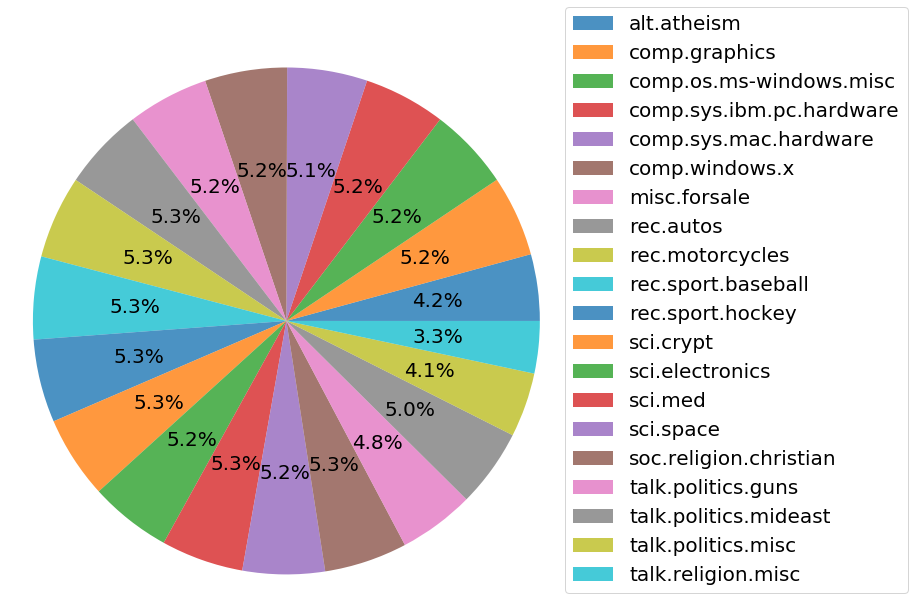

In [13]:
figure = plt.figure(figsize=(10, 10))

targets, sizes = np.unique(train_dataset.target, return_counts=True)
target_names = [train_dataset.target_names[i] for i in targets]

patches, _, _ = plt.pie(sizes, autopct='%1.1f%%', wedgeprops={'alpha': 0.8})

plt.legend(patches, target_names, loc=(1, 0.0))

plt.axis('equal')
plt.show()

Topics have roughly the same number of documents

It might also be useful to look at some language statistical properties: words distribution, document lengths distribution.
Below are just some functions for analyzing texts.

In [14]:
COLOR = (176/255, 0, 0)
FIGSIZE = (15, 10)
SMALL_FIGSIZE = (10, 6)
LINEWIDTH = 5
LABELPAD = 10


# https://en.wikipedia.org/wiki/Zipf%27s_law

def draw_zipfs_plot(
        texts,
        low_outlier_percentile_bound=1,
        upper_outlier_percentile_bound=99,
        ax=None):

    counter = Counter(' '.join(texts).split())
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    else:
        fig = None
    
    frequencies = [freq for word, freq in counter.most_common()]
    low_outlier_bound = np.percentile(frequencies, low_outlier_percentile_bound)
    upper_outlier_bound = np.percentile(frequencies, upper_outlier_percentile_bound)
    frequencies = [freq for freq in frequencies if freq > low_outlier_bound and freq <= upper_outlier_bound]
    
    ranks = range(1, len(frequencies) + 1)
    
    ax.plot(ranks, frequencies, lw=LINEWIDTH, color=COLOR)
    
    ax.set_xlabel('Rank', labelpad=LABELPAD)
    ax.set_ylabel('Frequency', labelpad=LABELPAD)
    ax.set_title('Zipf\'s law')
    
    if fig is not None:
        plt.show()

    return ax


# https://en.wikipedia.org/wiki/Heaps%27_law

def draw_heaps_plot(
        texts,
        in_symbols=True,
        ax=None):

    if in_symbols is True:
        lengths = [len(t) for t in texts]
        length_units = 'symbols'
    else:
        lengths = [len(t.split()) for t in texts]
        length_units = 'words'

    num_uniques = [len(set(t.split())) for t in texts]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    else:
        fig = None
    
    ax.scatter(lengths, num_uniques, s=4 * LINEWIDTH ** 2, color=COLOR)
    
    ax.set_xlabel(f'Document length ({length_units})', labelpad=LABELPAD)
    ax.set_ylabel('Number of unique tokens', labelpad=LABELPAD)
    ax.set_title('Heaps\' law')
    
    if fig is not None:
        plt.show()

    return ax


def draw_document_lengths_histogram(
        texts,
        in_symbols=False,
        low_outlier_percentile_bound=1,
        upper_outlier_percentile_bound=99,
        bins=200,
        ax=None):

    if in_symbols is True:
        lengths = [len(t) for t in texts]
        length_units = 'symbols'
    else:
        lengths = [len(t.split()) for t in texts]
        length_units = 'words'

    low_outlier_bound = np.percentile(lengths, low_outlier_percentile_bound)
    upper_outlier_bound = np.percentile(lengths, upper_outlier_percentile_bound)
    lengths = [l for l in lengths if l > low_outlier_bound and l <= upper_outlier_bound]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    else:
        fig = None
    
    ax.hist(lengths, bins=bins, color=COLOR)
    
    ax.set_xlabel(f'Document length ({length_units})', labelpad=LABELPAD)
    ax.set_ylabel('Number of documents', labelpad=LABELPAD)
    ax.set_title('Document lengths distribution')
    
    if fig is not None:
        plt.show()

    return ax

Analyzing train dataset

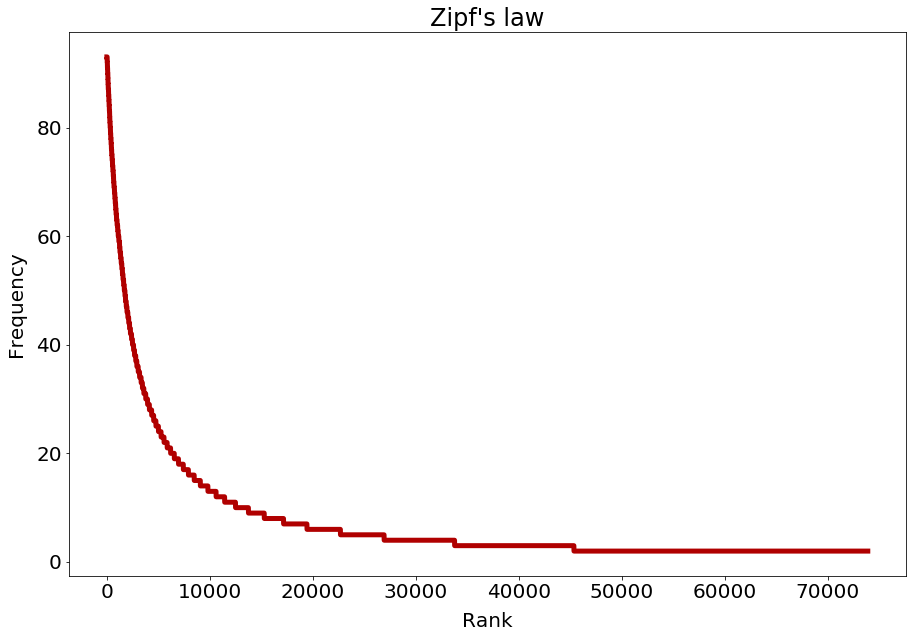

In [15]:
draw_zipfs_plot(train_dataset.data)

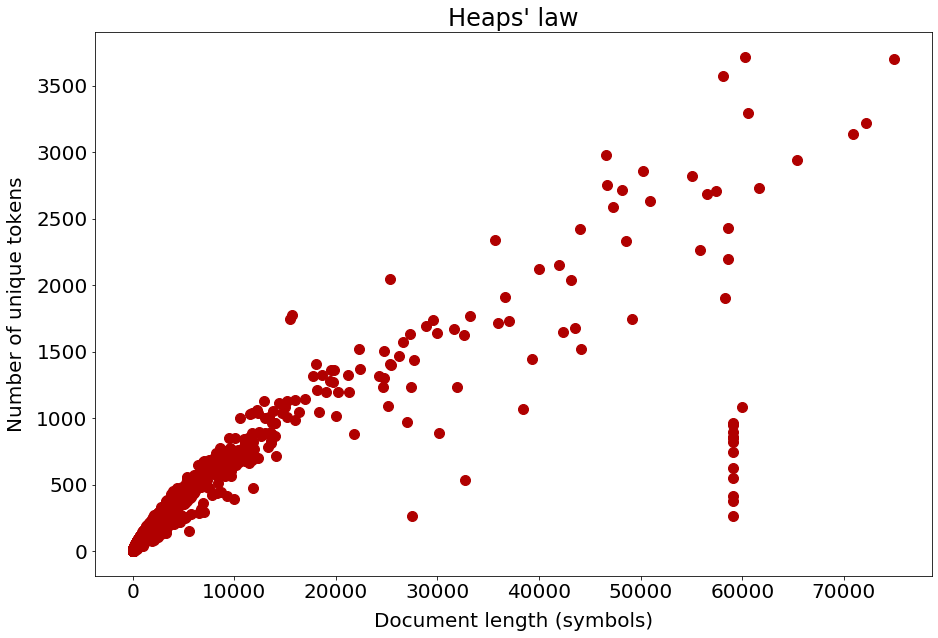

In [16]:
draw_heaps_plot(train_dataset.data)

There is a noticeable drop out of the general trend (near document length = 60.000)...

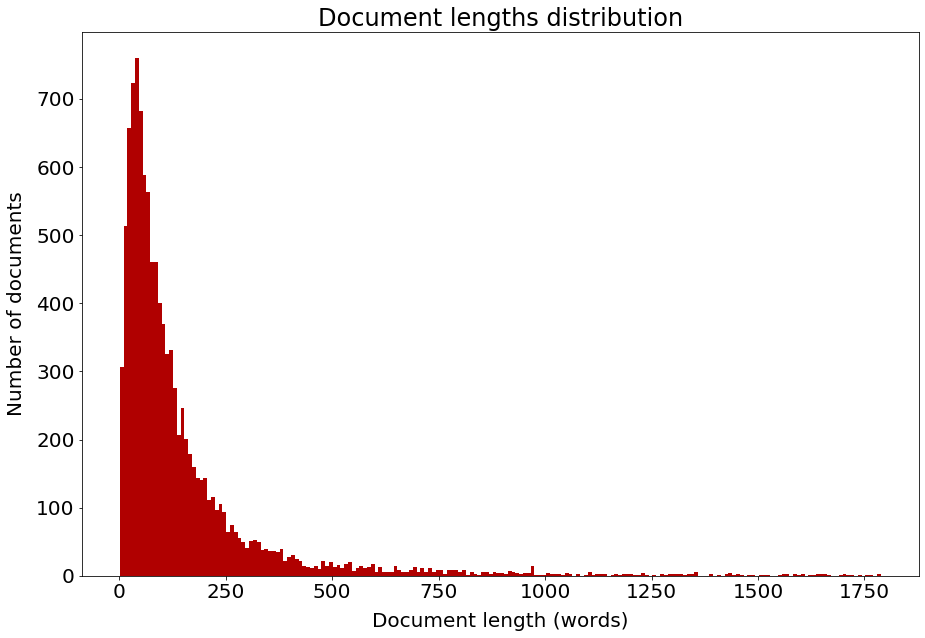

In [17]:
draw_document_lengths_histogram(train_dataset.data)

Let's look if there are some special documents in case of lengths: too short or too long

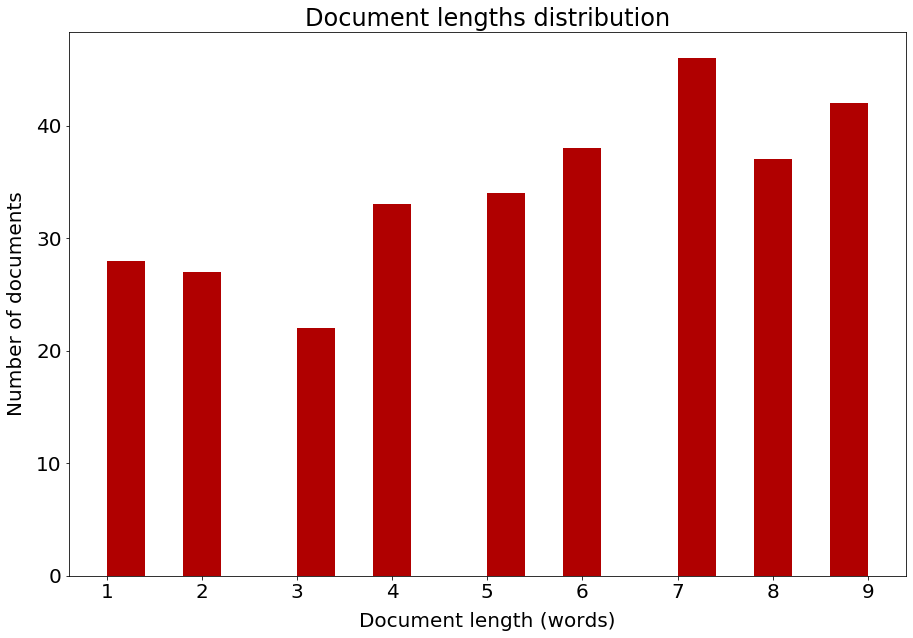

In [18]:
draw_document_lengths_histogram(
    train_dataset.data,
    low_outlier_percentile_bound=0,
    upper_outlier_percentile_bound=5,
    bins=20
)

In [19]:
suspiciously_short_texts = [
    t for t in train_dataset.data
    if len(t.split()) <= 9
]

In [20]:
len(suspiciously_short_texts)

607

In [21]:
print(suspiciously_short_texts[11])

Woof woof!



Thus, most texts that are too short contain little information.

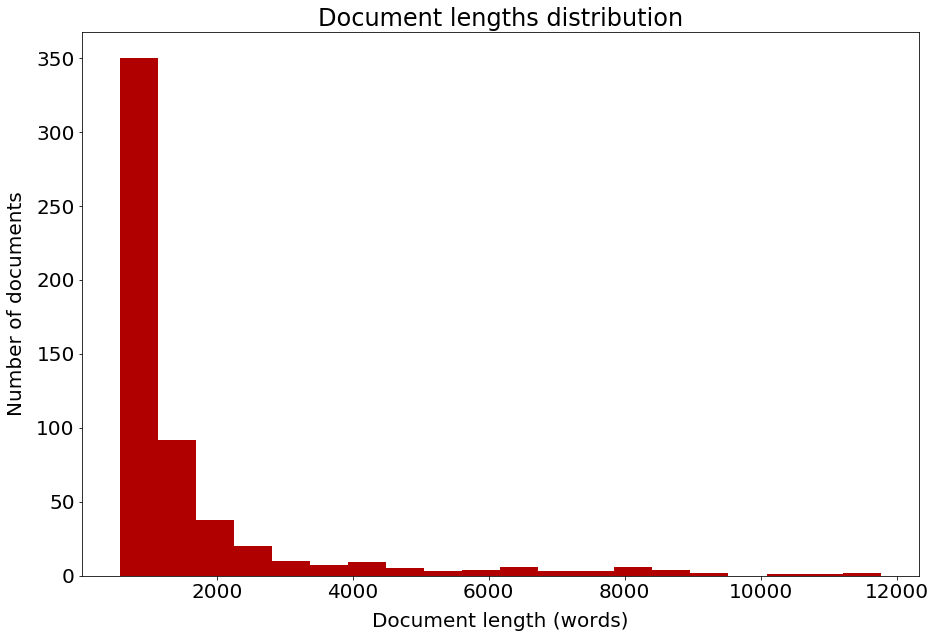

In [22]:
draw_document_lengths_histogram(
    train_dataset.data,
    low_outlier_percentile_bound=95,
    upper_outlier_percentile_bound=100,
    bins=20
)

In [23]:
suspiciously_long_texts = [
    t for t in train_dataset.data
    if len(t.split()) >= 2000
]

In [24]:
len(suspiciously_long_texts)

91

In [25]:
print(suspiciously_long_texts[0][:1000])


: Pardon me? Here is to an amherst-clown:
: 
: "Your three chiefs, Dro, Hamazasp and Kulkhandanian are the ringleaders
:  of the bands which have destroyed Tartar villages and have staged 
:  massacres in Zangezour, Surmali, Etchmiadzin, and Zangibasar. This is
:  intolerable.


Were you expecting a different response? Here is another one:

Source: K. S. Papazian, "Patriotism Perverted," Baikar Press, Boston, 1934, 
        (73 pages with Appendix).

p. 25 (third paragraph)

"Some real fighters sprang up from among the people, who struck terror
 into the hearts of the Turks."


"Within a few months after the war began, these Armenian guerrilla
 forces, operating in close coordination with the Russians, were
 savagely attacking Turkish cities, towns and villages in the east,
 massacring their inhabitants without mercy, while at the same time
 working to sabotage the Ottoman army's war effort by destroying roads
 and bridges, raiding caravans, and doing whatever else they could to
 ease

So, there are some very long documents.
Some of them contain excerpts from other books.

And here is a more compact version, combining all the three mentioned plots

In [26]:
def draw_statistics(texts, figsize=(20, 15), font_size=16):
    old_font_size = plt.rcParams['font.size']
    plt.rcParams.update({'font.size': font_size})

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    draw_zipfs_plot(
        texts,
        ax=axes[0][0]
    )
    draw_document_lengths_histogram(
        texts,
        ax=axes[0][1]
    )
    draw_heaps_plot(
        texts,
        ax=axes[1][0],
        in_symbols=True
    )
    draw_heaps_plot(
        texts,
        ax=axes[1][1],
        in_symbols=False
    )
    
    plt.show()
    
    plt.rcParams.update({'font.size': old_font_size})

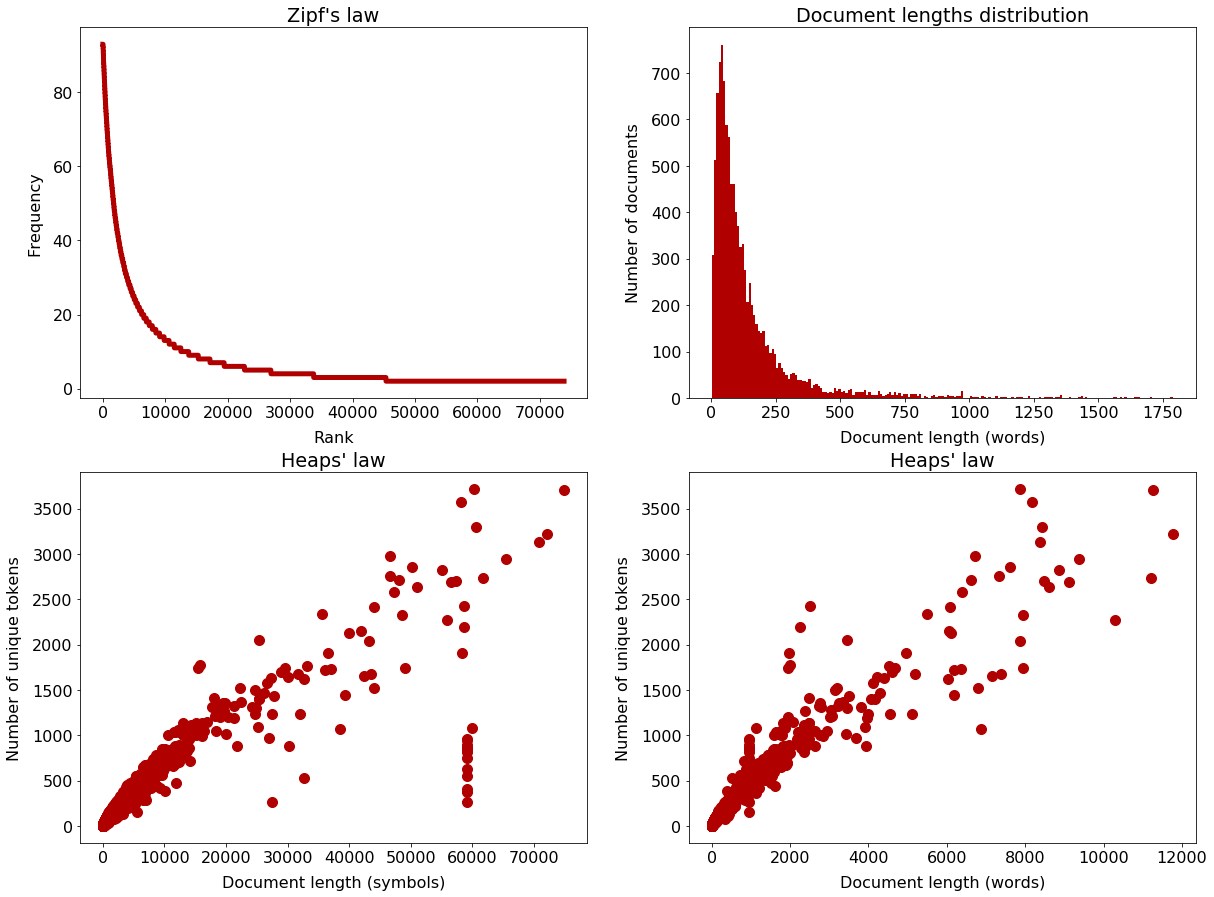

In [27]:
draw_statistics(train_dataset.data)

Let's look at the test part of the dataset

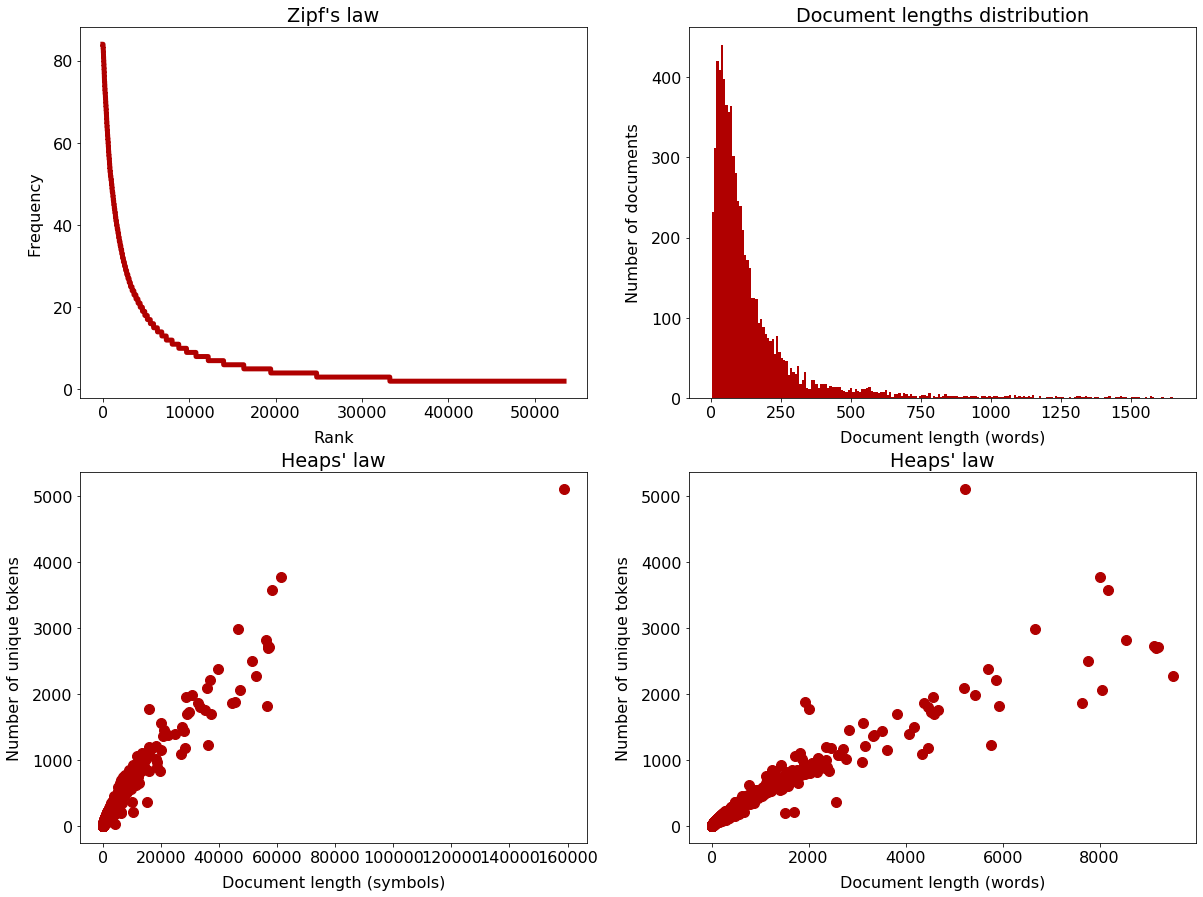

In [28]:
draw_statistics(test_dataset.data)

One document from test dataset has a lot of unique tokens inside...

In [29]:
interesting_document_index = np.argmax([len(set(t.split())) for t in test_dataset.data])

In [30]:
interesting_document_index

2015

In [31]:
len(set(test_dataset.data[interesting_document_index].split()))

5103

In [32]:
print(full_test_dataset.data[interesting_document_index][:5000])

From: dbushong@wang.com (Dave Bushong)
Subject: Re: More Cool BMP files??
Organization: Wang Labs, Lowell MA, USA
Distribution: usa
Lines: 2603

adair@atldbs.dbsoftware.com (Owen Adair) writes:

>In article <1993Apr20.173506.2288@dlss2> james@dlss2 (James Cummings) writes:
>>Newsgroups: comp.os.ms-windows.misc
>>Path: atldbs!uupsi!psinntp!uunet!gatech!howland.reston.ans.net!bogus.sura.net!darwin.sura.net!convex!seas.smu.edu!void!dalnet!dlss2!james
>>From: james@dlss2 (James Cummings)
>>Subject: Re: More Cool BMP files??
>>Message-ID: <1993Apr20.173506.2288@dlss2>
>>Organization: RedRock Development
>>References: <1993Apr17.023017.17301@gmuvax2.gmu.edu>
>>Distribution: usa
>>Date: Tue, 20 Apr 1993 17:35:06 GMT
>>Lines: 1021
>>In article <1993Apr17.023017.17301@gmuvax2.gmu.edu> rwang@gmuvax2.gmu.edu (John Wang) writes:
>> |Hi, everybody:
>> |    I guess my subject has said it all.  It is getting boring
>> |looking at those same old bmp files that came with Windows.  So,
>> |I am wonderin

If we decode this uuencoded file, we get an archive with the following picture inside...

![BUTT](https://raw.githubusercontent.com/Alvant/20-newsgroups-secrets/master/secrets/images/BUTT/BUTT.jpg)

This one and a couple of other such findings can be viewed [here](https://github.com/Alvant/20-newsgroups-secrets) on github

## Preprocessing<a id="preprocessing"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Texts need to be prepared before training models.
Below is a function which removes all symbols except letters from texts, splits text on single tokens and also removes stopwords.
It also lemmatizes all words, i.e. replaces all words with their base forms.
In the end, it combines the remaining words together to form a piece of text.

In [33]:
def preprocess_texts(texts):
    preprocessed_texts = list()
    
    for text in texts:
        text = text.lower()
        
        text = re.sub('[^\\w\\s]', ' ', text)
        text = re.sub('\\d+', ' ', text)
        text = re.sub('\\s+', ' ', text)
        
        words = text.split()
        
        words = [w for w in words if w not in ENGLISH_STOPWORDS]
        words = [ENGLISH_LEMMATIZER.lemmatize(w) for w in words]
        
        text = ' '.join(words)
        
        preprocessed_texts.append(text)
    
    return preprocessed_texts

In [34]:
%%time

preprocessed_train_texts = preprocess_texts(train_dataset.data)

CPU times: user 5.09 s, sys: 57.8 ms, total: 5.15 s
Wall time: 5.15 s


Let's compare an original piece of text, its reduced version (without meta information) and its preprocessed version

In [35]:
print(full_train_dataset.data[0])

print('\n' + '*' * 12 + '\n')

print(train_dataset.data[0])

print('\n' + '*' * 12 + '\n')

print(preprocessed_train_texts[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----






************

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from t

Text size decreased sharply!

In [36]:
%%time

preprocessed_test_texts = preprocess_texts(test_dataset.data)

CPU times: user 2.35 s, sys: 11.2 ms, total: 2.36 s
Wall time: 2.36 s


And same thing for one document from test

In [37]:
print(full_test_dataset.data[0])

print('\n' + '*' * 12 + '\n')

print(test_dataset.data[0])

print('\n' + '*' * 12 + '\n')

print(preprocessed_test_texts[0])

From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. GANDLER)
Subject: Need info on 88-89 Bonneville
Organization: University at Buffalo
Lines: 10
News-Software: VAX/VMS VNEWS 1.41
Nntp-Posting-Host: ubvmsd.cc.buffalo.edu


 I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.

			Neil Gandler


************

I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than boo

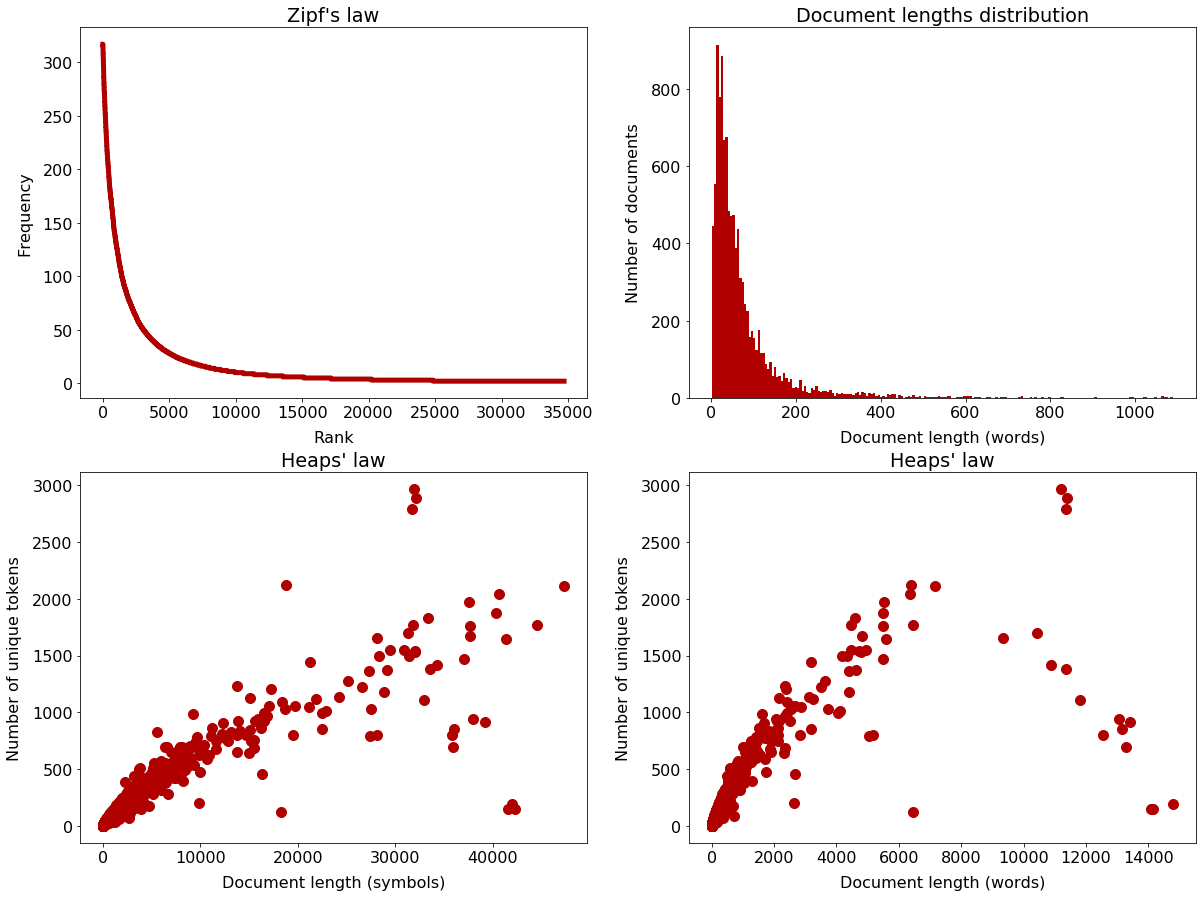

In [38]:
draw_statistics(preprocessed_train_texts)

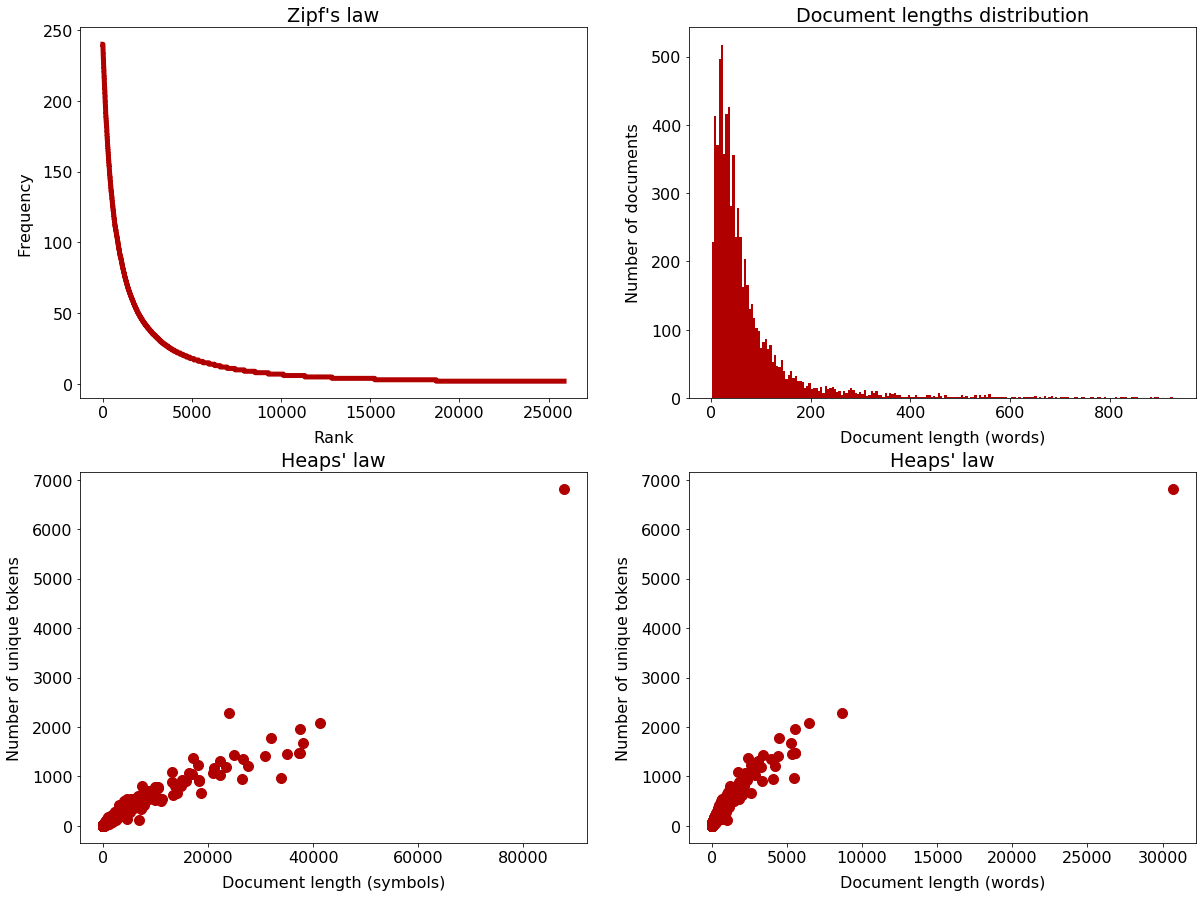

In [39]:
draw_statistics(preprocessed_test_texts)

There are still points, in both train and test parts, that fall out of the empirical dependence suggested by Heaps' law. Let's try to filter the vocabulary according to the word frequency statistics.

In [40]:
vocabulary = reduce(
    lambda res, cur: res.union(set(cur.split())),
    preprocessed_train_texts,
    set()
)

The initial size of the vocabulary

In [41]:
len(vocabulary)

69739

In [42]:
%%time

# How many times did the word occur in the collection

term_frequency_counter = Counter(
    ' '.join(preprocessed_train_texts).split()
)

# How many documents of the collection did the word occur in

document_frequency_counter = Counter(
    ' '.join(
        [' '.join(set(t.split())) for t in preprocessed_train_texts]
    ).split()
)

CPU times: user 418 ms, sys: 31.8 ms, total: 449 ms
Wall time: 448 ms


Let's look at the most/least common words concerning frequency

In [43]:
term_frequency_counter.most_common(20)

[('ax', 62505),
 ('x', 9913),
 ('u', 8189),
 ('q', 7998),
 ('w', 7590),
 ('one', 6767),
 ('f', 6751),
 ('g', 6609),
 ('v', 6383),
 ('p', 6263),
 ('would', 6163),
 ('b', 6102),
 ('r', 6100),
 ('c', 5389),
 ('e', 4637),
 ('max', 4600),
 ('n', 4307),
 ('people', 4135),
 ('l', 4073),
 ('k', 4019)]

In [44]:
term_frequency_counter.most_common()[::-1][:20]

[('willow', 1),
 ('equi', 1),
 ('ebodin', 1),
 ('bodin', 1),
 ('jiggling', 1),
 ('aneurysm', 1),
 ('hemicrania', 1),
 ('paroxysmal', 1),
 ('intracranial', 1),
 ('sured', 1),
 ('ofthe', 1),
 ('kneecap', 1),
 ('alesis', 1),
 ('fraternatae', 1),
 ('egalitae', 1),
 ('libertae', 1),
 ('clawed', 1),
 ('swam', 1),
 ('incidently', 1),
 ('laussane', 1)]

In [45]:
document_frequency_counter.most_common(20)

[('one', 3299),
 ('would', 3168),
 ('like', 2564),
 ('know', 2413),
 ('get', 2338),
 ('time', 2023),
 ('also', 1947),
 ('think', 1930),
 ('people', 1827),
 ('make', 1706),
 ('could', 1682),
 ('use', 1649),
 ('well', 1620),
 ('good', 1591),
 ('way', 1504),
 ('even', 1501),
 ('thing', 1475),
 ('year', 1467),
 ('much', 1457),
 ('say', 1438)]

In [46]:
document_frequency_counter.most_common()[::-1][:20]

[('willow', 1),
 ('equi', 1),
 ('bodin', 1),
 ('jiggling', 1),
 ('ebodin', 1),
 ('intracranial', 1),
 ('millie', 1),
 ('paroxysmal', 1),
 ('hemicrania', 1),
 ('aneurysm', 1),
 ('sured', 1),
 ('ofthe', 1),
 ('kneecap', 1),
 ('alesis', 1),
 ('swam', 1),
 ('libertae', 1),
 ('surpises', 1),
 ('egalitae', 1),
 ('laussane', 1),
 ('clawed', 1)]

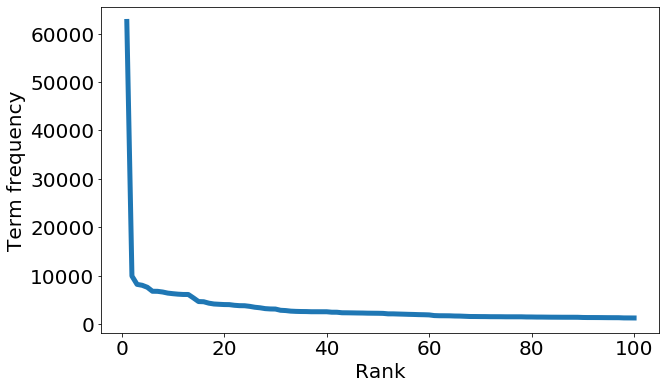

In [47]:
word_and_frequency_pairs = term_frequency_counter.most_common(100)

plt.figure(figsize=SMALL_FIGSIZE)

y = [p[1] for p in word_and_frequency_pairs]
x = list(range(1, 1 + len(y)))

plt.plot(x, y, lw=LINEWIDTH)

plt.xlabel('Rank')
plt.ylabel('Term frequency')

plt.show()

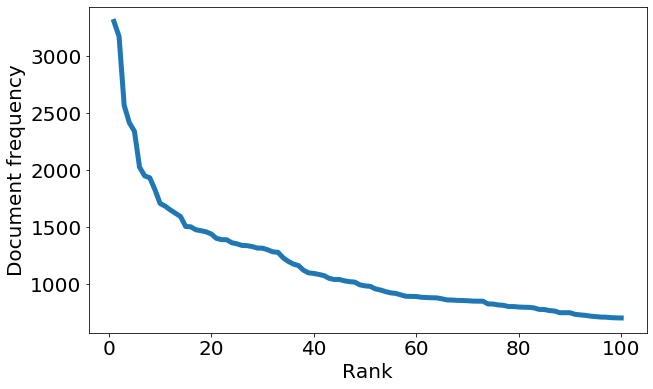

In [48]:
word_and_frequency_pairs = document_frequency_counter.most_common(100)

plt.figure(figsize=SMALL_FIGSIZE)

y = [p[1] for p in word_and_frequency_pairs]
x = list(range(1, 1 + len(y)))

plt.plot(x, y, lw=LINEWIDTH)

plt.xlabel('Rank')
plt.ylabel('Document frequency')

plt.show()

In [49]:
for counter, title in zip(
        [term_frequency_counter, document_frequency_counter],
        ['Term frequency', 'Document frequency']):

    print(title)
    print()

    for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
        result = np.percentile([pair[1] for pair in counter.most_common()], p)

        print(f'{p:2d}th percentile: {result:6.2f}')
    
    print()

Term frequency

 1th percentile:   1.00
 5th percentile:   1.00
10th percentile:   1.00
25th percentile:   1.00
50th percentile:   2.00
75th percentile:   5.00
90th percentile:  21.00
95th percentile:  55.00
99th percentile: 317.00

Document frequency

 1th percentile:   1.00
 5th percentile:   1.00
10th percentile:   1.00
25th percentile:   1.00
50th percentile:   1.00
75th percentile:   3.00
90th percentile:  14.00
95th percentile:  35.00
99th percentile: 188.00



Filtering too frequent and too rare words

In [50]:
vocabulary_filtered_by_term_frequency = set(
    p[0] for p in term_frequency_counter.most_common()
    if p[1] >= 2.0 and p[1] < 100
)

print(len(vocabulary_filtered_by_term_frequency))

33272


In [51]:
vocabulary_filtered_by_document_frequency = set(
    p[0] for p in document_frequency_counter.most_common()
    if p[1] >= 2.0 and p[1] < 35.0
)

print(len(vocabulary_filtered_by_document_frequency))

27560


What words were filtered by term frequency but not by document one

In [52]:
print(vocabulary_filtered_by_document_frequency.difference(
    vocabulary_filtered_by_term_frequency
))

{'b_', 'tq', 'wm', 'di', 'bhj', 'mv', 'lg', 'iq', 'qy', 'ql', 'mov', 'sj', 'tg', 'cj', 'nrhj', 'lib', 'c_', 'sk', 'militia', 'que', 'outlet', 'azerbaijani', 'wiring', 'bh', 'zd', 'jz', 'mw', 'bj', 'rk', 'azeri', 'sq', 'te', 'hiv', 'tl', 'aw', 'contest', 'myers', 'mk', 'ei', 'vz', 'irq', 'r_', 'bxn', 'ml', 'nb', 'char', 'ez', 'yd', 'bm', 'chi', 'hm', 'vw', 'printf', 'tor', 'homicide', 'oname', 'apartment', 'rl', 'fq', 'gk', 'uww', 'mn', 'buf', 'ottoman', 'pu', 'ra', 'pope', 'ripem', 'im', 'filename', 'bn', 'ey', 'biz', 'greece', 'yf', 'pit', 'mq', 'uw', 'ck', 'mh', 'ff', 'anonymity', 'qax', 'fyn', 'tb', 'mf', 'okz', 'eff', 'eq', 'det', 'giz', 'uy', 'fp', 'fij', 'kn', 'ri', 'stl', 'lj', 'tu', 'sumgait', 'rg', 'qq', 'hj', 'cx', 'm_', 'kh', 'cipher', 'gc', 'stephanopoulos', 'ut', 'mj', 'jpeg', 'gq', 'wt', 'rlk', 'echo', 'ww', 'lk', 'chz', 'ho'}


As the final vocabulary we take the intersection of the above two

In [53]:
filtered_vocabulary = vocabulary_filtered_by_document_frequency.intersection(
    vocabulary_filtered_by_term_frequency
)

print(len(filtered_vocabulary))

27440


In [54]:
list(filtered_vocabulary)[-20:]

['tamu',
 'morale',
 'junta',
 'koppel',
 'endocrinologist',
 'admistration',
 'faithfully',
 'canaanite',
 'niland',
 'favoured',
 'sean',
 'accused',
 'mcguire',
 'lmsc',
 'barreled',
 'alphabetical',
 'max_col',
 'pathetically',
 'poer',
 'skull']

Also we will delete too short words, consisting only of one or two letters

In [55]:
filtered_vocabulary = set([
    w for w in filtered_vocabulary if len(w) >= 3
])

print(len(filtered_vocabulary))

26955


Len's count the number of words in each document, but only those words that are in the filtered vocabulary

In [56]:
def count_words(texts, vocabulary):
    text_num_words = list()

    for text in texts:
        counter = Counter(text.split())
        num_words = 0

        for word in counter.keys():
            if word in vocabulary:
                num_words = num_words + 1

        text_num_words.append(num_words)
    
    return text_num_words

In [57]:
train_document_num_words = count_words(preprocessed_train_texts, filtered_vocabulary)

In [58]:
len(train_document_num_words)  # i.e. total number of documents

11314

In [59]:
print('Number of filtered words in document')
print()

for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    result = np.percentile(train_document_num_words, p)
    
    print(f'{p:2d}th percentile: {result:6.2f}')

Number of filtered words in document

 1th percentile:   0.00
 5th percentile:   0.00
10th percentile:   1.00
25th percentile:   3.00
50th percentile:   7.00
75th percentile:  14.00
90th percentile:  27.00
95th percentile:  44.00
99th percentile: 152.61


Let's take some threshold and filter too big and small documents

In [60]:
threshold = 100

print('Documents before filtering:', len(train_document_num_words))

targets, target_sizes = np.unique(
    [t for i, t in enumerate(train_dataset.target) if train_document_num_words[i] < threshold],
    return_counts=True
)

print('Documents  after filtering:', sum(target_sizes))

Documents before filtering: 11314
Documents  after filtering: 11112


Let's won't try to adjust the upper threshold any further: let it be equal 100 words.

In [61]:
upper_threshold = 100

In [62]:
threshold = 4

print('Documents before filtering:', len(train_document_num_words))

targets, target_sizes = np.unique(
    [t for i, t in enumerate(train_dataset.target) if train_document_num_words[i] >= threshold],
    return_counts=True
)

print('Documents  after filtering:', sum(target_sizes))

Documents before filtering: 11314
Documents  after filtering: 8049


Several thousand documents were thrown away. Are the topics still balanced?

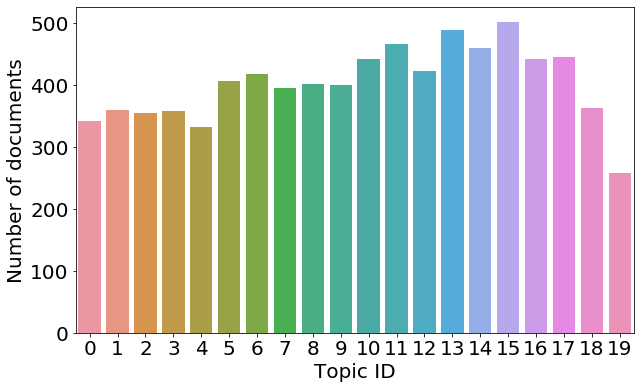

In [63]:
plt.figure(figsize=SMALL_FIGSIZE)

sns.barplot(targets, target_sizes, alpha=1.0)

plt.xlabel('Topic ID')
plt.ylabel('Number of documents')

plt.show()

In [64]:
print(
    'Number of documents after filtering:\n',
    sum(target_sizes)
)
print(
    'Absolute difference between most and least populated topics (in documents):\n',
    max(target_sizes) - min(target_sizes)
)
print(
    'Relative difference between most and least populated topics (in documents):\n',
    f'{(max(target_sizes) - min(target_sizes)) / min(target_sizes):.3f}'
)

Number of documents after filtering:
 8049
Absolute difference between most and least populated topics (in documents):
 243
Relative difference between most and least populated topics (in documents):
 0.942


So, there actually is some imbalance, but most topics still have roughly equal number of documents

Maybe there is a better threshold? Below we will go over several values, remembering the maximum difference between numbers of documents in topics (the lower this value, the better)

In [65]:
quotients = list()
thresholds = list(range(20))

for threshold in thresholds:
    targets, target_sizes = np.unique(
        [t for i, t in enumerate(train_dataset.target) if train_document_num_words[i] >= threshold],
        return_counts=True
    )
    
    quotients.append(
        (max(target_sizes) - min(target_sizes)) / min(target_sizes)
    )

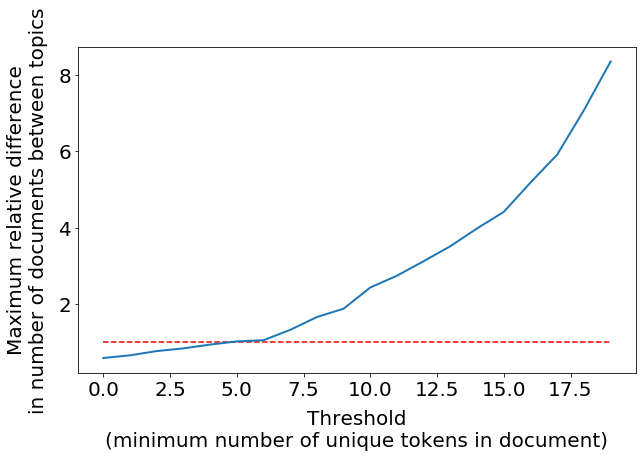

In [66]:
plt.figure(figsize=SMALL_FIGSIZE)

plt.plot(thresholds, quotients, lw=2)
plt.hlines(1, 0, 19, linestyle='--', color='r')

plt.xlabel('Threshold\n(minimum number of unique tokens in document)', labelpad=LABELPAD)
plt.ylabel('Maximum relative difference\nin number of documents between topics', labelpad=LABELPAD)

plt.show()

Seems that the biggest acceptable threshold (the one which gives the relative difference less than one) is 4 unique words in document

In [67]:
lower_threshold = 4

In [68]:
good_train_document_indices = [
    i for i, n in enumerate(train_document_num_words)
    if n >= lower_threshold and n < upper_threshold
]

good_train_document_texts = list()

for i, text in enumerate(preprocessed_train_texts):
    if i not in good_train_document_indices:
        continue
    
    text = ' '.join([w for w in text.split() if w in filtered_vocabulary])
    
    good_train_document_texts.append(text)

In [69]:
len(good_train_document_indices)

7847

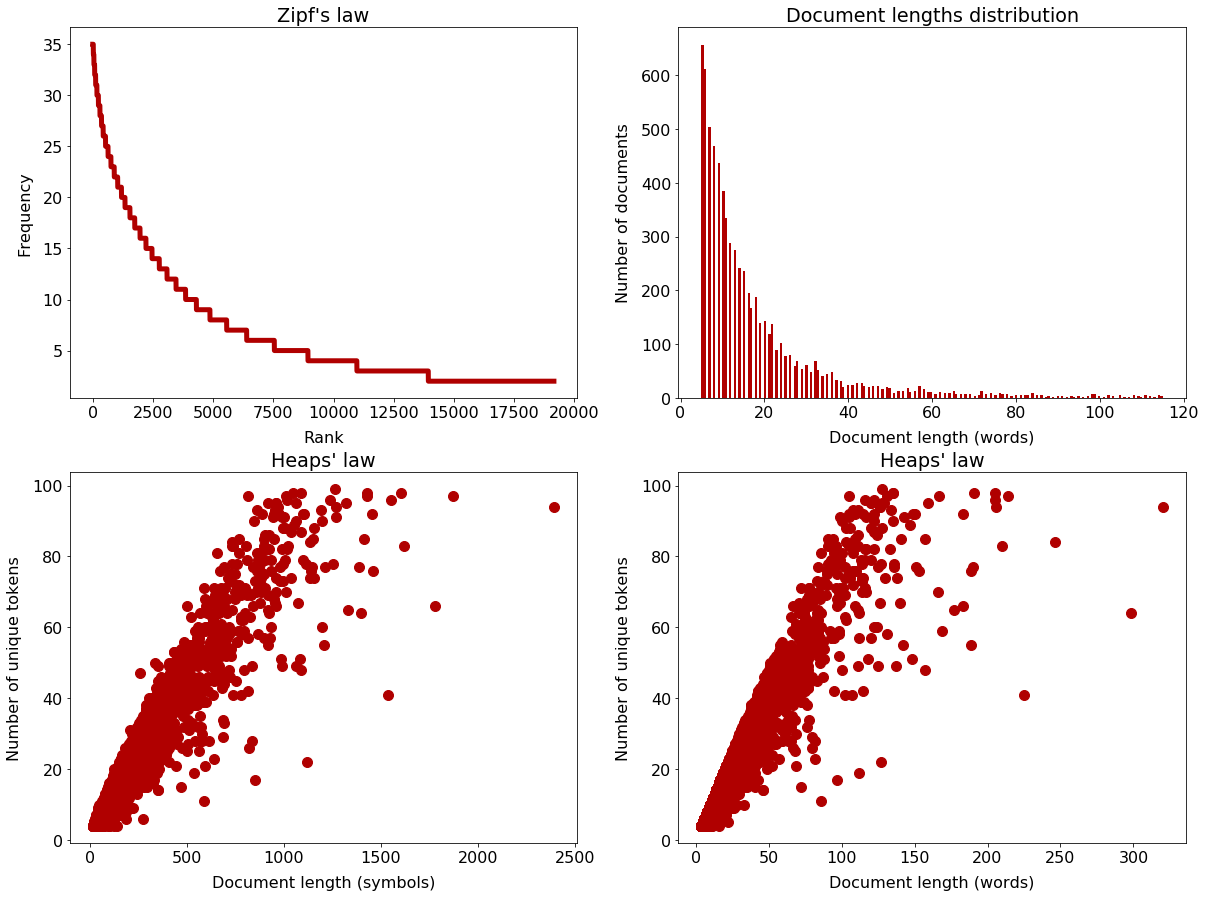

In [70]:
draw_statistics(good_train_document_texts)

Also filtering test dataset

In [71]:
test_document_num_words = count_words(preprocessed_test_texts, filtered_vocabulary)

In [72]:
good_test_document_indices = [
    i for i, n in enumerate(test_document_num_words) if n >= lower_threshold and n < upper_threshold
]

good_test_document_texts = list()

for i, text in enumerate(preprocessed_test_texts):
    if i not in good_test_document_indices:
        continue
    
    text = ' '.join([w for w in text.split() if w in filtered_vocabulary])
    
    good_test_document_texts.append(text)

In [73]:
len(good_test_document_indices)

4931

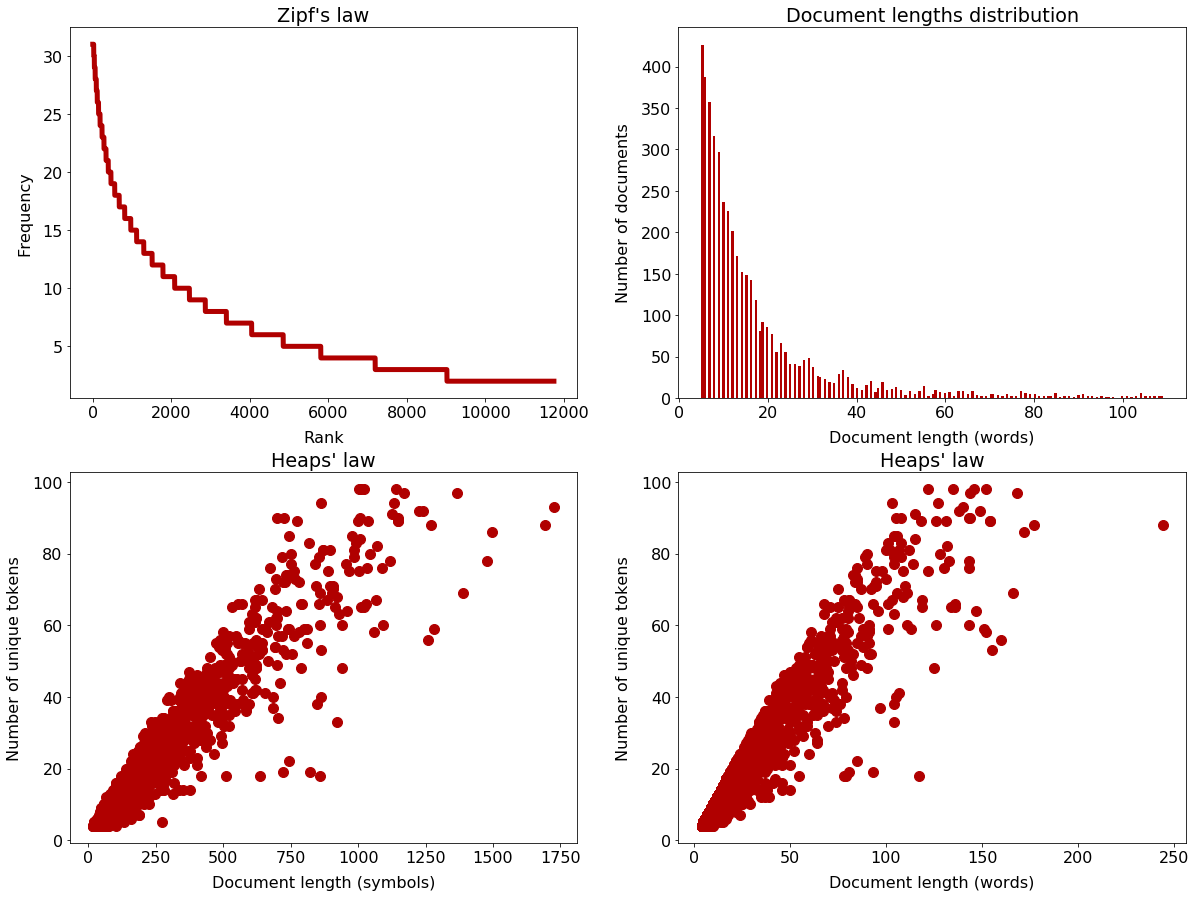

In [74]:
draw_statistics(good_test_document_texts)

Train and test dataset parts even after preprocessing satisfy Zipf's and Heaps' laws, and the distribution of documents by lengths is the nearly the same for train and test parts.

Let's define the final vocabulary variable and mappings from word to int and visa versa, which will be used in Nets later

In [76]:
UNKNOWN_WORD = '<UNK>'

VOCABULARY = [UNKNOWN_WORD] + sorted(list(filtered_vocabulary))  # sorted — for reproducibility

WORD_TO_INDEX = dict() # defaultdict(lambda: 0)  # <UNK>

for i, w in enumerate(VOCABULARY):
    WORD_TO_INDEX[w] = i

INDEX_TO_WORD = {i: w for i, w in enumerate(VOCABULARY)}

WORD_INDICES = list(INDEX_TO_WORD)

In [77]:
TRAIN_DOCUMENT_INDICES = list(good_train_document_indices)
TEST_DOCUMENT_INDICES = list(good_test_document_indices)

In [78]:
custom_np = RandomState(11221963)

SAMPLE_SIZE = 1000

WORD_INDICES_SAMPLE = custom_np.choice(
    [WORD_TO_INDEX[w] for w in VOCABULARY[1:] if len(w) > 3],
    size=SAMPLE_SIZE,
    replace=False, 
)

TRAIN_DOCUMENT_INDICES_SAMPLE = custom_np.choice(
    TRAIN_DOCUMENT_INDICES, size=SAMPLE_SIZE, replace=False, 
)

TEST_DOCUMENTS_INDICES_SAMPLE = custom_np.choice(
    TEST_DOCUMENT_INDICES, size=SAMPLE_SIZE, replace=False, 
)

In [79]:
TRAIN_DOCUMENT_WORD_INDICES = {
    document_index: [WORD_TO_INDEX[w] for w in good_train_document_texts[i].split()]
    for i, document_index in enumerate(good_train_document_indices)
}

TEST_DOCUMENT_WORD_INDICES = {
    document_index: [WORD_TO_INDEX[w] for w in good_test_document_texts[i].split()]
    for i, document_index in enumerate(good_test_document_indices)
}

In [80]:
%%time

TRAIN_DOCUMENT_SIMILARITIES = {
    document_index: {
        j: 1 if train_dataset.target[document_index] == train_dataset.target[j] else 0
        for j in good_train_document_indices
    }
    for document_index in good_train_document_indices
}

TEST_DOCUMENT_SIMILARITIES = {
    document_index: {
        j: 1 if test_dataset.target[document_index] == test_dataset.target[j] else 0
        for j in good_test_document_indices
    }
    for document_index in good_test_document_indices
}

CPU times: user 1min 16s, sys: 612 ms, total: 1min 16s
Wall time: 1min 16s


In [81]:
TRAIN_DOCUMENT_WORD_INDICES[2]

[9576,
 21884,
 21883,
 17758,
 18166,
 6447,
 18166,
 1280,
 13998,
 18166,
 23010,
 26646,
 21844,
 22649,
 3002,
 10483,
 18303,
 25887,
 7244,
 18762,
 18762]

In [82]:
list(TRAIN_DOCUMENT_SIMILARITIES[2].items())[:10]

[(0, 0),
 (1, 1),
 (2, 1),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (9, 1),
 (10, 0),
 (11, 0)]

## Data Preparation<a id="data-preparation"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Here starts the part connected with some more advanced text handling, with the help of BigARTM library.
Why is this needed at all?
Word2Vec is about word representations based on context information.
One should not necessarily use neural nets to get some of this knowledge.
ARTM provides a tool to gather [some statistics](https://bigartm.readthedocs.io/en/stable/tutorials/python_userguide/coherence.html) about word cooccurrences.
Based on this statistics one can evaluate the quality of Word2Vec models: W2V representations should be at least somehow correlated with the cooccurrence statistics.

All files, to be further generated in the notebook, are going to be saved in this directory

In [83]:
working_directory = tempfile.mkdtemp()

In [86]:
working_directory = '/tmp/tmptdtuyxqk'

In [88]:
working_directory

'/tmp/tmptdtuyxqk'

In [89]:
def prefix_path(path):
    return os.path.join(working_directory, path)

First, again, we need to do some things with data: prepare it for future models.

### Vowpal Wabbit<a id="vowpal-wabbit"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

* https://bigartm.readthedocs.io/en/v0.8.1/formats.html
* https://bigartm.readthedocs.io/en/stable/tutorials/datasets.html

We will use only one modality in this notebook. We don't need more for W2V :)

In [90]:
MODALITY = '@text'

In [91]:
def to_vowpal_wabbit(document_names, document_texts, vocabulary, natural_order=True):
    vw_texts = list()

    for document_index, (document_name, text) in enumerate(zip(document_names, document_texts)):
        vw_line = f'{document_name}'
        vw_line = vw_line + f' |{MODALITY}'

        if natural_order:
            vw_line = vw_line + f' {text}'
        else:
            counter = Counter(text.split())

            for word, frequency in counter.items():
                if word not in vocabulary:
                    continue

                vw_line = vw_line + f' {word}:{frequency}'

        vw_texts.append(vw_line)
    
    return vw_texts

In [92]:
train_document_names = [
    os.path.split(document_path)[-1] for i, document_path in enumerate(train_dataset.filenames)
    if i in good_train_document_indices
]

test_document_names = [
    os.path.split(document_path)[-1] for i, document_path in enumerate(test_dataset.filenames)
    if i in good_test_document_indices
]

We will save data in both formats: natural order and Bag of words order.
Natural one will help when computing word cooccurrence statistics.

In [93]:
TRAIN = 'train'
TEST = 'test'

NATURAL_ORDER_SUFFIX = '_natural_order'
BAG_OF_WORDS_SUFFIX = ''

In [94]:
train_test_vw_texts = dict()

for natural_order, word_order_suffix in zip(
        [True, False],
        [NATURAL_ORDER_SUFFIX, BAG_OF_WORDS_SUFFIX]):

    for document_names, document_texts, dataset_part_name in zip(
            [train_document_names, test_document_names],
            [good_train_document_texts, good_test_document_texts],
            [TRAIN, TEST]):

        vw_texts = to_vowpal_wabbit(
            document_names,
            document_texts,
            filtered_vocabulary,
            natural_order=natural_order
        )

        train_test_vw_texts[f'{dataset_part_name}{word_order_suffix}'] = vw_texts

        vw_text = '\n'.join(vw_texts)
        vw_file_name = f'{dataset_part_name}_vw{word_order_suffix}.txt'

        with open(prefix_path(vw_file_name), 'w') as f:
            f.write(vw_text)

Saved vw texts (we will need them in a couple of seconds)

In [95]:
train_test_vw_texts.keys()

dict_keys(['train_natural_order', 'test_natural_order', 'train', 'test'])

In [96]:
os.listdir(working_directory)

['test_vw_natural_order.txt',
 'train_vw_natural_order.txt',
 'test_vw.txt',
 'train_vw.txt']

Let's organize texts in a .csv table with certain columns, to make the collection more convenient to look at.

In [97]:
for word_order_suffix in [NATURAL_ORDER_SUFFIX, BAG_OF_WORDS_SUFFIX]:

    for document_indices, raw_texts, dataset_part_name in zip(
            [good_train_document_indices, good_test_document_indices],
            [good_train_document_texts, good_test_document_texts],
            [TRAIN, TEST]):

        dataset_table = pd.DataFrame(
            index=document_indices,
            columns=['id', 'raw_text', 'vw_text']
        )

        vw_texts = train_test_vw_texts[f'{dataset_part_name}{word_order_suffix}']

        dataset_table['id'] = [text.split()[0] for text in vw_texts]
        dataset_table['raw_text'] = raw_texts
        dataset_table['vw_text'] = vw_texts

        dataset_table_file_name = f'{dataset_part_name}_dataset{word_order_suffix}.csv'

        # TODO!!! some fuck error
        dataset_table.to_csv(prefix_path(dataset_table_file_name), index=False)

In [98]:
os.listdir(working_directory)

['test_dataset.csv',
 'train_dataset_natural_order.csv',
 'test_vw_natural_order.txt',
 'train_dataset.csv',
 'test_dataset_natural_order.csv',
 'train_vw_natural_order.txt',
 'test_vw.txt',
 'train_vw.txt']

Let's look at some table's first rows (this partucular table is not going to be used further, it just still exists as cycle inner variable in Python)

In [99]:
dataset_table.head()

id                                           raw_text  \
1  67445                   dpg uncompressed anyones swamped   
3  77355  iraqi kuwait saudi iraqi swallowed saudi arabi...   
5  59518  nth yeast brainwashing hated microbiology cand...   
7  21684  lexicon wordperfect wiped restore distributor ...   
8  67466  dynamically closing cleanup transition anticipate   

                                             vw_text  
1  67445 |@text dpg:1 uncompressed:1 anyones:1 sw...  
3  77355 |@text iraqi:3 kuwait:2 saudi:6 swallowe...  
5  59518 |@text nth:1 yeast:4 brainwashing:1 hate...  
7  21684 |@text lexicon:1 wordperfect:1 wiped:1 r...  
8  67466 |@text dynamically:1 closing:1 cleanup:1...

Let's load saved datasets and see if all OK.

In [100]:
dataset = pd.read_csv(prefix_path(f'{TRAIN}_dataset.csv'))
holdout_dataset = pd.read_csv(prefix_path(f'{TEST}_dataset.csv'))

In [101]:
dataset.head()

id                                           raw_text  \
0  102994                    enlighten bricklin bumper funky   
1   51861  upgraded oscillator poll detailing attained si...   
2   51879  ghost sooo sooner picking powerbook dirt power...   
3   60880           std std baker suchlike introduce liftoff   
4   54525             rigidly allegedly presenting evidently   

                                             vw_text  
0  102994 |@text enlighten:1 bricklin:1 bumper:1 ...  
1  51861 |@text upgraded:1 oscillator:1 poll:2 de...  
2  51879 |@text ghost:1 sooo:1 sooner:1 picking:1...  
3  60880 |@text std:2 baker:1 suchlike:1 introduc...  
4  54525 |@text rigidly:1 allegedly:1 presenting:...

In [102]:
holdout_dataset.head()

id                                           raw_text  \
0  67445                   dpg uncompressed anyones swamped   
1  77355  iraqi kuwait saudi iraqi swallowed saudi arabi...   
2  59518  nth yeast brainwashing hated microbiology cand...   
3  21684  lexicon wordperfect wiped restore distributor ...   
4  67466  dynamically closing cleanup transition anticipate   

                                             vw_text  
0  67445 |@text dpg:1 uncompressed:1 anyones:1 sw...  
1  77355 |@text iraqi:3 kuwait:2 saudi:6 swallowe...  
2  59518 |@text nth:1 yeast:4 brainwashing:1 hate...  
3  21684 |@text lexicon:1 wordperfect:1 wiped:1 r...  
4  67466 |@text dynamically:1 closing:1 cleanup:1...

### Cooccurrences<a id="cooccurrences"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

ATTENTION! This section is semi-manual: one will need to do some things outside of the notebook, namely run instructions in command line.
If you don't want/can't/don't have enough time to do this kind of stuff, leave the `WITH_COOCS` variable equal `False`, and everything will be fine (you still may run *all* the remaining cells in the notebook).
However, it is highly recommended to try calculate cooccurrence statistics as described below.
This will give an opprotunity to evaluate the quality of W2V models more thoroughly and thoughtfully.
To delve into coocs, set `WITH_COOCS` equal `True`.

In [103]:
WITH_COOCS = False

Natural order vowpal wabbit files were needed for gathering word cooccurrence statistics.
And this, in turn, will be needed further for evaluation of the quality of word representations of W2V models using.

First, we need vocab in UCI bag-of-words format

* https://bigartm.readthedocs.io/en/stable/tutorials/datasets.html

In [104]:
vocab = ''

for word in filtered_vocabulary:
    vocab += f'{word} {MODALITY}\n'

with open(prefix_path('vocab.txt'), 'w') as f:
    f.write(vocab)

open(prefix_path('vocab.txt'), 'r').readlines()[:2]

['nunn @text\n', 'attendance @text\n']

Now we are approaching the stage of gathering cooccurrence statistics...
It can be done with the help of BigARTM library (or more precisely BigARTM Command line utility).
There are several links one can visit to get some knowledge about the process.

* Coherence: https://bigartm.readthedocs.io/en/stable/tutorials/python_userguide/coherence.html
* Command line utility: https://bigartm.readthedocs.io/en/stable/tutorials/bigartm_cli.html
* Example of gathering coocs statistics (in Russian): https://nbviewer.jupyter.org/github/bigartm/bigartm-book/blob/master/junk/cooc_dictionary/example_of_gathering.ipynb

In [105]:
working_directory

'/tmp/tmptdtuyxqk'

So, unfortunately, it is impossible currently (with artm version '0.10.0' at least) to do everything just here in the notebook.
One should use the command line utility.
Here is an example of bash command line instruction which helps to run the utility (it might be more convenient to place it into a .sh script)

```bash
cd <working_directory path> && <path to the folder where bigartm resides>/bigartm/build/bin/bigartm \
    -c train_vw_natural_order.txt \
    -v vocab.txt \
    --cooc-window 10 \
    --cooc-min-tf 1 \
    --write-cooc-tf cooc_tf_ \
    --cooc-min-df 1 \
    --write-cooc-df cooc_df_ \
    --write-ppmi-tf ppmi_tf_ \
    --write-ppmi-df ppmi_df_
```

If everything worked fine, now we have coocs data calculated

In [106]:
os.listdir(working_directory)

['test_dataset.csv',
 'cooc_tf_',
 'train_dataset_natural_order.csv',
 'bigartm.miptai.vasiliyalekseev.log.INFO.20200125-160744.2395',
 'vocab.txt',
 'test_vw_natural_order.txt',
 'ppmi_df_',
 'train_dataset.csv',
 'test_dataset_natural_order.csv',
 'train_vw_natural_order.txt',
 'ppmi_tf_',
 'cooc_df_',
 'test_vw.txt',
 'bigartm.INFO',
 'train_vw.txt']

Let's look at the first lines of one of the gerenared coocs files

In [107]:
if WITH_COOCS is True:
    print(
        open(prefix_path('ppmi_tf_'), 'r').readlines()[:2]
    )

['@text nunn chairman:5.93295 commission:6.50751 constituency:6.83318 gen:5.70837 roa:8.15937 demographic:6.79839 ret:5.95477 maj:6.71638 evan:8.56484 closure:7.07757 marine:6.28501 sen:6.58383 naval:5.238 realignment:7.94965 personnel:5.48293\n', '@text attendance francais:5.84766 scare:4.23252 naslund:4.38573 rome:3.46547 libertarianism:4.21005 africa:3.358 embrace:4.02773 icing:5.43272 excessive:3.53089 undoubtedly:4.84388 arrival:5.91258 typing:3.69923 resist:4.0559 arena:2.86342 out:3.31396 lifestyle:3.61305 saberhagen:4.52021 oiler:4.27508 deserves:3.61 preference:3.2025 kicking:4.1719 finland:2.86487 milan:4.68451 participation:3.50861 kick:3.82517 paris:3.78261 creative:3.70928 renberg:4.32784 murray:2.97652 larkin:4.26721 personality:4.79784 predict:4.0347 bandwagon:5.79209 edm:4.46137 rundqvist:4.79784 har:3.49493 lobby:4.18265 fin:5.42645 mario:5.26214 tomlin:4.92567 competitive:4.99325 nyi:3.57406 seminar:4.02311 picking:4.11222 tournament:4.49035 measured:3.2168 enthusiast

It would seem that this should already be enough, but let's make another little preprocessing.

In [108]:
def transform_coocs_file(source_file_path, target_file_path, vocab_file_path):
    """
    source_file is assumed to be either ppmi_tf_ or ppmi_df_ 
    """
    num_times_to_log = 10

    vocab = open(vocab_file_path, 'r').readlines()
    vocab = [l.strip().split()[0] for l in vocab]
    
    cooc_values = dict()
    word_word_value_triples = set()
    
    lines = open(source_file_path, 'r').readlines()
    
    for i, l in enumerate(lines):
        if i % (len(lines) // num_times_to_log) == 0:
            print(f'{i:6d} lines out of {len(lines)}')
        
        l = l.strip()
        words = l.split()
        words = words[1:]  # exclude modality
        anchor_word = words[0]
        
        other_word_values = words[1:]
        
        for word_and_value in other_word_values:
            other_word, value = word_and_value.split(':')
            value = float(value)
            
            cooc_values[(anchor_word, other_word)] = value
            cooc_values[(other_word, anchor_word)] = value  # if assume cooc values to be symmetric
            
            word_word_value_triples.add(
                tuple([
                    tuple(sorted([
                        vocab.index(anchor_word),
                        vocab.index(other_word)
                    ])),
                    value
                ])
            )
    
    new_text = ''
    
    for (w1, w2), v in word_word_value_triples:
        new_text += f'{w1} {w2} {v}\n'
    
    with open(target_file_path, 'w') as f:
        f.write(''.join(new_text))
    
    return cooc_values

`cooc_values` is a dictionary which maps a word pair to its cooc value

In [109]:
if WITH_COOCS is True:
    cooc_values = transform_coocs_file(
        prefix_path('ppmi_tf_'),
        prefix_path('new_ppmi_tf_'),
        prefix_path('vocab.txt')
    )

     0 lines out of 21917
  2191 lines out of 21917
  4382 lines out of 21917
  6573 lines out of 21917
  8764 lines out of 21917
 10955 lines out of 21917
 13146 lines out of 21917
 15337 lines out of 21917
 17528 lines out of 21917
 19719 lines out of 21917
 21910 lines out of 21917


In [110]:
if WITH_COOCS is True:
    print(list(cooc_values.items())[:10])

[(('nunn', 'chairman'), 5.93295), (('chairman', 'nunn'), 5.93295), (('nunn', 'commission'), 6.50751), (('commission', 'nunn'), 6.50751), (('nunn', 'constituency'), 6.83318), (('constituency', 'nunn'), 6.83318), (('nunn', 'gen'), 5.70837), (('gen', 'nunn'), 5.70837), (('nunn', 'roa'), 8.15937), (('roa', 'nunn'), 8.15937)]


Let's save also this coocs values dictionary

In [111]:
if WITH_COOCS is True:
    with open(prefix_path('cooc_values.json'), 'w') as f:
        f.write(json.dumps(list(cooc_values.items())))

Checking if all OK after saving

In [112]:
if WITH_COOCS is True:
    saved_raw_cooc_values = json.loads(open(prefix_path('cooc_values.json'), 'r').read())

    saved_cooc_values = {
        tuple(d[0]): d[1] for d in saved_raw_cooc_values
    }

In [113]:
if WITH_COOCS is True:
    print(list(saved_cooc_values.items())[:10])

[(('nunn', 'chairman'), 5.93295), (('chairman', 'nunn'), 5.93295), (('nunn', 'commission'), 6.50751), (('commission', 'nunn'), 6.50751), (('nunn', 'constituency'), 6.83318), (('constituency', 'nunn'), 6.83318), (('nunn', 'gen'), 5.70837), (('gen', 'nunn'), 5.70837), (('nunn', 'roa'), 8.15937), (('roa', 'nunn'), 8.15937)]


In [119]:
if WITH_COOCS is False:
    WORD_SIMILARITIES = None
else:
    WORD_SIMILARITIES = defaultdict(dict)

    for word_pair, similarity in cooc_values.items():
        word_index_a, word_index_b = [WORD_TO_INDEX[w] for w in word_pair]

        WORD_SIMILARITIES[word_index_a][word_index_b] = similarity
        WORD_SIMILARITIES[word_index_b][word_index_a] = similarity  # symmetric

    print(list(WORD_SIMILARITIES.items())[:1])

[(16355,
  {3795: 5.93295,
   4484: 6.50751,
   4831: 6.83318,
   9467: 5.70837,
   20238: 8.15937,
   6014: 6.79839,
   19926: 5.95477,
   14099: 6.71638,
   8019: 8.56484,
   4234: 7.07757,
   14245: 6.28501,
   21035: 6.58383,
   15791: 5.238,
   19271: 7.94965,
   17578: 5.48293})]

# Neural Nets<a id="nets"></a>

## Logging<a id="logging"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Loggins seems particularly handy in case of neural nets: one can track the learning process.

In [121]:
# Creating logger
logger = logging.getLogger('W2V')
logger.setLevel(logging.DEBUG)

# Creating file handler
fh = logging.FileHandler(prefix_path('logs.txt'))
fh.setLevel(logging.DEBUG)

# Creating formatter
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s',
    '%Y-%m-%d %H:%M:%S'
)

# Adding formatter to file handler
fh.setFormatter(formatter)

# Adding file handler to logger
logger.addHandler(fh)

## Sandbox Dataset<a id="sandbox-dataset"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Simple toy dataset for testing purposes:
* to check if nets just work somehow
* to check if nets can fit this data 

In [126]:
SANDBOX_DOCUMENT_WORDS = [['johnny', 'eat', 'makaroni'], ['tree', 'subsample', 'underground']]
SANDBOX_DOCUMENT_INDICES = [0, 1]

SANDBOX_VOCABULARY = set(itertools.chain.from_iterable(SANDBOX_DOCUMENT_WORDS))

SANDBOX_WORD_TO_INDEX = {w: i for (i, w) in enumerate(SANDBOX_VOCABULARY)}
SANDBOX_INDEX_TO_WORD = {i: w for (i, w) in enumerate(SANDBOX_VOCABULARY)}

SANDBOX_WORD_INDICES = list(SANDBOX_INDEX_TO_WORD)

SANDBOX_DOCUMENT_WORD_INDICES = {
    document: [SANDBOX_WORD_TO_INDEX[w] for w in text]
    for document, text in enumerate(SANDBOX_DOCUMENT_WORDS)
}

In [127]:
SANDBOX_WORD_SIMILARITIES = {
    0: {1: 0.0, 2: 0.5, 3: 0.0, 4: 0.0, 5: 0.2},
    1: {0: 0.0, 2: 0.0, 3: 0.2, 4: 0.0, 5: 0.0},
    2: {0: 0.5, 1: 0.0, 3: 0.2, 4: 0.0, 5: 0.1},
    3: {0: 0.0, 1: 0.2, 2: 0.0, 4: 0.0, 5: 0.0},
    4: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 5: 0.1},
    5: {0: 0.2, 1: 0.0, 2: 0.2, 3: 0.2, 4: 0.0}
}

SANDBOX_DOCUMENT_SIMILARITIES = {
    0: {1: 0.5},
    1: {0: 0.5}
}

## Scores<a id="scores"></a>

<div style="text-align: right"><em>Hello to KV</em></div>

Scores are just some quality indicators which are going to be computed while model is trained.
Maybe scores will help to analyze models better.

After each score class usually goes one test example to check if all works (kinda unit testing).

### BaseScore <a id="base-score"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [131]:
class BaseScore:
    def __init__(self, name):
        self._name = name
        self._values = list()
    
    def get_values(self):
        return list(self._values)

    def _compute(self, model):
        raise NotImplementedError()
    
    def _compute_and_save(self, model):
        self._values.append(self._compute(model))

### MemoryScore <a id="memory-score"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [132]:
class MemoryScore(BaseScore):
    def __init__(self, trainable: bool = True, name = None):
        super().__init__('MemoryScore' if name is None else name)

        self._trainable = trainable

    def _compute(self, model):
        if self._trainable:
            num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        else:
            num_params = sum(p.numel() for p in model.parameters())
        
        return num_params

In [133]:
for trainable in [True, False]:
    test_memory_score = MemoryScore(trainable=trainable, name='test')
    test_model = nn.Module()

    test_memory_score._compute_and_save(test_model)

    print(test_memory_score._values)

[0]
[0]


### TimeScore <a id="time-score"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [134]:
class TimeScore(BaseScore):
    def __init__(self, name = None):
        super().__init__('TimeScore' if name is None else name)
        
        self._time_point = datetime.now()
    
    def _compute(self, model):
        new_time_point = datetime.now()

        result = (new_time_point - self._time_point).total_seconds()

        self._time_point = new_time_point
        
        return result

In [135]:
test_time_score = TimeScore('test')

test_time_score._compute_and_save(None)

time.sleep(2)

test_time_score._compute_and_save(None)

print(test_time_score._values)

[6.1e-05, 2.002276]


### BaseNeighbourhoodSimilarityScore <a id="base-nei-sim-score"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [6]:
EPS = 1e-7

In [1443]:
class BaseNeighbourhoodSimilarityScore(BaseScore):
    def __init__(self, name):
        super().__init__(name)

    @staticmethod
    def _compute_similarity(similarities_a, similarities_b):  # TODO: type
        similarities_a = BaseNeighbourhoodSimilarityScore._normalize(similarities_a)
        similarities_b = BaseNeighbourhoodSimilarityScore._normalize(similarities_b)
        
        common_words = set(similarities_a).intersection(set(similarities_b))
        all_words = set(similarities_a).union(set(similarities_b))
        
        sum_cummon = sum(
            min(similarities_a[w], similarities_b[w])
            for w in common_words
        )
        sum_all = sum(
            max(similarities_a.get(w, 0), similarities_b.get(w, 0))
            for w in all_words
        )
        
        if sum_all < EPS:
            return 0
        
        return sum_cummon / sum_all
    
    @staticmethod
    def _normalize(scores):
        sum_value = sum(scores.values())
        
        if sum_value < EPS:
            return scores
        
        for k, v in scores.items():
            scores[k] = v / sum_value
        
        return scores

    @staticmethod
    def _find_most_similar(word, emdeddings, num_most_similar): 
        similarities = F.cosine_similarity(
            emdeddings,
            emdeddings[word].reshape(1, -1)
        )
        
        similarities = similarities.cpu().detach().numpy()
        similarities = similarities.flatten()
        
        # + 1 - for the word itself
        most_similar_words = np.argsort(similarities).tolist()[-(num_most_similar + 1):]
        
        if word in most_similar_words:
            most_similar_words.remove(word)
        else:
            most_similar_words.pop(0)
        
        sum_of_similarities = sum(float(similarities[w]) for w in most_similar_words)
        
        if sum_of_similarities < EPS:
            sum_of_similarities = EPS

        return {w: float(similarities[w]) / sum_of_similarities for w in most_similar_words}

In [1444]:
print(
    BaseNeighbourhoodSimilarityScore._compute_similarity(
        {'a': 2, 'b': 3}, {'b': 2, 'c': 1}  # some different
    )
)

print(
    BaseNeighbourhoodSimilarityScore._compute_similarity(
        {'a': 2, 'b': 2}, {'a': 2, 'b': 2}  # the same
    )
)

print(
    BaseNeighbourhoodSimilarityScore._compute_similarity(
        {'a': 2, 'b': 2}, {'c': 2, 'd': 2}  # no common
    )
)

0.4285714285714286
1.0
0.0


In [1445]:
print(
    BaseNeighbourhoodSimilarityScore._normalize(
        {'a': 2, 'b': 3}
    )
)

{'a': 0.4, 'b': 0.6}


In [1446]:
print(
    BaseNeighbourhoodSimilarityScore._find_most_similar(
        0,
        torch.FloatTensor(np.arange(0, 100).reshape(20, -1)),
        num_most_similar=10
    )
)

{10: 0.09750144926815364, 9: 0.0976890706549714, 8: 0.09792017951741715, 7: 0.09821187045032807, 6: 0.09859147943637604, 5: 0.09910566556788544, 4: 0.09984097765378076, 3: 0.10097761801274853, 2: 0.10295941039002908, 1: 0.10720227904830988}


### WordNeighbourhoodSimilarityScore <a id="word-nei-sim-score"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Compares word similarities base on W2V with some other ethalon similarities.

In [1508]:
class WordNeighbourhoodSimilarityScore(BaseNeighbourhoodSimilarityScore):
    def __init__(
            self,
            ethalon_similarities,
            num_most_similar=10,
            average='median',
            subset=None,
            name=None):

        super().__init__(
            f'WordNeighbourhoodSimilarityScore_{num_most_similar}_{average}'
            if name is None else name
        )
        
        self._ethalon_similarities = defaultdict(dict)
        
        for word in ethalon_similarities:
            most_similar_words = sorted(
                ethalon_similarities[word].items(),
                key=lambda p: p[1],
                reverse=True
            )[:num_most_similar]
            
            self._ethalon_similarities[word] = dict(most_similar_words)
        
        self._num_most_similar = num_most_similar
        
        if subset is not None:
            self._subset = subset
        else:
            self._subset = self._ethalon_similarities  # only keys needed

        if average == 'median':
            self._average_func = np.median
        elif average == 'mean':
            self._average_func = np.mean
        else:
            raise ValueError(average)

    def _compute(self, model):
        word_similarities = dict()
        
        for word in self._subset:
            if self._num_most_similar is not None:
                num_most_similar = self._num_most_similar
            else:
                num_most_similar = len(self._ethalon_similarities[word])  # all
            
            most_similar_words = BaseNeighbourhoodSimilarityScore._find_most_similar(
                word,
                model.embedding_matrix,  # TODO:!!!
                num_most_similar
            )
            
#             logger.info(f'Most similar for word ""{word}"')
#             logger.info(f'{list(most_similar_words.items())[:20]}')
#             logger.info(f'{list(self._ethalon_similarities[word].items())[:20]}')
            
            word_similarities[word] = BaseNeighbourhoodSimilarityScore._compute_similarity(
                most_similar_words,
                self._ethalon_similarities[word]
            )

        return self._average_func(list(word_similarities.values()))

In [1433]:
# Just initialization

test_word_neighbourhood_similarity_score = WordNeighbourhoodSimilarityScore(
    ethalon_similarities={
        0: {1: 0.2, 2: 0.5},
        1: {0: 0.2, 2: 0.9},
        2: {0: 0.5, 1: 0.9}
    },
    num_most_similar=10,
    name='test'
)

In [1434]:
test_word_neighbourhood_similarity_score = WordNeighbourhoodSimilarityScore(
    ethalon_similarities={
        0: {1: 0.2, 2: 0.5},
        1: {0: 0.2, 2: 0.9},
        2: {0: 0.5, 1: 0.9}
    },
    num_most_similar=10,
    name='test'
)

test_model = type('Test Model', (object,), {})
setattr(test_model, 'embedding_matrix', torch.FloatTensor(np.random.randn(3, 100)))

test_word_neighbourhood_similarity_score._compute(test_model)

-0.07240165583789349

### DocumentNeighbourhoodSimilarityScore <a id="doc-nei-sim-score"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

As we are working with the 20 Newsgroups dataset, we can try to evaluate document similarity based on W2V and compare it with the known document topics (when documents are similar if they are from the same topic).

In [1435]:
class DocumentNeighbourhoodSimilarityScore(BaseNeighbourhoodSimilarityScore):
    def __init__(
            self,
            ethalon_similarities,
            document_words,
            num_most_similar=10,
            average='median',
            subset=None,
            name=None):

        super().__init__(
            f'DocumentNeighbourhoodSimilarityScore_{num_most_similar}_{average}'
            if name is None else name
        )
        
        self._ethalon_similarities = defaultdict(dict)
        
        for document in ethalon_similarities:
            most_similar_documents = sorted(
                ethalon_similarities[document].items(),
                key=lambda p: p[1],
                reverse=True
            )[:num_most_similar]
            
            self._ethalon_similarities[document] = dict(most_similar_documents)
        
        self._document_words = document_words
        self._num_most_similar = num_most_similar
        
        if subset is not None:
            self._subset = subset
        else:
            self._subset = self._ethalon_similarities  # only keys needed
        
        if average == 'median':
            self._average_func = np.median
        elif average == 'mean':
            self._average_func = np.mean
        else:
            raise ValueError(average)

    def _compute(self, model):
        document_similarities = dict()
        document_embeddings = self._compute_document_embeddings(model.embedding_matrix)
        
        for document_index_in_subset, document in enumerate(self._subset):
            most_similar_documents = BaseNeighbourhoodSimilarityScore._find_most_similar(
                document_index_in_subset,
                document_embeddings,
                self._num_most_similar
            )
            
            document_similarities[document] = BaseNeighbourhoodSimilarityScore._compute_similarity(
                most_similar_documents,
                self._ethalon_similarities[document]
            )
        
        return self._average_func(list(document_similarities.values()))

    def _compute_document_embeddings(self, word_embeddings):
        # TODO: word embeddings average method
        document_embeddings = list()
        
        for document in sorted(self._subset):
            sum_embedding = None

            for word in self._document_words[document]:
                word_emdedding = word_embeddings[word]

                if sum_embedding is None:
                    sum_embedding = word_emdedding

                    continue

                sum_embedding += word_emdedding
            
            document_embeddings.append(sum_embedding)

        return torch.stack(document_embeddings)

In [415]:
# Just initialization

test_words = (['haha', 'funny', 'joke', 'lol']
              + ['the', 'chemist', 'accused', 'of', 'putting', 'cyanide',
                 'in', 'his', 'uncle', 'toothpaste']
              + ['shadows', 'fade', 'knowing', 'that', 'my', 'hands', 'are', 'tied'])

test_document_neighbourhood_similarity_score = DocumentNeighbourhoodSimilarityScore(
    ethalon_similarities={
        0: {1: 0.2, 2: 0.5},
        1: {0: 0.2, 2: 0.9},
        2: {0: 0.5, 1: 0.9}
    },
    document_words={
        0: [test_words.index(w) for w in ['haha', 'funny', 'joke', 'lol']],
        1: [test_words.index(w) for w in [
            'the', 'chemist', 'accused', 'of', 'putting', 'cyanide',
            'in', 'his', 'uncle', 'toothpaste']],
        2: [test_words.index(w) for w in [
            'shadows', 'fade', 'knowing',
            'that', 'my', 'hands', 'are', 'tied']]
    },
    num_most_similar=10,
    name='test'
)

In [416]:
test_words = (['haha', 'funny', 'joke', 'lol']
              + ['the', 'chemist', 'accused', 'of', 'putting', 'cyanide',
                 'in', 'his', 'uncle', 'toothpaste']
              + ['shadows', 'fade', 'knowing', 'that', 'my', 'hands', 'are', 'tied'])

test_document_neighbourhood_similarity_score = DocumentNeighbourhoodSimilarityScore(
    ethalon_similarities={
        0: {1: 0.2, 2: 0.5},
        1: {0: 0.2, 2: 0.9},
        2: {0: 0.5, 1: 0.9}
    },
    document_words={
        0: [test_words.index(w) for w in ['haha', 'funny', 'joke', 'lol']],
        1: [test_words.index(w) for w in [
            'the', 'chemist', 'accused', 'of', 'putting', 'cyanide',
            'in', 'his', 'uncle', 'toothpaste']],
        2: [test_words.index(w) for w in [
            'shadows', 'fade', 'knowing',
            'that', 'my', 'hands', 'are', 'tied']]
    },
    num_most_similar=10,
    name='test'
)

test_model = type('Test Model', (object,), {})
setattr(
    test_model,
    'embedding_matrix',
    torch.FloatTensor(np.random.randn(len(test_words), 100))
)

test_document_neighbourhood_similarity_score._compute(test_model)

-0.1109977550804615

## Models. Part 1: Softmax <a id="models-pt1"></a>

Here goes some softmax-based models definitions

### BaseWord2VecModel <a id="base-w2v-model"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [614]:
class BaseWord2VecModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self._scores = dict()
    
    def save_state_dict(self, path):
        torch.save(model.state_dict(), path)
    
    def load_state_dict(self, path):
        self.load_state_dict(torch.load(path))
    
    @property
    def score_names(self):
        return list(self._scores.keys())

    def attach_score(self, score):
        self._scores[score._name] = score
    
    def compute_score(self, score_name):
        if score_name not in self._scores:
            raise KeyError(score_name)
        
        self._scores[score_name]._compute_and_save(self)
    
    def get_score_values(self, score_name):
        if score_name not in self._scores:
            raise KeyError(score_name)
        
        return self._scores[score_name].get_values()

    def forward(self, *args, **kwargs):
        raise NotImplementedError()
    
    def predict(self, words):  # TODO: type
        raise NotImplementedError()
    
    @property
    def embedding_matrix(self):
        raise NotImplementedError()

### BaseWord2VecSoftmaxModel <a id="base-w2v-softmax-model"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [1233]:
class BaseWord2VecSoftmaxModel(BaseWord2VecModel):
    def __init__(self, embedding_size, vocab_size):
        super().__init__()
        
        self.embedding_size = embedding_size
        self.embeddings = nn.Embedding(vocab_size, embedding_size).to(DEVICE)
        
    def forward(self, *args, **kwargs):
        raise NotImplementedError()
    
    def predict(self, words):
        return self.embeddings(words)
    
    @property
    def embedding_matrix(self):
        _s = torch.LongTensor(
            list(range(0, self.embeddings.num_embeddings))
        ).to(DEVICE)  # TODO: make possible to specify device on init stage
        
        return self.embeddings(_s).to(DEVICE)  # TODO

### CbowOneContextWordModel <a id="cbow-one-model"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

This net uses one context word for prediction.

In [1234]:
class CbowOneContextWordModel(BaseWord2VecSoftmaxModel):

    def __init__(self, embedding_size, vocab_size):
        super().__init__(embedding_size, vocab_size)

        self.linear = nn.Linear(embedding_size, vocab_size)
        
    def forward(self, context_word):
        emb = self.embeddings(context_word)
        hidden = self.linear(emb)
        out = F.log_softmax(hidden, dim=-1)

        return out

Kinda deep NN: with one more layer.

In [1235]:
class DeepCbowOneContextWordModel(BaseWord2VecSoftmaxModel):

    def __init__(self, embedding_size, vocab_size):
        super().__init__(embedding_size, vocab_size)
        
        middle_size = int(1.5 * embedding_size) # TODO: value

        self.linear1 = nn.Linear(embedding_size, middle_size)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(middle_size, vocab_size)
        
    def forward(self, context_word):
        emb = self.embeddings(context_word)
        hidden1 = self.linear1(emb)
        hidden2 = self.linear2(self.activation1(hidden1))
        out = F.log_softmax(hidden2, dim=-1)

        return out

### BaseManyContextWordsModel <a id="base-many-words-model"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [936]:
class BaseManyContextWordsModel(BaseWord2VecSoftmaxModel):

    def __init__(self, embedding_size, vocab_size, context_size):
        super().__init__(embedding_size, vocab_size)

        self.context_size = context_size

    @staticmethod
    def pad_row_if_needed(tensor, size, pad_value=0):
        # TODO: value
        
        tensor = F.pad(
            input=tensor,
            pad=(0, (size - tensor.shape[1])),
            mode='constant',
            value=pad_value
        )
        
        return tensor

### CbowManyContextWordsModel <a id="cbow-many-words-model"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

This net uses all context words for prediction.

In [1236]:
class CbowManyContextWordsModel(BaseManyContextWordsModel):

    def __init__(self, embedding_size, vocab_size, context_size):
        super().__init__(embedding_size, vocab_size, context_size)

        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(context_size * embedding_size, vocab_size)
        
    def forward(self, context_words):
        context_words = BaseManyContextWordsModel.pad_row_if_needed(
            context_words, self.context_size
        )
        
        emb = self.embeddings(context_words).view(
            (-1, self.context_size * self.embedding_size)
        )

        hidden = self.linear(emb)
        out = F.log_softmax(hidden, dim=-1)

        return out

In [1237]:
class DeepCbowManyContextWordsModel(BaseManyContextWordsModel):

    def __init__(self, embedding_size, vocab_size, context_size):
        super().__init__(embedding_size, vocab_size, context_size)

        middle_size = int(1.5 * embedding_size) # TODO

        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear1 = nn.Linear(context_size * embedding_size, middle_size)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(middle_size, vocab_size)
        
    def forward(self, context_words):
        context_words = BaseManyContextWordsModel.pad_row_if_needed(
            context_words, self.context_size
        )
        
        emb = self.embeddings(context_words).view(
            (-1, self.context_size * self.embedding_size)
        )
        
        hidden1 = self.linear1(emb)
        hidden2 = self.linear2(self.activation1(hidden1))
        out = F.log_softmax(hidden2, dim=-1)

        return out

### SkipGramOneContextWordModel <a id="sg-one-word-model"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [1238]:
class SkipGramOneContextWordModel(BaseWord2VecSoftmaxModel):

    def __init__(self, embedding_size, vocab_size):
        super().__init__(embedding_size, vocab_size)

        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)
        
    def forward(self, context_word):
        emb = self.embeddings(context_word)
        hidden = self.linear(emb)
        out = F.log_softmax(hidden, dim=-1)

        return out

In [1239]:
class DeepSkipGramOneContextWordModel(BaseWord2VecSoftmaxModel):

    def __init__(self, embedding_size, vocab_size):
        super().__init__(embedding_size, vocab_size)

        middle_size = int(1.5 * embedding_size) # TODO
        
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear1 = nn.Linear(embedding_size, middle_size)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(middle_size, vocab_size)
        
    def forward(self, context_word):
        emb = self.embeddings(context_word)
        hidden1 = self.linear1(emb)
        hidden2 = self.linear2(self.activation1(hidden1))
        out = F.log_softmax(hidden2, dim=-1)

        return out

### SkipGramManyContextWordsModel <a id="sg-many-words-model"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [1240]:
class SkipGramManyContextWordsModel(BaseManyContextWordsModel):

    def __init__(self, embedding_size, vocab_size, context_size):
        super().__init__(embedding_size, vocab_size, context_size)

        self.context_size = context_size
        
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(context_size * embedding_size, vocab_size)
        
    def forward(self, context_words):
        context_words = BaseManyContextWordsModel.pad_row_if_needed(
            context_words, self.context_size
        )
    
        emb = self.embeddings(context_words).view(
            (-1, self.context_size * self.embedding_size)  # TODO: ?
        )
        hidden = self.linear(emb)
        out = F.log_softmax(hidden, dim=-1)

        return out

In [1241]:
class DeepSkipGramManyContextWordsModel(BaseManyContextWordsModel):

    def __init__(self, embedding_size, vocab_size, context_size):
        super().__init__(embedding_size, vocab_size, context_size)

        middle_size = int(1.5 * embedding_size) # TODO
        
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear1 = nn.Linear(context_size * embedding_size, middle_size)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(middle_size, vocab_size)
        
    def forward(self, context_words):
        context_words = BaseManyContextWordsModel.pad_row_if_needed(
            context_words, self.context_size
        )
        
        emb = self.embeddings(context_words).view(
            (-1, self.context_size * self.embedding_size)
        )
        hidden1 = self.linear1(emb)
        hidden2 = self.linear2(self.activation1(hidden1))
        out = F.log_softmax(hidden2, dim=-1)

        return out

## Preparation for Experiments <a id="preparation-for-experiments"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [1243]:
MEMORY_SCORE_NAME = 'MemoryScore'
TIME_SCORE_NAME = 'TimeScore'
WORD_SIMILARITY_SCORE_NAME = 'WordNeighbourhoodSimilarityScore_{}'
DOCUMENT_SIMILARITY_SCORE_NAME = 'DocumentNeighbourhoodSimilarityScore_{}'

In [1244]:
WORD_SIMILARITY_SCORE_NAME_10 = WORD_SIMILARITY_SCORE_NAME.format(10)
DOCUMENT_SIMILARITY_SCORE_NAME_10 = DOCUMENT_SIMILARITY_SCORE_NAME.format(10)

In [8]:
WINDOW = 4

### CUDA <a id="cuda"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

If one have GPU, it is better to use it instead of CPU.

In [359]:
torch.cuda.is_available()

True

In [175]:
torch.cuda.device_count()

2

In [178]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [179]:
torch.cuda.get_device_name(1)

'GeForce GTX 1080 Ti'

* https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
* https://pytorch.org/blog/pytorch-0_4_0-migration-guide/#writing-device-agnostic-code

In [181]:
# Setting device on GPU if available, else CPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)
print()

# Additional info if using cuda

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [182]:
device

device(type='cuda')

In [183]:
DEVICE = device

### Stop Criterion <a id="stop-criterion"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

One can train networks for the given number of epochs (eg. 10, 100).
Here we try to come up with some more intellectual criterion to stop the training process: when lerning slows, it can be stopped.

In [1539]:
class EarlyStopping():
    def __init__(self, patience=5, min_percent_gain=1.0, verbose=False):
        self.patience = patience
        self.loss_list = []
        self.min_percent_gain = min_percent_gain / 100.0
        self._verbose = verbose  # TODO: make others also private
        
    def update_loss(self, loss):
        self.loss_list.append(loss)

        if len(self.loss_list) > self.patience:
            del self.loss_list[0]
    
    def stop_training(self):
        if len(self.loss_list) <= 1: # TODO
            return False
        
        logger.info('Loss list: ' + ', '.join(str(l) for l in self.loss_list))
        
        gain = (max(self.loss_list) - min(self.loss_list)) / max(self.loss_list)

        if self._verbose:
            print('Loss gain: {}%'.format(round(100*float(gain),2)))
            print()

        return gain < self.min_percent_gain:

### Attaching Scores <a id="attaching-scores"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [1247]:
SCORE_SUFFIX_DATA_BUNCH = '__bunch'
SCORE_SUFFIX_DATA_EPOCH = '__epoch'

HOLDOUT_DATA_SCORE_PREFIX = 'Holdout'

In [1248]:
def attach_scores(
        model,
        word_similarities,
        words_to_score,
        document_similarities,
        document_words,
        documents_to_score,
        holdout_document_similarities=None,
        holdout_document_words=None,
        holdout_documents_to_score=None,
        nums_most_similar=[10, 100]):

    model.attach_score(MemoryScore(MEMORY_SCORE_NAME))

    for score_suffix in [SCORE_SUFFIX_DATA_BUNCH, SCORE_SUFFIX_DATA_EPOCH]:
        model.attach_score(TimeScore(TIME_SCORE_NAME + score_suffix))

        for num_most_similar in nums_most_similar:
            if WITH_COOCS:
                model.attach_score(WordNeighbourhoodSimilarityScore(
                    word_similarities,
                    num_most_similar=num_most_similar,
                    subset=words_to_score,
                    name=WORD_SIMILARITY_SCORE_NAME.format(num_most_similar) + score_suffix
                ))

            model.attach_score(DocumentNeighbourhoodSimilarityScore(
                document_similarities,
                document_words,
                num_most_similar=num_most_similar,
                subset=documents_to_score,
                name=DOCUMENT_SIMILARITY_SCORE_NAME.format(num_most_similar) + score_suffix
            ))
            
            if holdout_document_similarities is not None:
                model.attach_score(DocumentNeighbourhoodSimilarityScore(
                    holdout_document_similarities,
                    holdout_document_words,
                    num_most_similar=num_most_similar,
                    subset=holdout_documents_to_score,
                    name=(HOLDOUT_DATA_SCORE_PREFIX
                          + DOCUMENT_SIMILARITY_SCORE_NAME.format(num_most_similar)
                          + score_suffix)
                ))

In [1249]:
def compute_bunch_scores(model):
    for score_name in model.score_names:
        if not score_name.endswith(SCORE_SUFFIX_DATA_BUNCH):
            continue

        model.compute_score(score_name)

In [1250]:
def compute_epoch_scores(model):
    for score_name in model.score_names:
        if not score_name.endswith(SCORE_SUFFIX_DATA_EPOCH):
            continue
        
        model.compute_score(score_name)

###  Model Trainer <a id="model-trainer"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

This guy handles the training process: the training itself, saving.

In [1740]:
class BaseModelTrainer:
    def __init__(
            self,
            num_data_bunches_to_save,
            num_data_bunches_to_compute_scores,
            num_data_bunches_to_log,
            max_num_epochs,
            device,
            verbose,
            min_percent_gain):
        
        self._num_data_bunches_to_save = num_data_bunches_to_save
        self._num_data_bunches_to_compute_scores = num_data_bunches_to_compute_scores
        self._num_data_bunches_to_log = num_data_bunches_to_log
        self._max_num_epochs = max_num_epochs
        self._device = device
        self._verbose = verbose
        self._min_percent_gain = min_percent_gain
        
        self._indent = 4 * ' '
        
        if self._device is None:
            self._device = torch.device('cpu')
    
    def train(self, model, data_generator, save_name):  # TODO: typing
        model = model.to(self._device)  # TODO: inplace or not?

        optimizer = optim.Adam(model.parameters())
        early_stopping = EarlyStopping(
            verbose=self._verbose,
            min_percent_gain=self._min_percent_gain
        )

        epoch = 0
        losses_per_epoch = list()
        losses_per_bunch = list()
        number_of_bunches = len(list(data_generator())) # TODO!!!! may be time and memory consuming

        indent = ' ' * 4

        model.compute_score(MEMORY_SCORE_NAME)

        while True and epoch < self._max_num_epochs and not early_stopping.stop_training():
            epoch_losses = []

            message = f'Epoch: {epoch}'
            
            logger.info(message)

            if self._verbose is True:
                print(message)

            for data_bunch_number, data_bunch in enumerate(data_generator()):
                self._before_forward(data_bunch_number, number_of_bunches)
                
                if data_bunch_number % self._num_data_bunches_to_save == 0:
                    self._save(
                        model, optimizer, save_name, epoch,
                        losses_per_epoch, losses_per_bunch
                    )

                model.zero_grad()
                loss = self._forward(model, data_bunch)
                loss.backward()
                optimizer.step()

                epoch_losses.append(float(loss.data))

                if (data_bunch_number > 0
                    and data_bunch_number % self._num_data_bunches_to_compute_scores == 0):

                    compute_bunch_scores(model)

            compute_epoch_scores(model)

            self._update_losses(epoch_losses, losses_per_epoch, losses_per_bunch, early_stopping)

            epoch = epoch + 1

        return model, losses_per_epoch, losses_per_bunch

    def _before_forward(self, data_bunch_number, number_of_bunches):
        message = self._indent + f'{data_bunch_number:8d} / {number_of_bunches:8d}'

        if data_bunch_number % self._num_data_bunches_to_log == 0:
            logger.info(message)

        if (self._verbose is True
            and data_bunch_number % self._num_data_bunches_to_compute_scores == 0):

            print(message)

    def _save(
            self,
            model,
            optimizer,
            save_name,
            epoch,
            losses_per_epoch,
            losses_per_bunch):
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html

        # TODO: ideally scores also should be saved
        #   if one wants to continue training

        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'losses_per_epoch': losses_per_epoch,
                'losses_per_bunch': losses_per_bunch
            },
            prefix_path(f'{save_name}.tar')
        )

    def _update_losses(self, epoch_losses, losses_per_epoch, losses_per_bunch, early_stopping):
        losses_per_epoch.append(np.mean(epoch_losses))
        losses_per_bunch.extend(epoch_losses)

        message = f'Loss: {losses_per_epoch[-1]}'
        
        logger.info(message)

        if self._verbose is True:
            print('\n' + message)
        
        early_stopping.update_loss(losses_per_epoch[-1])
    
    def _forward(self, model, data_bunch):
        raise NotImplementedError()

## Experiments. Part 1: Softmax <a id="experiments-pt1"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [1741]:
class SoftmaxModelTrainer(BaseModelTrainer):
    def __init__(
            self,
            num_data_bunches_to_save=100,
            num_data_bunches_to_compute_scores=100,
            num_data_bunches_to_log=100,
            max_num_epochs=10,
            device=None,
            verbose=False,
            min_percent_gain=1.0):
        
        super().__init__(
            num_data_bunches_to_save,
            num_data_bunches_to_compute_scores,
            num_data_bunches_to_log,
            max_num_epochs,
            device,
            verbose,
            min_percent_gain
        )
        
        self._loss_function = nn.CrossEntropyLoss()
    
    def _forward(self, model, data_bunch):
        target_tensor, context_tensor = data_bunch

        target_tensor = target_tensor.to(device)
        context_tensor = context_tensor.to(device)
        
        log_probs = model(context_tensor)

        return self._loss_function(log_probs, target_tensor)

### One Context Word<a id="experiments-one-word"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [1245]:
def target_one_context_tuples(corpus, window):
    # TODO: random?
    for text in corpus:
        for i, word in enumerate(text):
            first_context_word_index = max(0,i-window)
            last_context_word_index = min(i+window, len(text))

            for j in range(first_context_word_index, last_context_word_index):
                if i!=j:
                    yield (word, text[j])

In [1246]:
def target_one_context_tensors(document_word_indices, window):
    for target, context in target_one_context_tuples(
            document_word_indices.values(), window):

        target_tensor = autograd.Variable(torch.LongTensor([target]))
        context_tensor = autograd.Variable(torch.LongTensor([context]))

        yield (target_tensor, context_tensor)

In [1254]:
sandbox_context_tensors = list(target_one_context_tensors(
    SANDBOX_DOCUMENT_WORD_INDICES, WINDOW
))

print(len(sandbox_context_tensors))

12


In [1255]:
SANDBOX_NUM_INPUTS_TO_COMPUTE_SCORE = 2
SANDBOX_EMBEDDING_SIZE = 2

In [1280]:
sandbox_model = CbowOneContextWordModel(
    embedding_size=SANDBOX_EMBEDDING_SIZE,
    vocab_size=len(SANDBOX_VOCABULARY)
)

In [1281]:
attach_scores(
    sandbox_model,
    SANDBOX_WORD_SIMILARITIES,
    SANDBOX_WORD_INDICES,
    SANDBOX_DOCUMENT_SIMILARITIES,
    SANDBOX_DOCUMENT_WORD_INDICES,
    SANDBOX_DOCUMENT_INDICES,
    holdout_document_similarities=None,
    holdout_document_words=None,
    holdout_documents_to_score=None,
    nums_most_similar=[10, 100]
)

In [1282]:
trainer = SoftmaxModelTrainer(
    num_data_bunches_to_compute_scores=1,
    max_num_epochs=1000,
    device=DEVICE,
    verbose=False
)

In [1283]:
sandbox_context_tensors_generator = lambda: target_one_context_tensors(
    SANDBOX_DOCUMENT_WORD_INDICES, WINDOW
)

In [1284]:
sandbox_model, sandbox_losses_per_epoch, sandbox_losses_per_bunch = (
    trainer.train(
        sandbox_model,
        sandbox_context_tensors_generator,
        'SandboxModel'
    )
)

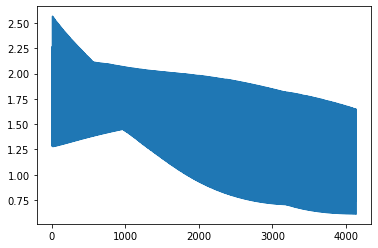

In [1285]:
plt.plot(sandbox_losses_per_bunch)

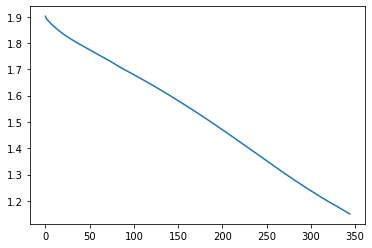

In [1286]:
plt.plot(sandbox_losses_per_epoch)

### Many Context Words<a id="experiments-many-words"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [1480]:
def target_many_context_tuples(corpus, window):
    for text in corpus:
        for i, word in enumerate(text):
            context_words = [
                text[j] for j in range(max(0,i-window), min(i+window+1, len(text)))
                if j != i
            ]
            
            # TODO!!!! pad value not UNK
            if len(context_words) < 2 * window:
                context_words += [0] * (2 * window - len(context_words))
            
            yield (word, context_words)

In [1481]:
def target_many_context_tensors(document_word_indices, window):
    for target, context in target_many_context_tuples(
            document_word_indices.values(), window):

        target_tensor = autograd.Variable(torch.LongTensor([target]))
        context_tensor = autograd.Variable(torch.LongTensor([context]))

        yield (target_tensor, context_tensor)

In [1291]:
sandbox_context_tensors = list(target_many_context_tensors(
    SANDBOX_DOCUMENT_WORD_INDICES, 1
))

print(len(sandbox_context_tensors))

6


In [1293]:
SANDBOX_NUM_INPUTS_TO_COMPUTE_SCORE = 2
SANDBOX_EMBEDDING_SIZE = 2

In [1325]:
sandbox_model = CbowManyContextWordsModel(
    embedding_size=SANDBOX_EMBEDDING_SIZE,
    vocab_size=len(SANDBOX_VOCABULARY),
    context_size=2 * WINDOW
)

In [1326]:
attach_scores(
    sandbox_model,
    SANDBOX_WORD_SIMILARITIES,
    SANDBOX_WORD_INDICES,
    SANDBOX_DOCUMENT_SIMILARITIES,
    SANDBOX_DOCUMENT_WORD_INDICES,
    SANDBOX_DOCUMENT_INDICES,
    holdout_document_similarities=None,
    holdout_document_words=None,
    holdout_documents_to_score=None,
    nums_most_similar=[10, 100]
)

In [1327]:
trainer = SoftmaxModelTrainer(
    num_data_bunches_to_compute_scores=1,
    max_num_epochs=1000,
    device=DEVICE,
    verbose=False
)

In [1328]:
sandbox_context_tensors_generator = lambda: target_many_context_tensors(
    SANDBOX_DOCUMENT_WORD_INDICES, WINDOW
)

In [1329]:
sandbox_model, sandbox_losses_per_epoch, sandbox_losses_per_bunch = (
    trainer.train(
        sandbox_model,
        sandbox_context_tensors_generator,
        'SandboxModel'
    )
)

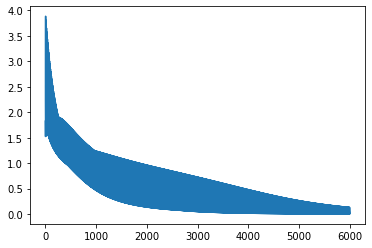

In [1330]:
plt.plot(sandbox_losses_per_bunch)

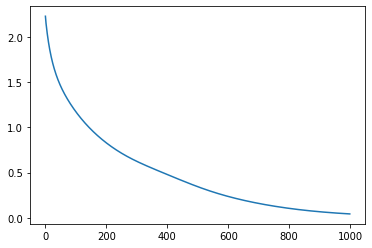

In [1331]:
plt.plot(sandbox_losses_per_epoch)

### One Context Word + Batches<a id="experiments-one-word-plus-batches"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [1484]:
def one_context_batches(target_context_pairs, batch_size=100):
    batch_target, batch_context = [], []
    
    for i, (one_target_tensor, one_context_tensor) in enumerate(target_context_pairs):
        
        batch_target.append(one_target_tensor)
        batch_context.append(one_context_tensor)

        if (i + 1) % batch_size == 0:
            target_tensor = torch.cat(batch_target)
            context_tensor = torch.cat(batch_context)
            
            yield target_tensor, context_tensor

            batch_target, batch_context = [], []
    
    if len(batch_target) > 0:
        target_tensor = torch.cat(batch_target)
        context_tensor = torch.cat(batch_context)

        yield target_tensor, context_tensor

In [1333]:
sandbox_context_tensors = list(one_context_batches(target_one_context_tensors(
    SANDBOX_DOCUMENT_WORD_INDICES, WINDOW
)))

print(len(sandbox_context_tensors))

1


In [1377]:
sandbox_model = CbowOneContextWordModel(
    embedding_size=SANDBOX_EMBEDDING_SIZE,
    vocab_size=len(SANDBOX_VOCABULARY)
)

In [1378]:
attach_scores(
    sandbox_model,
    SANDBOX_WORD_SIMILARITIES,
    SANDBOX_WORD_INDICES,
    SANDBOX_DOCUMENT_SIMILARITIES,
    SANDBOX_DOCUMENT_WORD_INDICES,
    SANDBOX_DOCUMENT_INDICES,
    holdout_document_similarities=None,
    holdout_document_words=None,
    holdout_documents_to_score=None,
    nums_most_similar=[10, 100]
)

In [1379]:
trainer = SoftmaxModelTrainer(
    num_data_bunches_to_compute_scores=1,
    max_num_epochs=1000,
    device=DEVICE,
    verbose=False
)

In [1380]:
sandbox_context_tensors_generator = lambda: one_context_batches(
    target_one_context_tensors(
        SANDBOX_DOCUMENT_WORD_INDICES, WINDOW
    ),
    batch_size=2
)

In [1381]:
sandbox_model, sandbox_losses_per_epoch, sandbox_losses_per_bunch = (
    trainer.train(
        sandbox_model,
        sandbox_context_tensors_generator,
        'SandboxModel'
    )
)

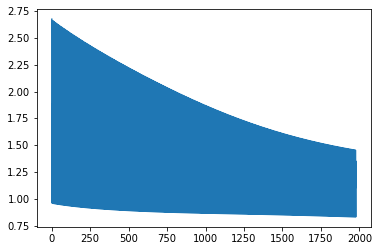

In [1382]:
plt.plot(sandbox_losses_per_bunch)

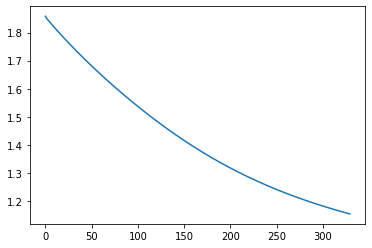

In [1383]:
plt.plot(sandbox_losses_per_epoch)

### Many Context Words + Batches<a id="experiments-many-words-plus-batches"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [945]:
def many_context_batches(target_context_pairs, batch_size=100):
    yield from one_context_batches(target_context_pairs, batch_size)

In [1412]:
sandbox_model = CbowManyContextWordsModel(
    embedding_size=SANDBOX_EMBEDDING_SIZE,
    vocab_size=len(SANDBOX_VOCABULARY),
    context_size=2 * WINDOW
)

In [1413]:
attach_scores(
    sandbox_model,
    SANDBOX_WORD_SIMILARITIES,
    SANDBOX_WORD_INDICES,
    SANDBOX_DOCUMENT_SIMILARITIES,
    SANDBOX_DOCUMENT_WORD_INDICES,
    SANDBOX_DOCUMENT_INDICES,
    holdout_document_similarities=None,
    holdout_document_words=None,
    holdout_documents_to_score=None,
    nums_most_similar=[10, 100]
)

In [1414]:
trainer = SoftmaxModelTrainer(
    num_data_bunches_to_compute_scores=1,
    max_num_epochs=1000,
    device=DEVICE,
    verbose=False
)

In [1473]:
sandbox_context_tensors_generator = lambda: many_context_batches(
    target_many_context_tensors(
        SANDBOX_DOCUMENT_WORD_INDICES, WINDOW
    ),
    batch_size=2
)

In [1416]:
sandbox_model, sandbox_losses_per_epoch, sandbox_losses_per_bunch = (
    trainer.train(
        sandbox_model,
        sandbox_context_tensors_generator,
        'SandboxModel'
    )
)

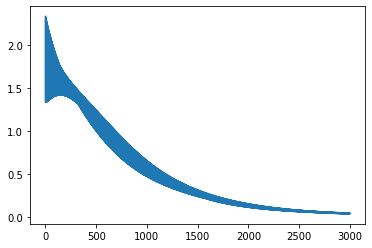

In [1417]:
plt.plot(sandbox_losses_per_bunch)

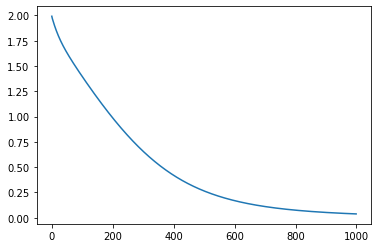

In [1418]:
plt.plot(sandbox_losses_per_epoch)

## Models. Part 2: Negative Sampling <a id="models-pt2"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

* https://datascience.stackexchange.com/questions/13216/intuitive-explanation-of-noise-contrastive-estimation-nce-loss
* https://cs224d.stanford.edu/lecture_notes/notes1.pdf
* https://towardsdatascience.com/nlp-101-negative-sampling-and-glove-936c88f3bc68
* https://stats.stackexchange.com/questions/244616/how-does-negative-sampling-work-in-word2vec?newreg=30d6d9385fe8452b88dfc5477c7e0159

In [1077]:
def sample_negative(sample_size, texts):
    sample_probability = {}
    word_counts = dict(Counter(list(itertools.chain.from_iterable(texts))))
    normalizing_factor = sum([v**0.75 for v in word_counts.values()])

    for word in word_counts:
        sample_probability[word] = word_counts[word]**0.75 / normalizing_factor
    
    words = np.array(list(word_counts.keys()))
    
    while True:
        word_list = []
        sampled_index = np.array(multinomial(sample_size, list(sample_probability.values())))

        for index, count in enumerate(sampled_index):
            for _ in range(count):
                 word_list.append(words[index])
        
        yield word_list

In [ ]:
class BaseWord2VecNegativeSamplingModel(BaseWord2VecModel):
    def __init__(self, embedding_size, vocab_size):
        super().__init__()
        
        # TODO: device
        self.target_embeddings = nn.Embedding(vocab_size, embedding_size).to(DEVICE)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_size).to(DEVICE)

    def forward(self, *args, **kwargs):
        raise NotImplementedError()

    def predict(self, words):
        return self.target_embeddings(words) # TODO: other also possible?
    
    @property
    def embedding_matrix(self):
        _s = torch.LongTensor(
            list(range(0, self.target_embeddings.num_embeddings))
        ).to(DEVICE)  # TODO
        
        return self.target_embeddings(_s).to(DEVICE)  # TODO

### SkipGramNegativeSamplingModel <a id="sg-neg-sampling-model"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [1155]:
class SkipGramNegativeSamplingModel(BaseWord2VecNegativeSamplingModel):
    def __init__(self, embedding_size, vocab_size):
        super().__init__(embedding_size, vocab_size)
        
        self.log_sigmoid = nn.LogSigmoid()

    def forward(self, target_input, context, neg):
        """
        Parameters
        ----------
            target_input: [batch_size]
            context:      [batch_size]
            neg:          [batch_size, neg_size]
        """
        # u, v: [batch_size, emb_dim]
        v = self.target_embeddings(target_input)
        u = self.context_embeddings(context)
        
        # positive_val: [batch_size]
        positive_val = self.log_sigmoid(torch.sum(u * v, dim=1)).squeeze()

        # u_hat: [batch_size, neg_size, emb_dim]
        u_hat = self.context_embeddings(neg)
        
        if u_hat.dim() < 3:
            u_hat = u_hat.unsqueeze(0)
        
        # [batch_size, neg_size, emb_dim] x [batch_size, emb_dim, 1] = [batch_size, neg_size, 1]
        # neg_vals: [batch_size, neg_size]
        neg_vals = torch.bmm(u_hat, v.unsqueeze(2)).squeeze(2)
        
        # neg_val: [batch_size]
        neg_val = self.log_sigmoid(-torch.sum(neg_vals, dim=1)).squeeze()

        loss = positive_val + neg_val
        
        return -loss.mean()

In [1218]:
class NegativeSamplingModelTrainer(BaseModelTrainer):
    def __init__(
            self,
            num_data_bunches_to_save=100,
            num_data_bunches_to_compute_scores=100,
            num_data_bunches_to_log=100,
            max_num_epochs=10,
            device=None,
            verbose=False):
        
        super().__init__(
            num_data_bunches_to_save,
            num_data_bunches_to_compute_scores,
            num_data_bunches_to_log,
            max_num_epochs,
            device,
            verbose
        )
        
    def _forward(self, model, data_bunch):
        target_tensor, context_tensor, negative_tensor = data_bunch

        target_tensor = target_tensor.to(self._device)  # TODO: fix device in SoftmaxTrainer
        context_tensor = context_tensor.to(self._device)
        negative_tensor = negative_tensor.to(self._device)
        
        loss = model(target_tensor, context_tensor, negative_tensor)

        return loss

## Experiments. Part 2: Negative Sampling <a id="experiments-pt2"></a>

### One Context Word<a id="experiments-one-word-pt2"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [1002]:
def target_one_context_one_negative_tuples(corpus, window):
    negative_samples = sample_negative(2 * window, corpus)

    for text in corpus:
        for i, word in enumerate(text):
            first_context_word_index = max(0,i-window)
            last_context_word_index = min(i+window, len(text))

            for j in range(first_context_word_index, last_context_word_index):
                if i!=j:
                    yield (word, text[j], next(negative_samples))

In [1003]:
def target_one_context_many_negative_tensors(document_word_indices, window):
    for target, context, negatives in target_one_context_one_negative_tuples(
            document_word_indices.values(), window):

        target_tensor = autograd.Variable(torch.LongTensor([target]))
        context_tensor = autograd.Variable(torch.LongTensor([context]))
        negative_tensor = autograd.Variable(torch.LongTensor(negatives))  # TODO: Variable?

        yield (target_tensor, context_tensor, negative_tensor)

In [1184]:
sandbox_model = SkipGramNegativeSamplingModel(
    embedding_size=SANDBOX_EMBEDDING_SIZE,
    vocab_size=len(SANDBOX_VOCABULARY)
)

In [1185]:
attach_scores(
    sandbox_model,
    SANDBOX_WORD_SIMILARITIES,
    SANDBOX_WORD_INDICES,
    SANDBOX_DOCUMENT_SIMILARITIES,
    SANDBOX_DOCUMENT_WORD_INDICES,
    SANDBOX_DOCUMENT_INDICES,
    holdout_document_similarities=None,
    holdout_document_words=None,
    holdout_documents_to_score=None,
    nums_most_similar=[10, 100]
)

In [1186]:
trainer = NegativeSamplingModelTrainer(
    num_data_bunches_to_compute_scores=1,
    max_num_epochs=1000,
    device=DEVICE,
    verbose=False
)

In [1187]:
sandbox_context_tensors_generator = lambda: target_one_context_many_negative_tensors(
    SANDBOX_DOCUMENT_WORD_INDICES, WINDOW
)

In [1188]:
sandbox_model, sandbox_losses_per_epoch, sandbox_losses_per_bunch = (
    trainer.train(
        sandbox_model,
        sandbox_context_tensors_generator,
        'SandboxModel'
    )
)

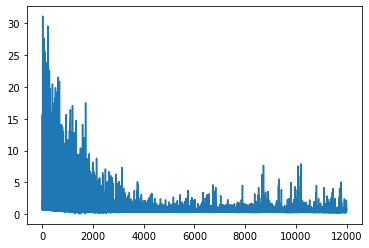

In [1189]:
plt.plot(sandbox_losses_per_bunch)

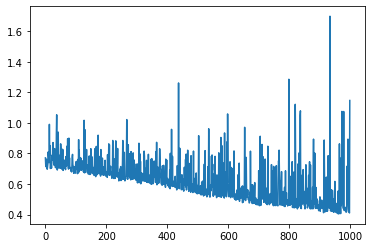

In [1169]:
plt.plot(sandbox_losses_per_epoch)

### One Context Word + Batches<a id="experiments-one-word-plus-batches-pt2"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [1076]:
def one_context_many_negative_batches(target_context_negative_triples, batch_size=100):
    batch_target, batch_context, batch_negative = [], [], []
    
    for i, (one_target_tensor, one_context_tensor, one_negative_tensors) in enumerate(target_context_negative_triples):
        batch_target.append(one_target_tensor)
        batch_context.append(one_context_tensor)
        batch_negative.append(one_negative_tensors)
        
        if (i + 1) % batch_size == 0:
            target_tensor = torch.cat(batch_target)
            context_tensor = torch.cat(batch_context)
            negative_tensor = torch.cat(batch_negative).view((len(batch_negative), -1))
            
            yield target_tensor, context_tensor, negative_tensor

            batch_target, batch_context, batch_negative = [], [], []
    
    if len(batch_target) > 0:
        target_tensor = torch.cat(batch_target)
        context_tensor = torch.cat(batch_context)
        negative_tensor = torch.cat(batch_negative)

        yield target_tensor, context_tensor, negative_tensor

In [1157]:
sandbox_model = SkipGramNegativeSamplingModel(
    embedding_size=SANDBOX_EMBEDDING_SIZE,
    vocab_size=len(SANDBOX_VOCABULARY)
)

In [1158]:
attach_scores(
    sandbox_model,
    SANDBOX_WORD_SIMILARITIES, 
    SANDBOX_WORD_INDICES,
    SANDBOX_DOCUMENT_SIMILARITIES,
    SANDBOX_DOCUMENT_WORD_INDICES,
    SANDBOX_DOCUMENT_INDICES,
    holdout_document_similarities=None,
    holdout_document_words=None,
    holdout_documents_to_score=None,
    nums_most_similar=[10, 100]
)

In [1159]:
trainer = NegativeSamplingModelTrainer(
    num_data_bunches_to_compute_scores=1,
    max_num_epochs=1000,
    device=DEVICE,
    verbose=False
)

In [1170]:
sandbox_context_tensors_generator = lambda: one_context_many_negative_batches(
    target_one_context_many_negative_tensors(
        SANDBOX_DOCUMENT_WORD_INDICES, WINDOW
    ),
    batch_size=2
)

In [1167]:
sandbox_model, sandbox_losses_per_epoch, sandbox_losses_per_bunch = (
    trainer.train(
        sandbox_model,
        sandbox_context_tensors_generator,
        'SandboxModel'
    )
)

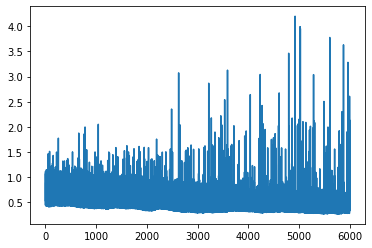

In [1168]:
plt.plot(sandbox_losses_per_bunch)

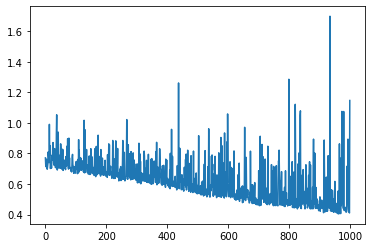

In [1169]:
plt.plot(sandbox_losses_per_epoch)

## ~~Thorough, High-Quality and Comprehensive~~ Some Comparison of Models, Some Error Analysis, and Hyperparameters Kinda Like Tuning<a id="finale"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [1421]:
context_tensors = list(one_context_batches(
        target_one_context_tensors(
        TRAIN_DOCUMENT_WORD_INDICES, WINDOW
    ),
    batch_size=64 # TODO: const
))

print(len(context_tensors))

13869


In [1436]:
EMBEDDING_SIZE = 100

### Comparison of Models<a id="finale-comparison"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Output after models training is removed to make the notebook smaller in size

In [1555]:
model = CbowOneContextWordModel(
    embedding_size=EMBEDDING_SIZE,
    vocab_size=len(VOCABULARY)
)

In [1556]:
attach_scores(
    model,
    WORD_SIMILARITIES,
    WORD_INDICES_SAMPLE,
    TRAIN_DOCUMENT_SIMILARITIES,
    TRAIN_DOCUMENT_WORD_INDICES,
    TRAIN_DOCUMENT_INDICES_SAMPLE,
    holdout_document_similarities=TEST_DOCUMENT_SIMILARITIES,
    holdout_document_words=TEST_DOCUMENT_WORD_INDICES,
    holdout_documents_to_score=TEST_DOCUMENTS_INDICES_SAMPLE,
    nums_most_similar=[10, 100]
)

In [1557]:
context_tensors_generator = lambda: one_context_batches(
    target_one_context_tensors(
        TRAIN_DOCUMENT_WORD_INDICES, WINDOW
    ),
    batch_size=BATCH_SIZE
)

In [1558]:
trainer = SoftmaxModelTrainer(
    num_data_bunches_to_compute_scores=1000,
    max_num_epochs=MAX_NUM_EPOCHS,
    device=DEVICE,
    verbose=True
)

In [ ]:
model, losses_per_epoch, losses_per_bunch = (
    trainer.train(
        model,
        context_tensors_generator,
        'CbowOneContextWord'
    )
)

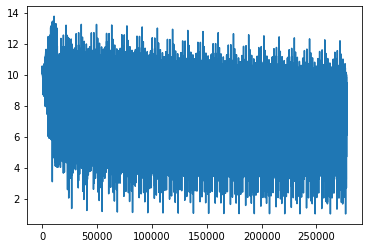

In [1571]:
plt.plot(losses_per_bunch)
plt.show()

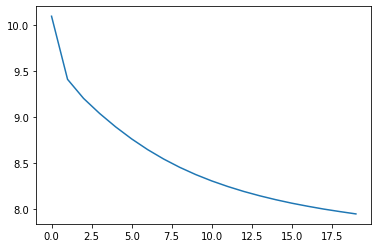

In [1572]:
plt.plot(losses_per_epoch)
plt.show()

Let's define a function which draws all model scores

In [1647]:
def draw_plots(model, num_cols=3, font_size=10, scores_to_show=None):
    old_font_size = plt.rcParams['font.size']
    plt.rcParams.update({'font.size': font_size})
    
    scores = model.score_names
    
    if scores_to_show is None:
        scores_to_show = scores
    
    not_found_scores = list(set(scores_to_show).difference(set(scores)))
    
    if len(not_found_scores) > 0:
        warnings.warn(
            f'Some wanted scores not found in model!'
            f' Here are these scores \"{not_found_scores}\"'
        )
    
    num_rows = int(np.ceil(len(scores) / num_cols))

    one_plot_width = 5
    one_plot_heigth = 7
    
    fig, axes = plt.subplots(
        num_rows, num_cols,
        figsize=(num_cols * one_plot_heigth, num_rows * one_plot_width)
    )
    
    for i, score in enumerate(scores):
        ax = axes[i // num_cols][i % num_cols]
        
        ax.plot(model.get_score_values(score), lw=4, marker='.', ms=15)
        
        ax.set_title(score)
        
        if 'bunch' in score:
            ax.set_xlabel('Bunch')
        elif 'epoch' in score:
            ax.set_xlabel('Epoch')
        else:
            ax.set_xlabel('')

    plt.subplots_adjust(
        hspace=0.25, wspace=0.25
    )
    plt.show()
    
    plt.rcParams.update({'font.size': old_font_size})

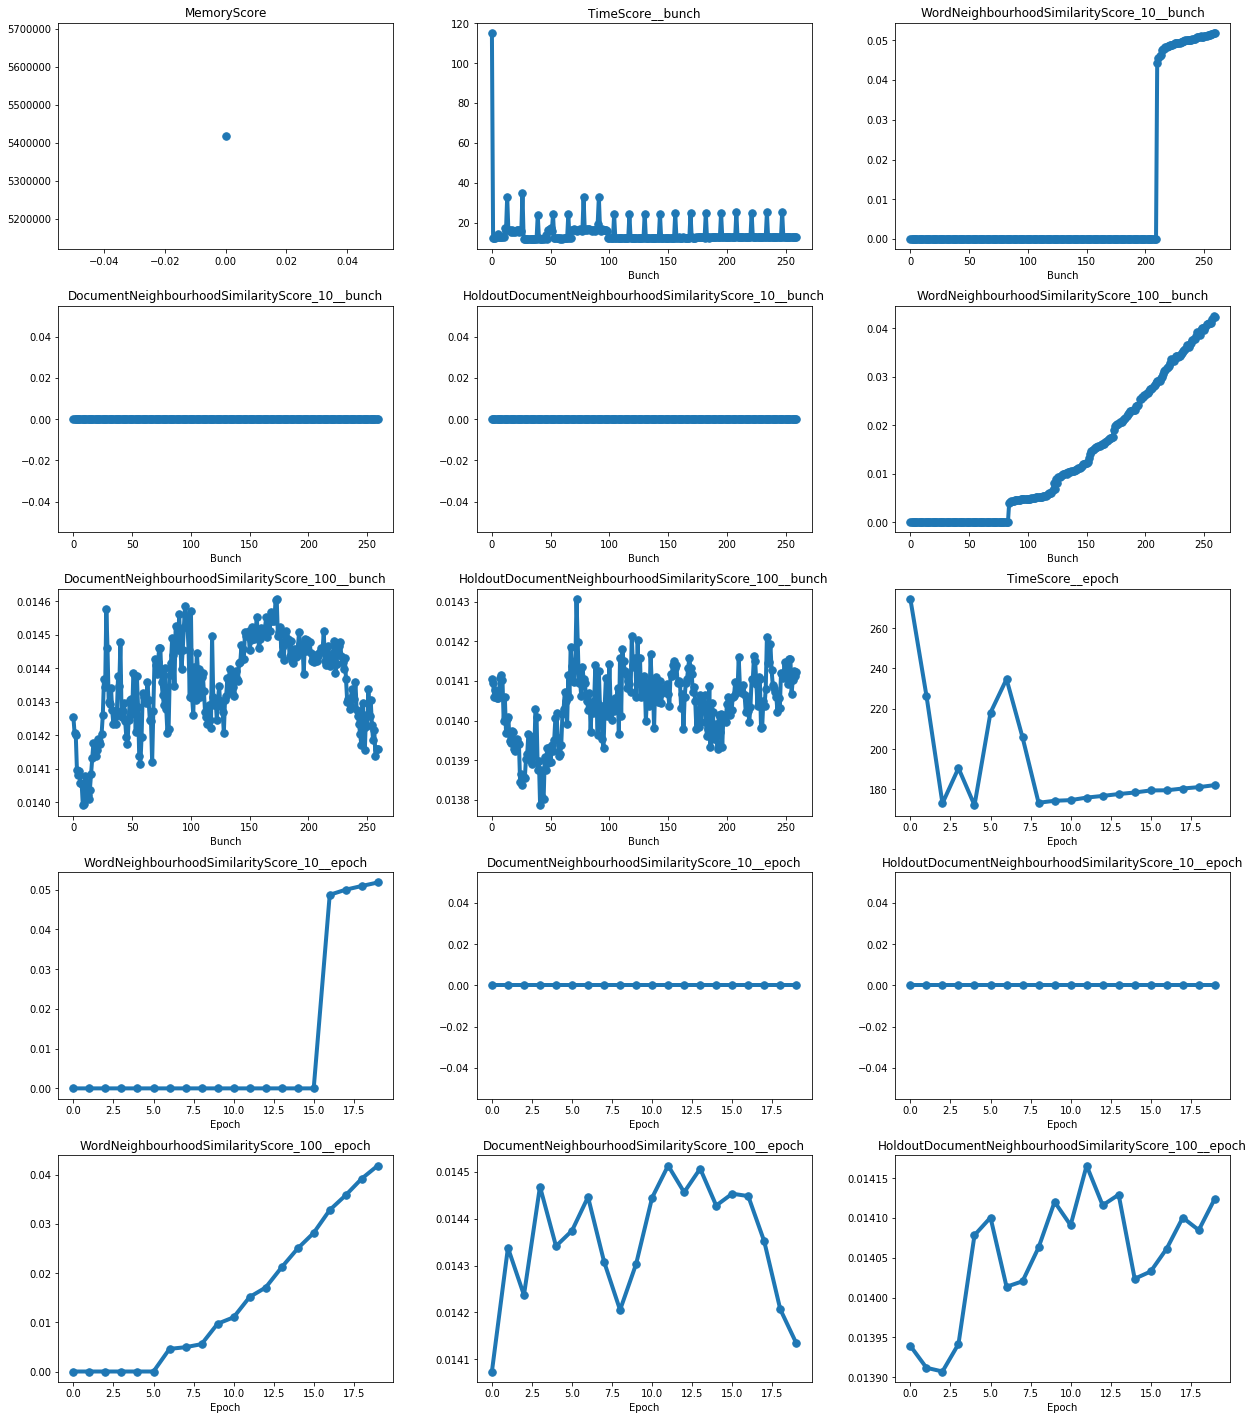

In [1565]:
draw_plots(model)

In [1573]:
model = SkipGramOneContextWordModel(
    embedding_size=EMBEDDING_SIZE,
    vocab_size=len(VOCABULARY)
)

In [1574]:
attach_scores(
    model,
    WORD_SIMILARITIES,
    WORD_INDICES_SAMPLE,
    TRAIN_DOCUMENT_SIMILARITIES,
    TRAIN_DOCUMENT_WORD_INDICES,
    TRAIN_DOCUMENT_INDICES_SAMPLE,
    holdout_document_similarities=TEST_DOCUMENT_SIMILARITIES,
    holdout_document_words=TEST_DOCUMENT_WORD_INDICES,
    holdout_documents_to_score=TEST_DOCUMENTS_INDICES_SAMPLE,
    nums_most_similar=[10, 100]
)

In [1575]:
context_tensors_generator = lambda: one_context_batches(
    target_one_context_tensors(
        TRAIN_DOCUMENT_WORD_INDICES, WINDOW
    ),
    batch_size=BATCH_SIZE
)

In [1576]:
trainer = SoftmaxModelTrainer(
    num_data_bunches_to_compute_scores=1000,
    max_num_epochs=MAX_NUM_EPOCHS,
    device=DEVICE,
    verbose=True
)

In [ ]:
model, losses_per_epoch, losses_per_bunch = (
    trainer.train(
        model,
        context_tensors_generator,
        'SkipGramOneContextWord'
    )
)

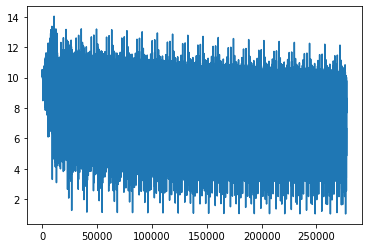

In [1578]:
plt.plot(losses_per_bunch)
plt.show()

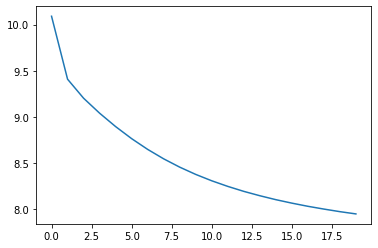

In [1579]:
plt.plot(losses_per_epoch)
plt.show()

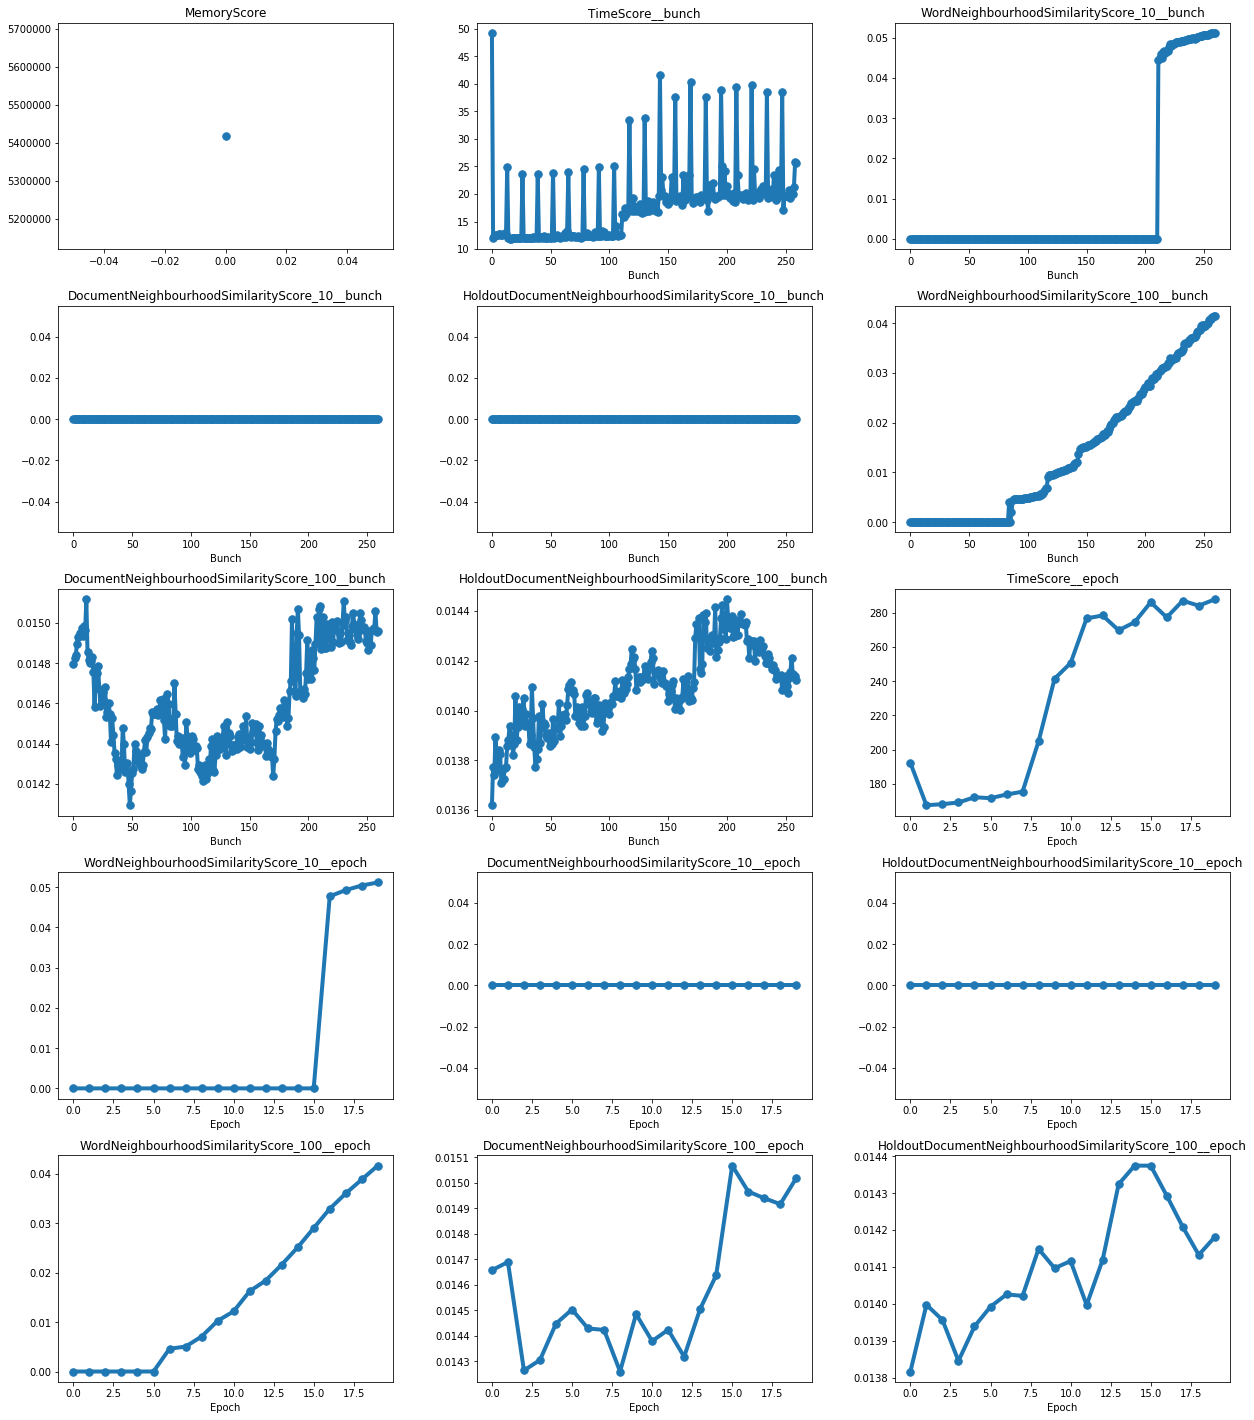

In [1580]:
draw_plots(model)

In [1542]:
EMBEDDING_SIZE

100

In [1543]:
WINDOW

4

In [1544]:
BATCH_SIZE = 64

In [1545]:
MAX_NUM_EPOCHS = 20

In [1546]:
cbow_model = CbowManyContextWordsModel(
    embedding_size=EMBEDDING_SIZE,
    vocab_size=len(VOCABULARY),
    context_size=2 * WINDOW
)

In [1547]:
attach_scores(
    cbow_model,
    WORD_SIMILARITIES,
    WORD_INDICES_SAMPLE,
    TRAIN_DOCUMENT_SIMILARITIES,
    TRAIN_DOCUMENT_WORD_INDICES,
    TRAIN_DOCUMENT_INDICES_SAMPLE,
    holdout_document_similarities=TEST_DOCUMENT_SIMILARITIES,
    holdout_document_words=TEST_DOCUMENT_WORD_INDICES,
    holdout_documents_to_score=TEST_DOCUMENTS_INDICES_SAMPLE,
    nums_most_similar=[10, 100]
)

In [1548]:
context_tensors_generator = lambda: many_context_batches(
    target_many_context_tensors(
        TRAIN_DOCUMENT_WORD_INDICES, WINDOW
    ),
    batch_size=BATCH_SIZE
)

In [1549]:
num_data_bunches = len(list(context_tensors_generator()))

print(num_data_bunches)

2262


In [1550]:
trainer = SoftmaxModelTrainer(
    num_data_bunches_to_compute_scores=num_data_bunches // 10,
    max_num_epochs=MAX_NUM_EPOCHS,
    device=DEVICE,
    verbose=True
)

In [ ]:
cbow_model, losses_per_epoch, losses_per_bunch = (
    trainer.train(
        cbow_model,
        context_tensors_generator,
        'CbowManyContextWords'
    )
)

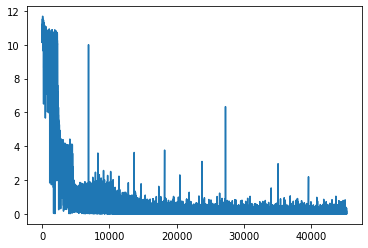

In [1559]:
plt.plot(losses_per_bunch)
plt.show()

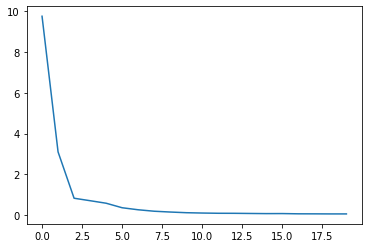

In [1560]:
plt.plot(losses_per_epoch)
plt.show()

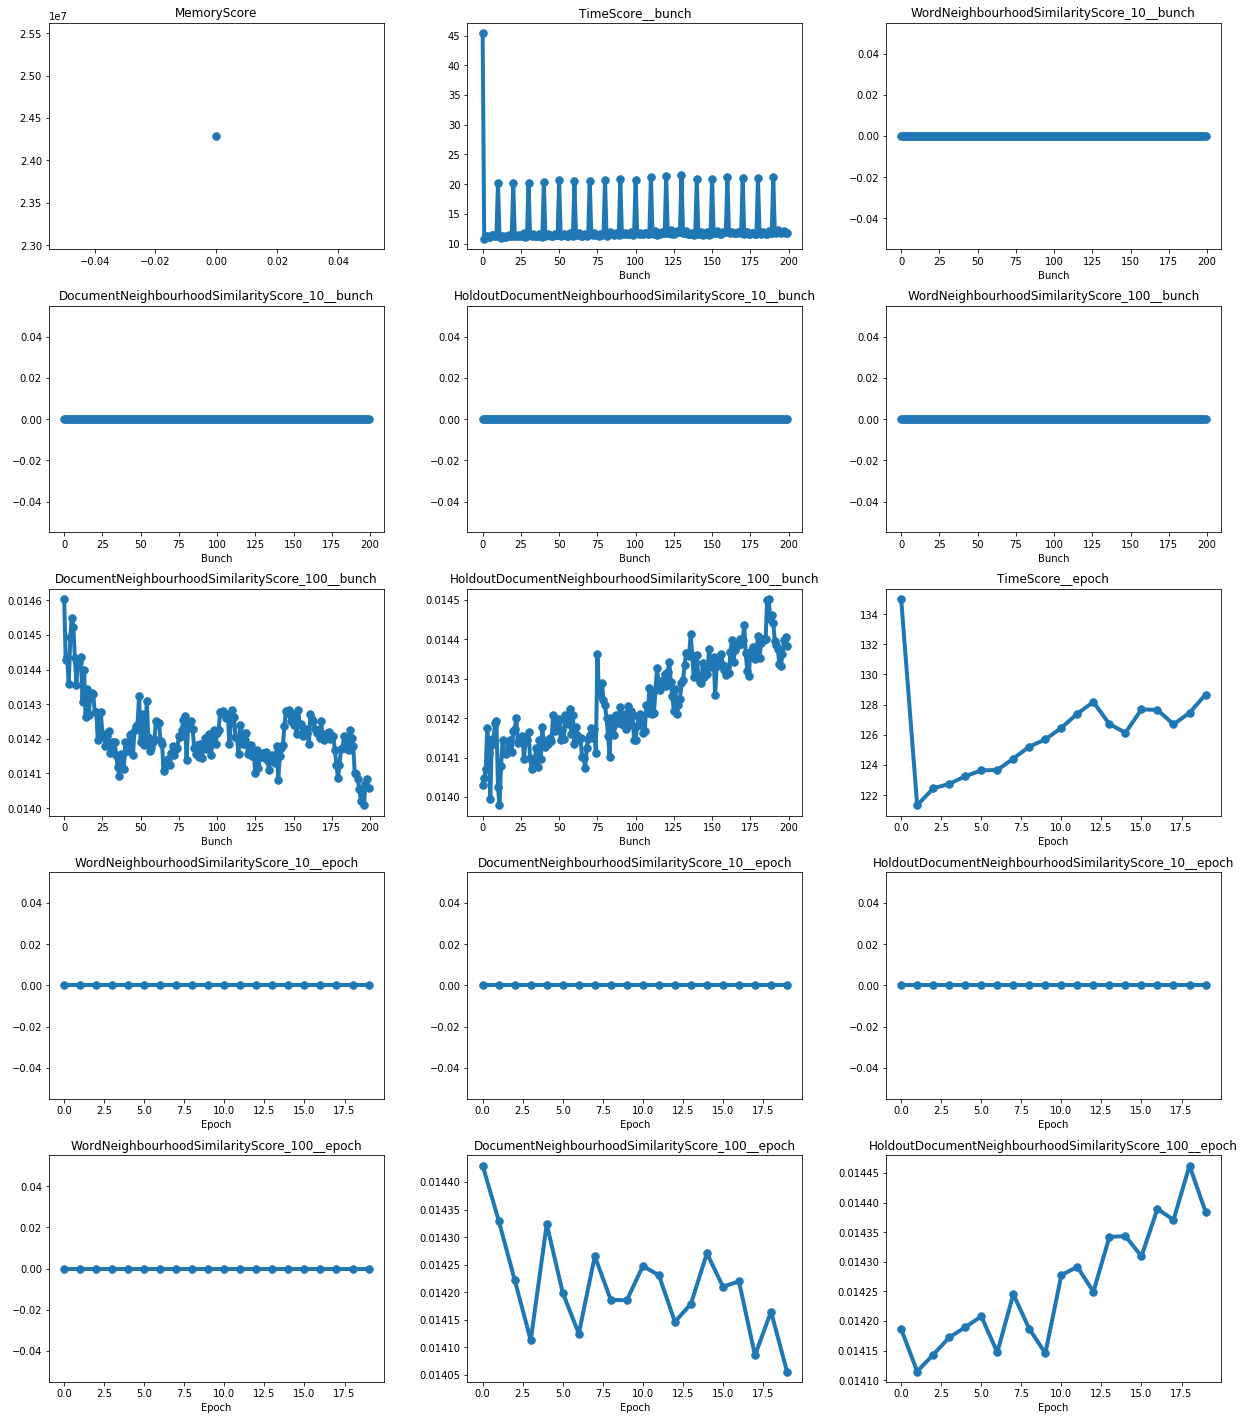

In [1554]:
draw_plots(cbow_model)

In [1581]:
model = SkipGramManyContextWordsModel(
    embedding_size=EMBEDDING_SIZE,
    vocab_size=len(VOCABULARY),
    context_size=2 * WINDOW
)

In [1582]:
attach_scores(
    model,
    WORD_SIMILARITIES,
    WORD_INDICES_SAMPLE,
    TRAIN_DOCUMENT_SIMILARITIES,
    TRAIN_DOCUMENT_WORD_INDICES,
    TRAIN_DOCUMENT_INDICES_SAMPLE,
    holdout_document_similarities=TEST_DOCUMENT_SIMILARITIES,
    holdout_document_words=TEST_DOCUMENT_WORD_INDICES,
    holdout_documents_to_score=TEST_DOCUMENTS_INDICES_SAMPLE,
    nums_most_similar=[10, 100]
)

In [1583]:
context_tensors_generator = lambda: many_context_batches(
    target_many_context_tensors(
        TRAIN_DOCUMENT_WORD_INDICES, WINDOW
    ),
    batch_size=BATCH_SIZE
)

In [1584]:
num_data_bunches = len(list(context_tensors_generator()))

print(num_data_bunches)

2262


In [1585]:
trainer = SoftmaxModelTrainer(
    num_data_bunches_to_compute_scores=num_data_bunches // 10,
    max_num_epochs=MAX_NUM_EPOCHS,
    device=DEVICE,
    verbose=True
)

In [ ]:
model, losses_per_epoch, losses_per_bunch = (
    trainer.train(
        model,
        context_tensors_generator,
        'SkipGramManyContextWords'
    )
)

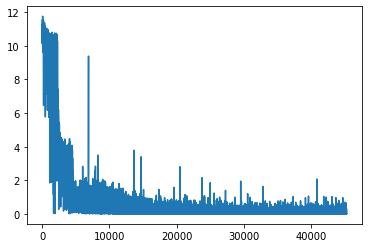

In [1587]:
plt.plot(losses_per_bunch)
plt.show()

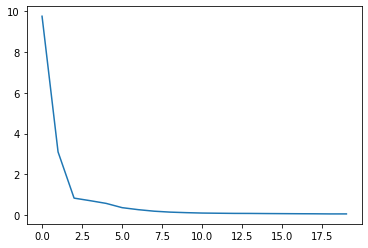

In [1588]:
plt.plot(losses_per_epoch)
plt.show()

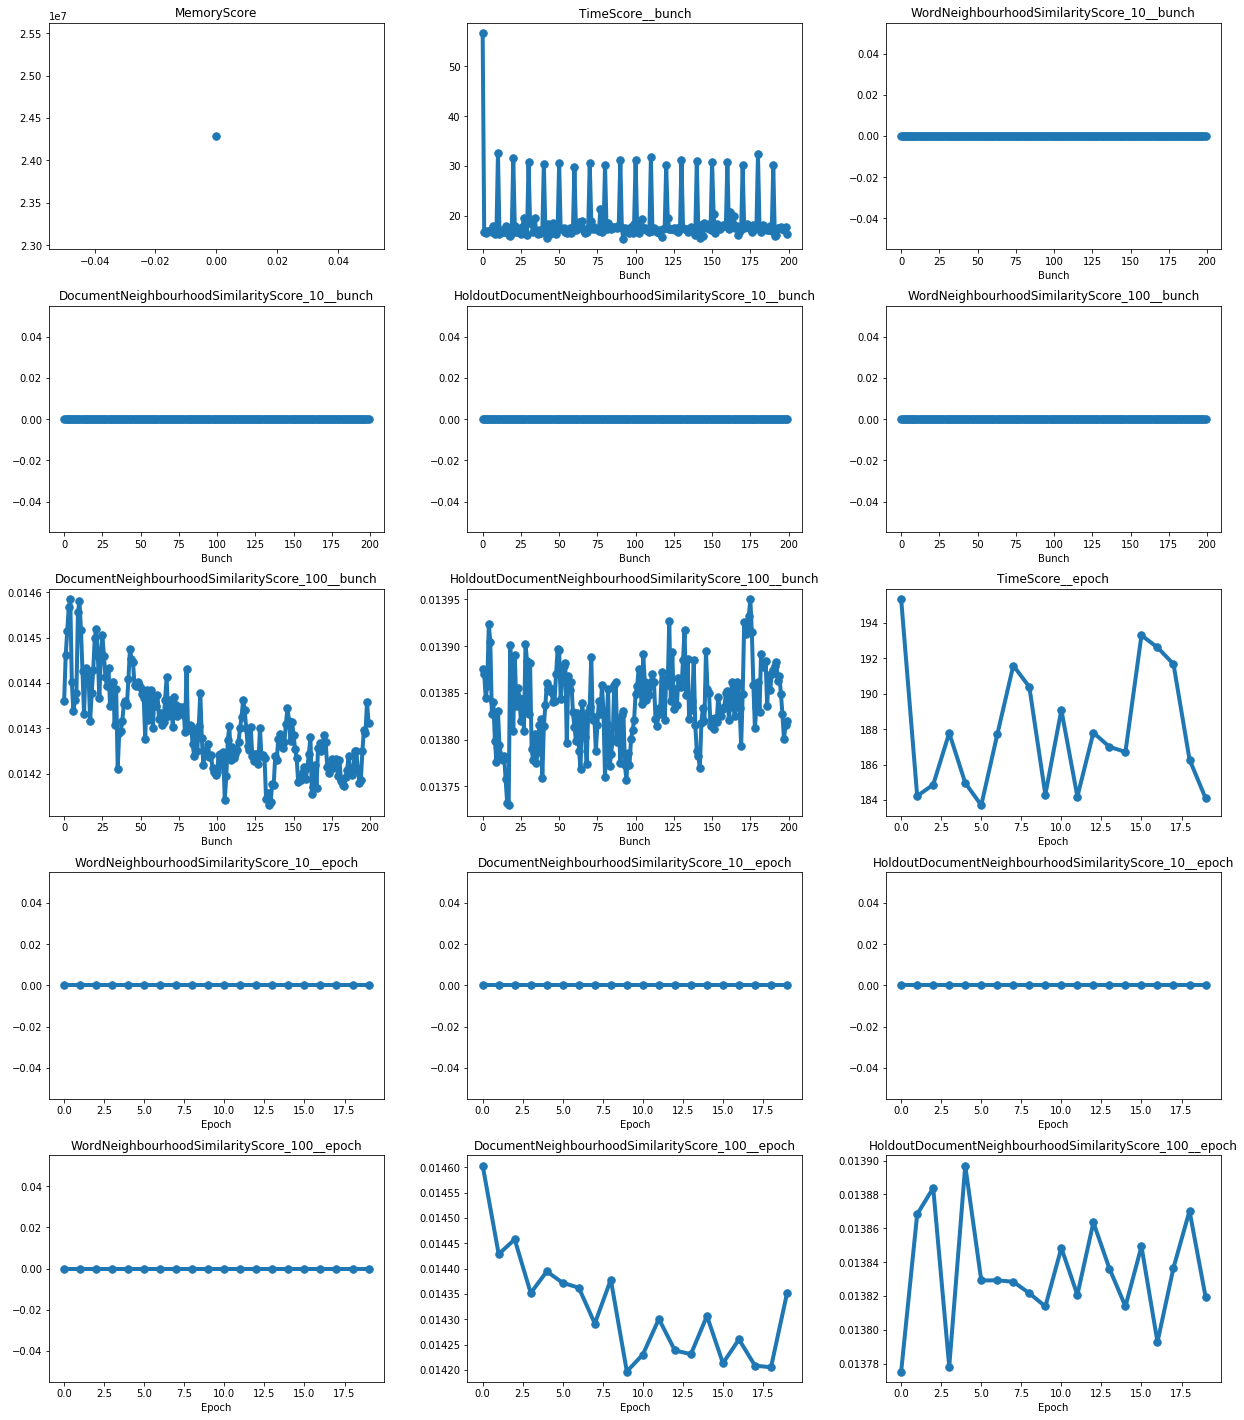

In [1590]:
draw_plots(model)

In [1591]:
model = DeepCbowManyContextWordsModel(
    embedding_size=EMBEDDING_SIZE,
    vocab_size=len(VOCABULARY),
    context_size=2 * WINDOW
)

In [1592]:
attach_scores(
    model,
    WORD_SIMILARITIES,
    WORD_INDICES_SAMPLE,
    TRAIN_DOCUMENT_SIMILARITIES,
    TRAIN_DOCUMENT_WORD_INDICES,
    TRAIN_DOCUMENT_INDICES_SAMPLE,
    holdout_document_similarities=TEST_DOCUMENT_SIMILARITIES,
    holdout_document_words=TEST_DOCUMENT_WORD_INDICES,
    holdout_documents_to_score=TEST_DOCUMENTS_INDICES_SAMPLE,
    nums_most_similar=[10, 100]
)

In [1593]:
context_tensors_generator = lambda: many_context_batches(
    target_many_context_tensors(
        TRAIN_DOCUMENT_WORD_INDICES, WINDOW
    ),
    batch_size=BATCH_SIZE
)

In [1594]:
num_data_bunches = len(list(context_tensors_generator()))

print(num_data_bunches)

2262


In [1550]:
trainer = SoftmaxModelTrainer(
    num_data_bunches_to_compute_scores=num_data_bunches // 10,
    max_num_epochs=MAX_NUM_EPOCHS,
    device=DEVICE,
    verbose=True
)

In [ ]:
model, losses_per_epoch, losses_per_bunch = (
    trainer.train(
        model,
        context_tensors_generator,
        'DeepCbowManyContextWords'
    )
)

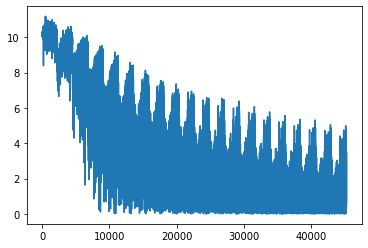

In [1596]:
plt.plot(losses_per_bunch)
plt.show()

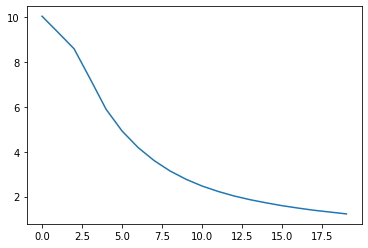

In [1597]:
plt.plot(losses_per_epoch)
plt.show()

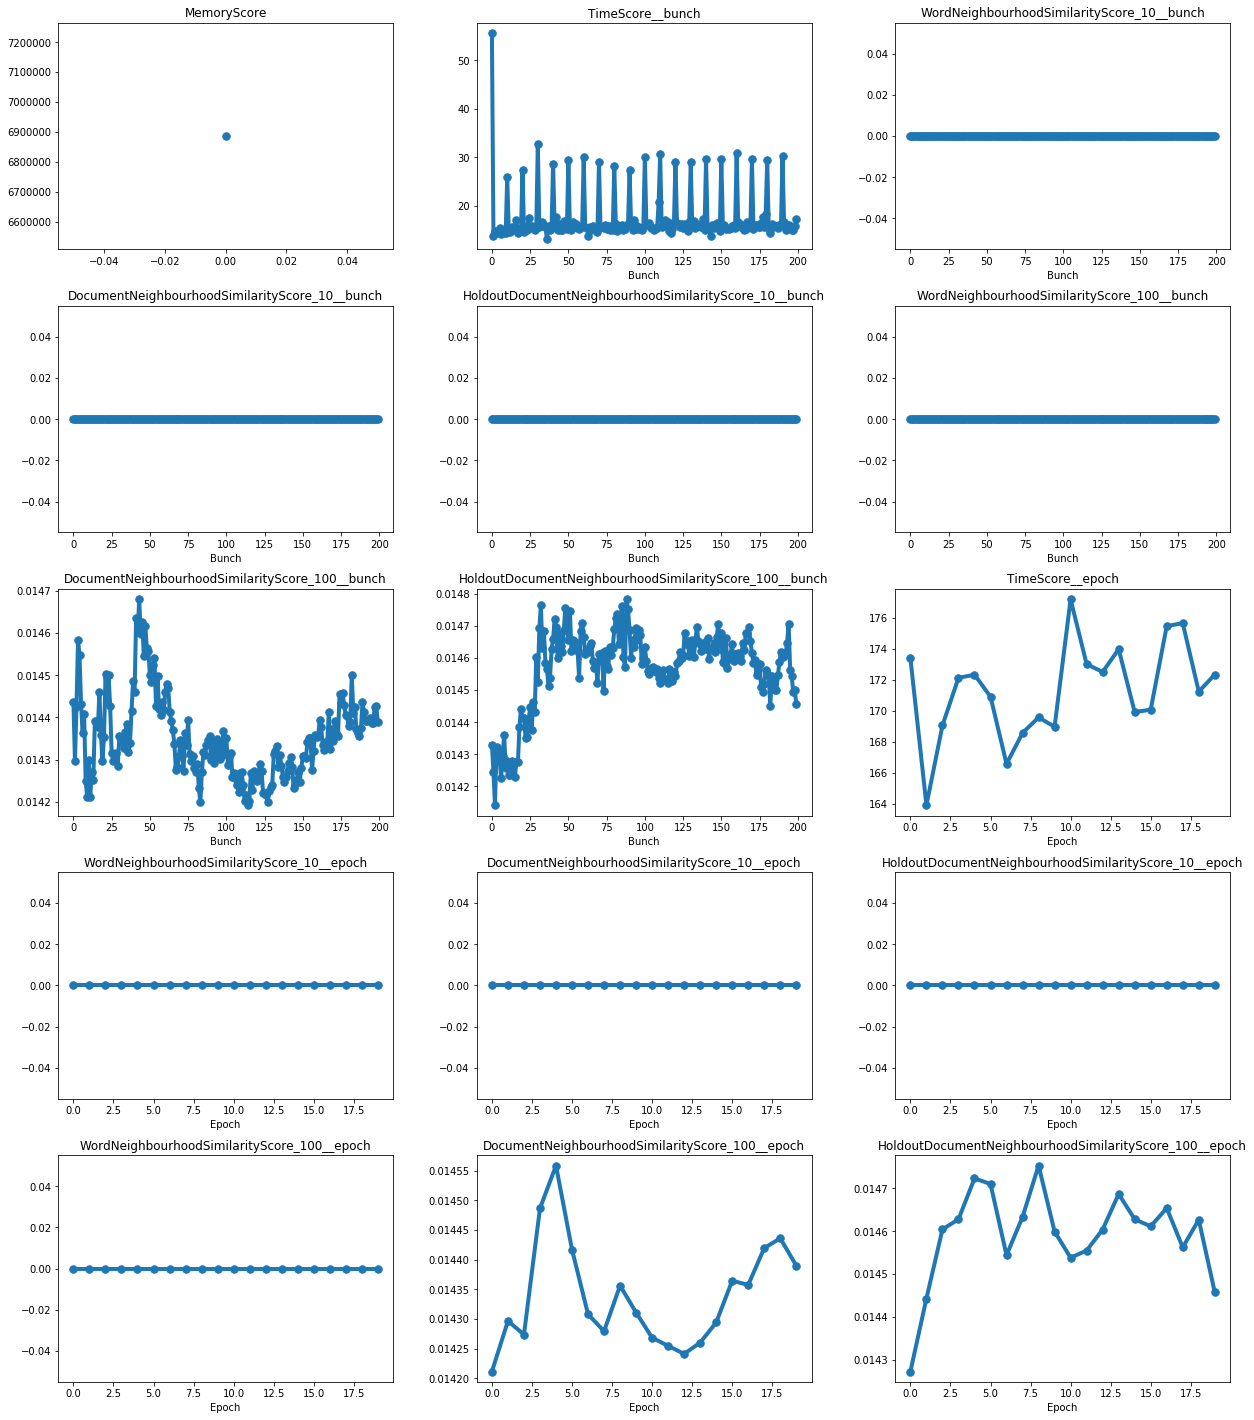

In [1599]:
draw_plots(model)

In [1600]:
model = DeepSkipGramManyContextWordsModel(
    embedding_size=EMBEDDING_SIZE,
    vocab_size=len(VOCABULARY),
    context_size=2 * WINDOW
)

In [1601]:
attach_scores(
    model,
    WORD_SIMILARITIES,
    WORD_INDICES_SAMPLE,
    TRAIN_DOCUMENT_SIMILARITIES,
    TRAIN_DOCUMENT_WORD_INDICES,
    TRAIN_DOCUMENT_INDICES_SAMPLE,
    holdout_document_similarities=TEST_DOCUMENT_SIMILARITIES,
    holdout_document_words=TEST_DOCUMENT_WORD_INDICES,
    holdout_documents_to_score=TEST_DOCUMENTS_INDICES_SAMPLE,
    nums_most_similar=[10, 100]
)

In [1602]:
context_tensors_generator = lambda: many_context_batches(
    target_many_context_tensors(
        TRAIN_DOCUMENT_WORD_INDICES, WINDOW
    ),
    batch_size=BATCH_SIZE
)

In [1603]:
num_data_bunches = len(list(context_tensors_generator()))

print(num_data_bunches)

2262


In [1604]:
trainer = SoftmaxModelTrainer(
    num_data_bunches_to_compute_scores=num_data_bunches // 10,
    max_num_epochs=MAX_NUM_EPOCHS,
    device=DEVICE,
    verbose=True
)

In [ ]:
model, losses_per_epoch, losses_per_bunch = (
    trainer.train(
        model,
        context_tensors_generator,
        'DeepSkipGramManyContextWords'
    )
)

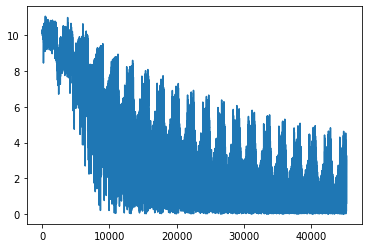

In [1606]:
plt.plot(losses_per_bunch)
plt.show()

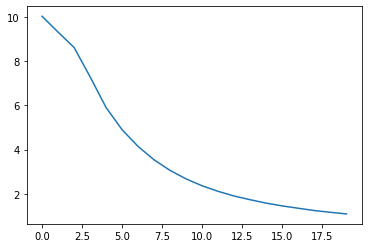

In [1607]:
plt.plot(losses_per_epoch)
plt.show()

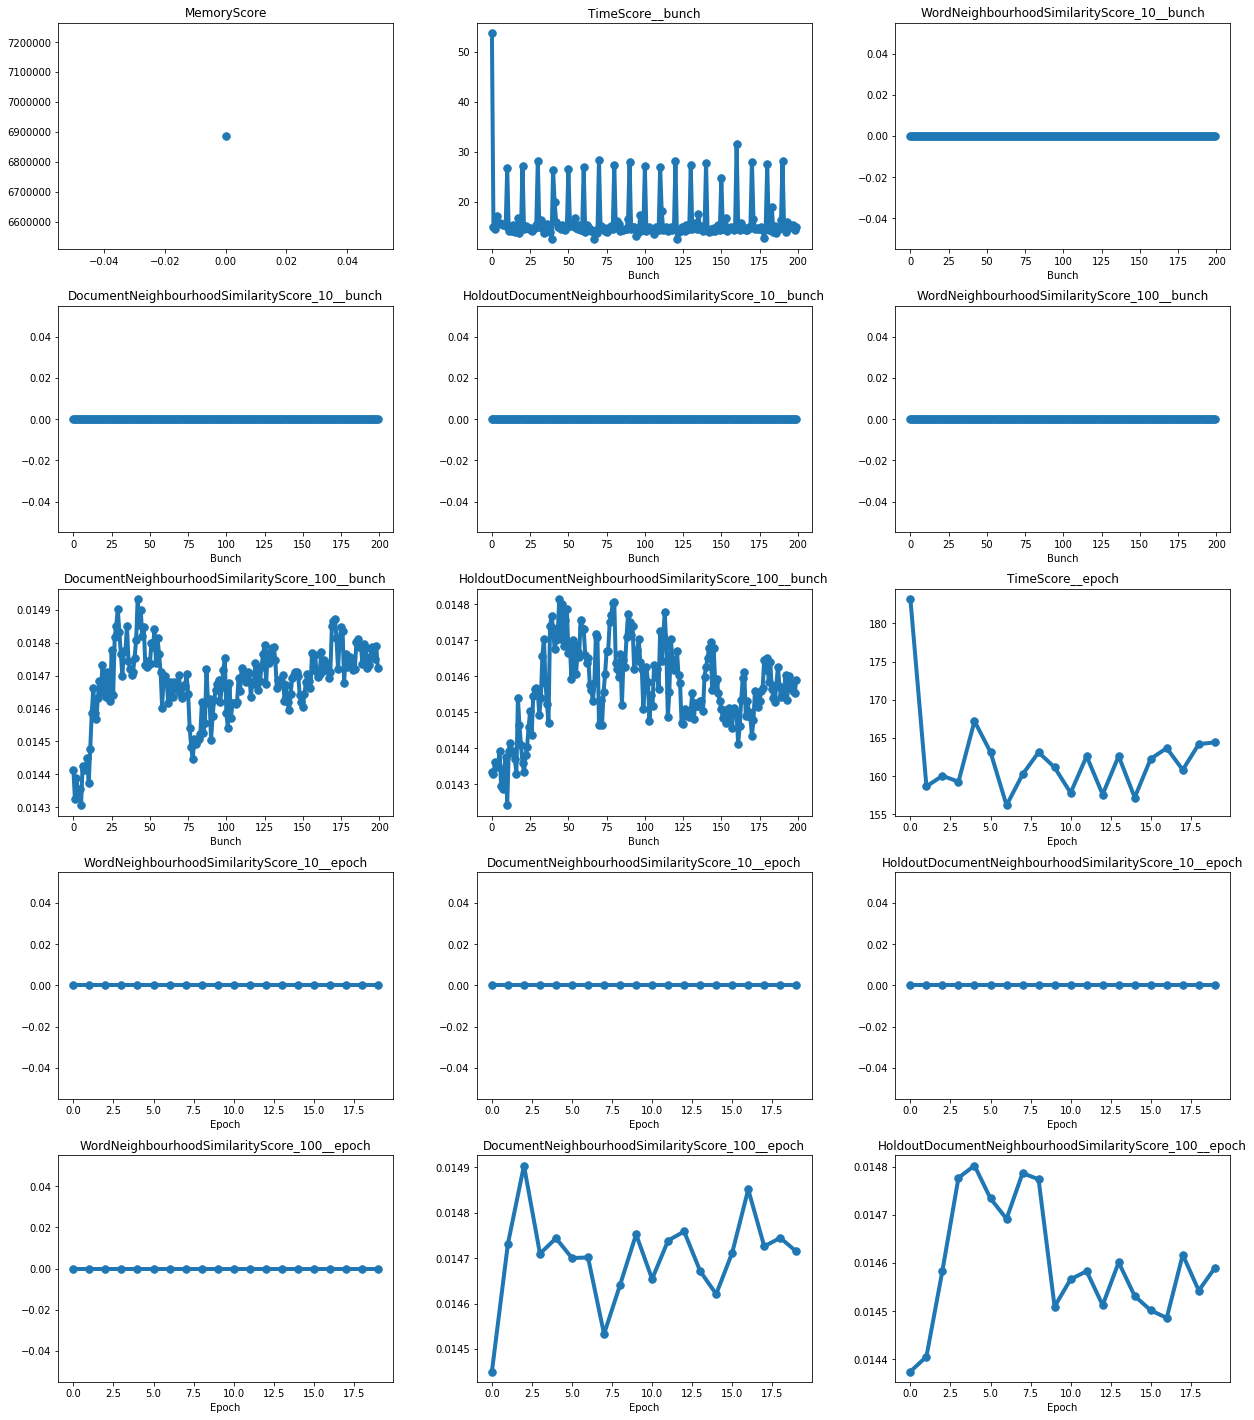

In [1608]:
draw_plots(model)

### Hyperparameters Tuning: Embedding Size<a id="finale-hyperparameters-embsize"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [1609]:
BEST_NUM_EPOCHS = 15
BEST_MODEL = SkipGramOneContextWord

In [1615]:
EMBEDDING_SIZES = [10, 50, 100, 200, 500]

In [1621]:
embsize_to_result = dict()

In [1622]:
for embedding_size in EMBEDDING_SIZES:
    logger.info(f'EMBEDDING SIZE: {embedding_size}')
    
    model = BEST_MODEL(
        embedding_size=embedding_size,
        vocab_size=len(VOCABULARY)
    )

    attach_scores(
        model,
        WORD_SIMILARITIES,
        WORD_INDICES_SAMPLE,
        TRAIN_DOCUMENT_SIMILARITIES,
        TRAIN_DOCUMENT_WORD_INDICES,
        TRAIN_DOCUMENT_INDICES_SAMPLE,
        holdout_document_similarities=TEST_DOCUMENT_SIMILARITIES,
        holdout_document_words=TEST_DOCUMENT_WORD_INDICES,
        holdout_documents_to_score=TEST_DOCUMENTS_INDICES_SAMPLE,
        nums_most_similar=[10, 100]
    )

    context_tensors_generator = lambda: one_context_batches(
        target_one_context_tensors(
            TRAIN_DOCUMENT_WORD_INDICES, WINDOW
        ),
        batch_size=BATCH_SIZE
    )

    trainer = SoftmaxModelTrainer(
        num_data_bunches_to_compute_scores=1000,
        max_num_epochs=BEST_NUM_EPOCHS,
        device=DEVICE,
        verbose=False
    )

    logger.info(f'Training model...')
    
    model, losses_per_epoch, losses_per_bunch = (
        trainer.train(
            model,
            context_tensors_generator,
            f'SkipGramOneContextWord__embsize_{embedding_size}'
        )
    )
    
    logger.info(f'Finished training!')
    
    embsize_to_result[embedding_size] = (model, losses_per_epoch, losses_per_bunch)

In [1643]:
embsize_to_result.keys()

dict_keys([10, 50, 100, 200, 500])

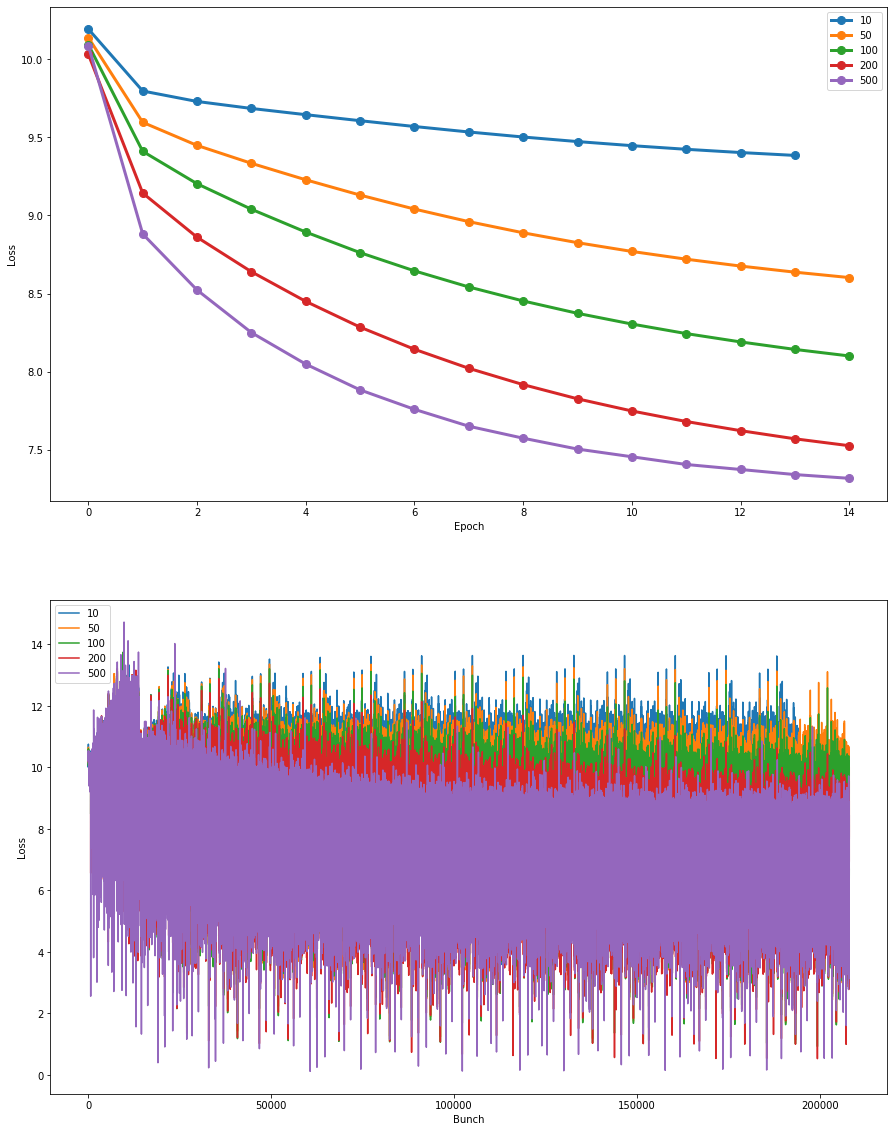

In [1680]:
fig, axes = plt.subplots(2, 1, figsize=(15, 2 * 10))

for embedding_size, result in embsize_to_result.items():
    axes[0].plot(result[1], label=embedding_size, lw=3, marker='.', ms=16)
    axes[1].plot(result[2], label=embedding_size)
    
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].set_xlabel('Bunch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()

In [1631]:
list(embsize_to_result.values())[0][0].score_names

['MemoryScore',
 'TimeScore__bunch',
 'WordNeighbourhoodSimilarityScore_10__bunch',
 'DocumentNeighbourhoodSimilarityScore_10__bunch',
 'HoldoutDocumentNeighbourhoodSimilarityScore_10__bunch',
 'WordNeighbourhoodSimilarityScore_100__bunch',
 'DocumentNeighbourhoodSimilarityScore_100__bunch',
 'HoldoutDocumentNeighbourhoodSimilarityScore_100__bunch',
 'TimeScore__epoch',
 'WordNeighbourhoodSimilarityScore_10__epoch',
 'DocumentNeighbourhoodSimilarityScore_10__epoch',
 'HoldoutDocumentNeighbourhoodSimilarityScore_10__epoch',
 'WordNeighbourhoodSimilarityScore_100__epoch',
 'DocumentNeighbourhoodSimilarityScore_100__epoch',
 'HoldoutDocumentNeighbourhoodSimilarityScore_100__epoch']

In [1652]:
SCORES_TO_SHOW = [
    'MemoryScore',
    'TimeScore__epoch',
    'WordNeighbourhoodSimilarityScore_10__epoch',
    'WordNeighbourhoodSimilarityScore_100__epoch',
    'DocumentNeighbourhoodSimilarityScore_10__epoch',
    'DocumentNeighbourhoodSimilarityScore_100__epoch',
    'HoldoutDocumentNeighbourhoodSimilarityScore_10__epoch',
    'HoldoutDocumentNeighbourhoodSimilarityScore_100__epoch'
]

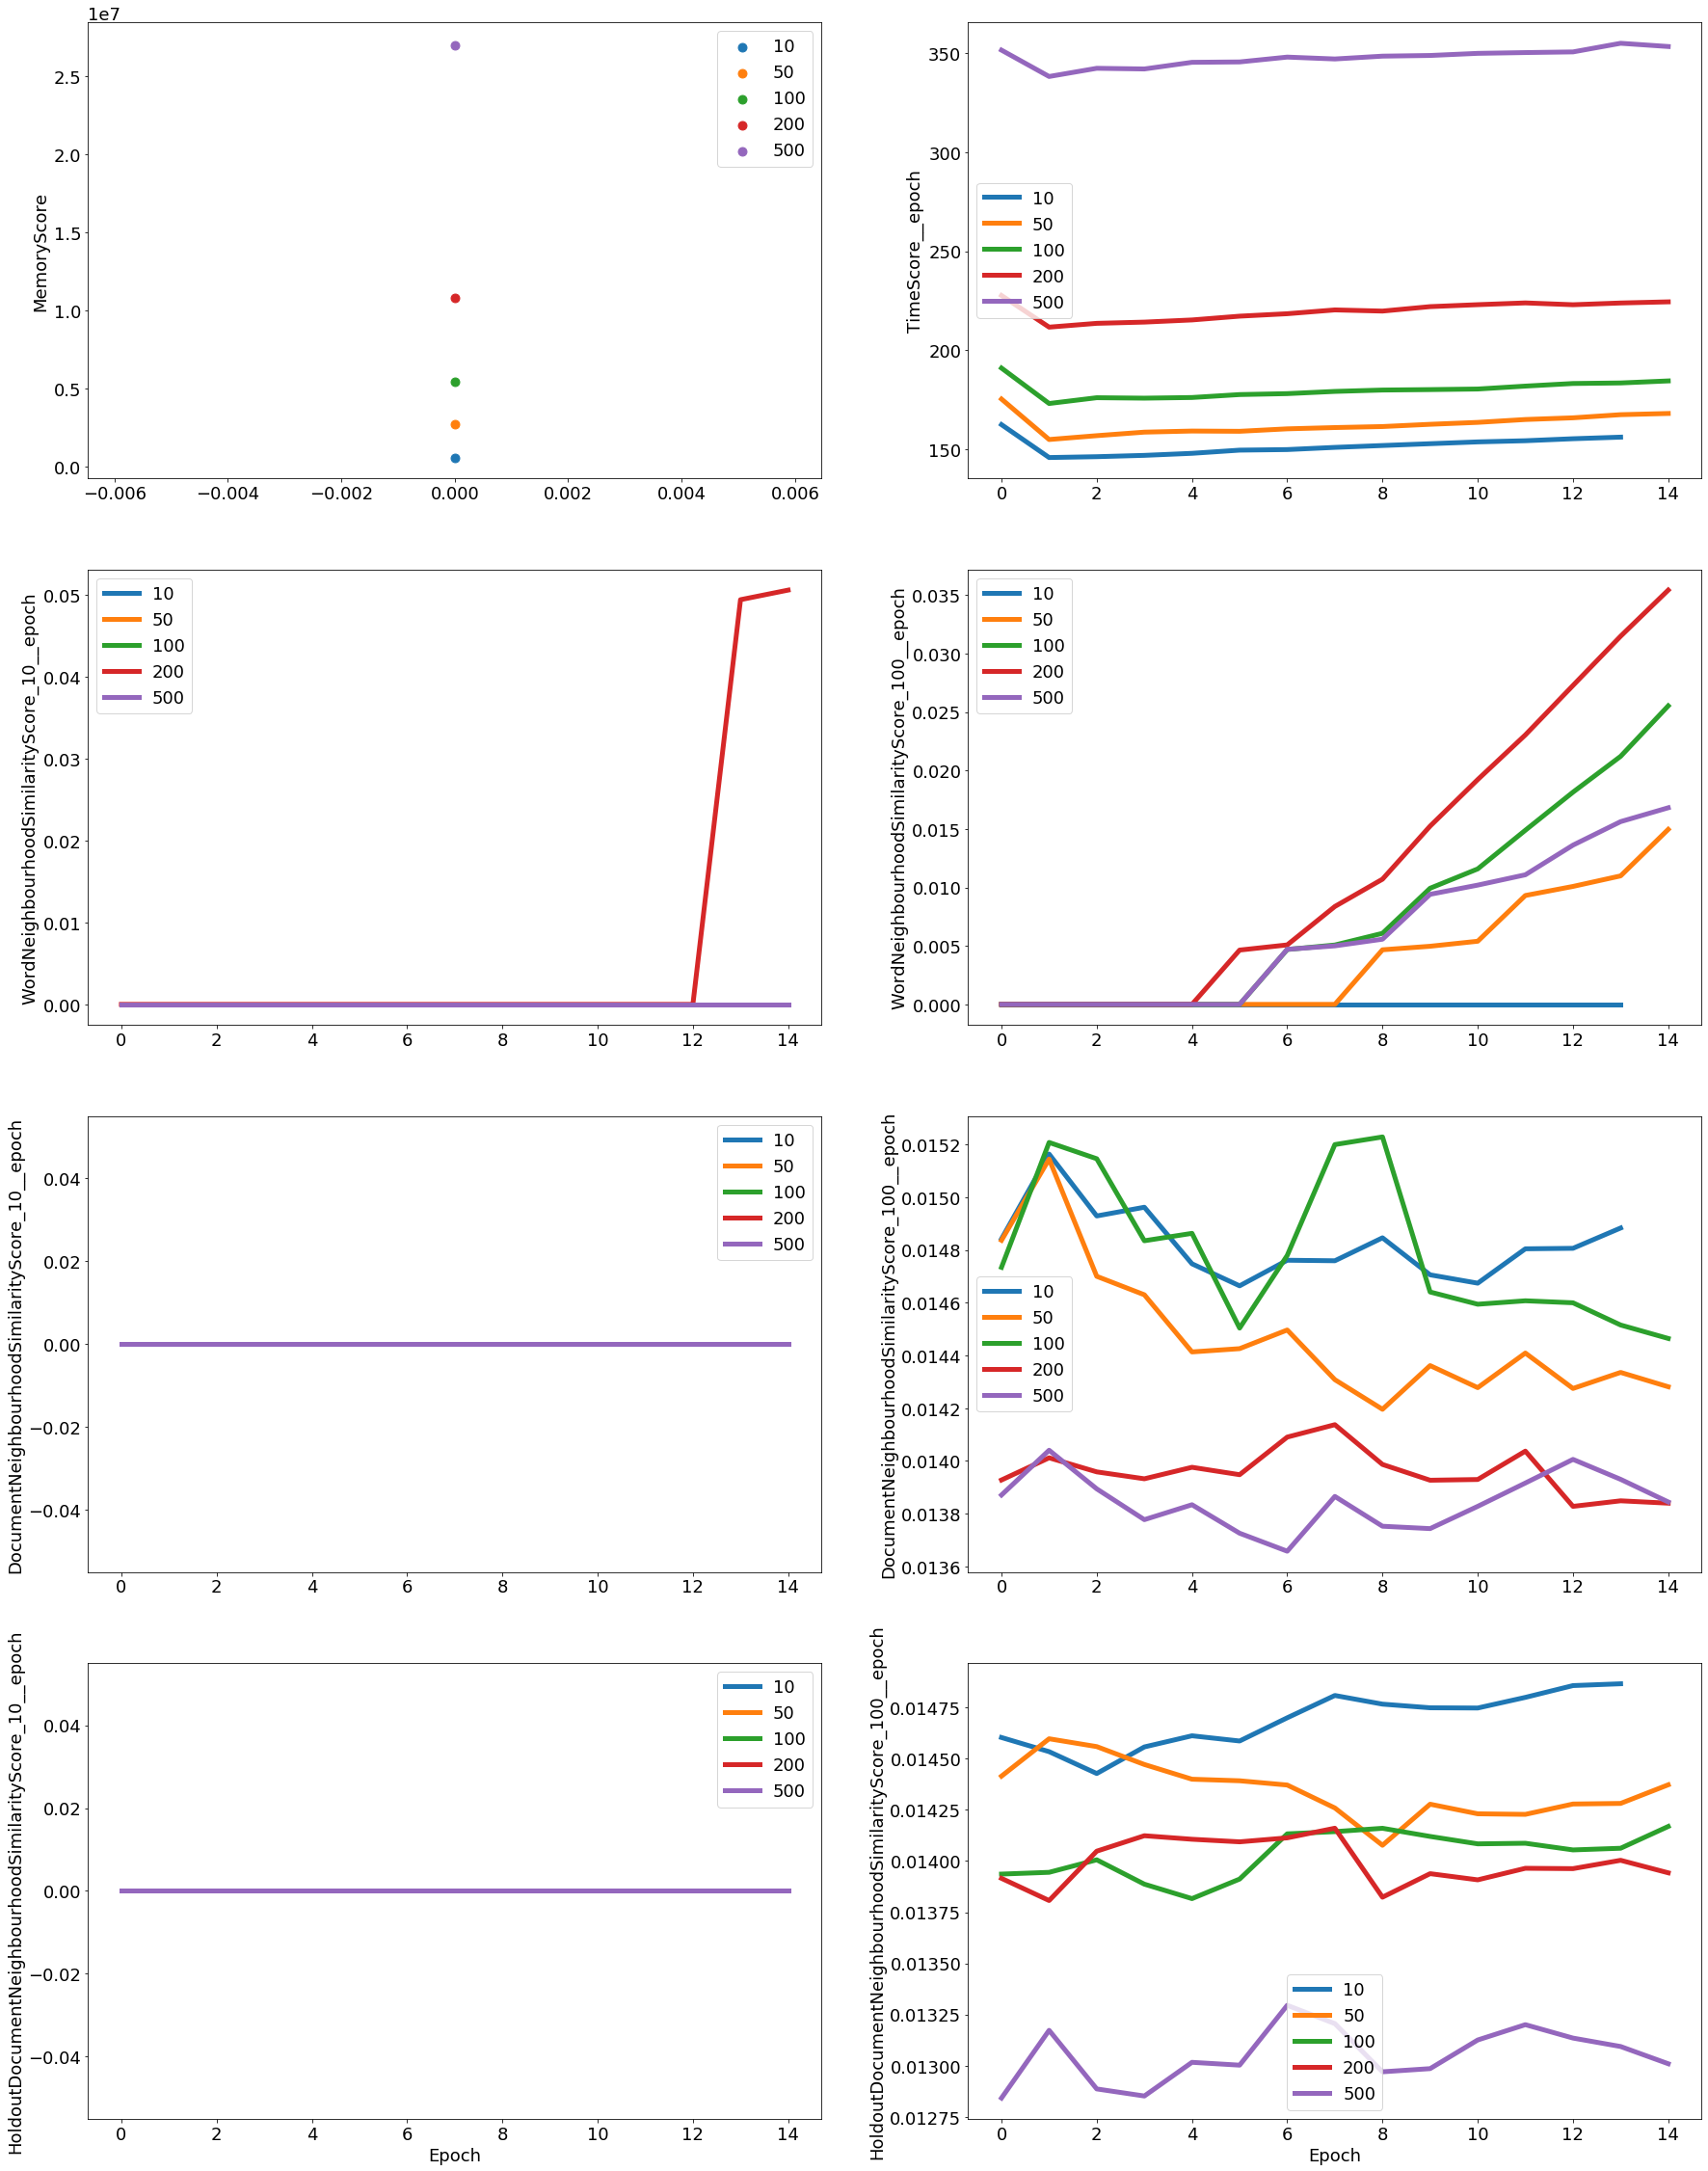

In [1676]:
num_cols = 2
num_rows = len(SCORES_TO_SHOW) // 2

old_font_size = plt.rcParams['font.size']
plt.rcParams.update({'font.size': 18})

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 15, num_rows * 10))

for i, score in enumerate(SCORES_TO_SHOW):
    ax = axes[i // num_cols][i % num_cols]
    
    for embedding_size, result in embsize_to_result.items():
        m = result[0]
        score_values = m.get_score_values(score)
        
        if score == 'MemoryScore':  # TODO
            ax.scatter(0, score_values[0], label=embedding_size, s=80)
            
        else:
            ax.plot(score_values, label=embedding_size, lw=5)
        
        ax.set_ylabel(score)

for ax in axes[num_rows - 1]:
    ax.set_xlabel('Epoch')

for axes_row in axes:
    for ax in axes_row:
        ax.legend()

plt.show()

plt.rcParams.update({'font.size': old_font_size})

In [1682]:
del embsize_to_result

In [1683]:
gc.collect()

644867

### Hyperparameters Tuning: Context Window Size<a id="finale-hyperparameters-window"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [1609]:
BEST_NUM_EPOCHS = 15
BEST_MODEL = SkipGramOneContextWord

In [1681]:
EMBEDDING_SIZE

100

In [1684]:
WINDOW

4

In [1685]:
WINDOWS = [1, 2, 4, 8, 16]

In [1691]:
window_to_result = dict()

In [1692]:
for window in WINDOWS:
    logger.info(f'WINDOW: {window}')
    
    model = BEST_MODEL(
        embedding_size=EMBEDDING_SIZE,
        vocab_size=len(VOCABULARY)
    )

    attach_scores(
        model,
        WORD_SIMILARITIES,
        WORD_INDICES_SAMPLE,
        TRAIN_DOCUMENT_SIMILARITIES,
        TRAIN_DOCUMENT_WORD_INDICES,
        TRAIN_DOCUMENT_INDICES_SAMPLE,
        holdout_document_similarities=TEST_DOCUMENT_SIMILARITIES,
        holdout_document_words=TEST_DOCUMENT_WORD_INDICES,
        holdout_documents_to_score=TEST_DOCUMENTS_INDICES_SAMPLE,
        nums_most_similar=[10, 100]
    )

    context_tensors_generator = lambda: one_context_batches(
        target_one_context_tensors(
            TRAIN_DOCUMENT_WORD_INDICES,
            window=window
        ),
        batch_size=BATCH_SIZE
    )

    trainer = SoftmaxModelTrainer(
        num_data_bunches_to_compute_scores=1000,
        max_num_epochs=BEST_NUM_EPOCHS,
        device=DEVICE,
        verbose=False
    )

    logger.info(f'Training model...')
    
    model, losses_per_epoch, losses_per_bunch = (
        trainer.train(
            model,
            context_tensors_generator,
            f'SkipGramOneContextWord__window_{window}'
        )
    )
    
    logger.info(f'Finished training!')
    
    window_to_result[window] = (model, losses_per_epoch, losses_per_bunch)

In [1693]:
window_to_result.keys()

dict_keys([1, 2, 4, 8, 16])

/home/vasiliyalekseev/miniconda/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


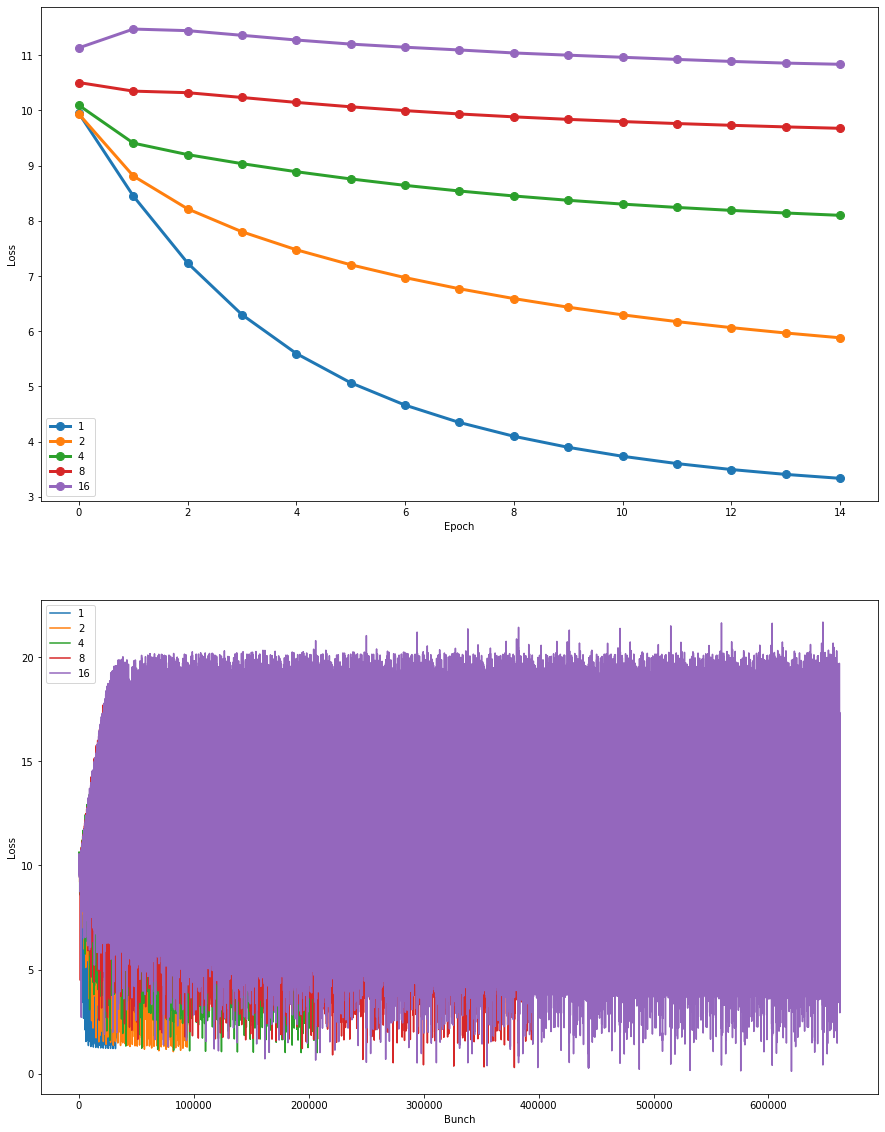

In [1694]:
fig, axes = plt.subplots(2, 1, figsize=(15, 2 * 10))

for window, result in window_to_result.items():
    axes[0].plot(result[1], label=window, lw=3, marker='.', ms=16)
    axes[1].plot(result[2], label=window)
    
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].set_xlabel('Bunch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()

In [1695]:
list(window_to_result.values())[0][0].score_names

['MemoryScore',
 'TimeScore__bunch',
 'WordNeighbourhoodSimilarityScore_10__bunch',
 'DocumentNeighbourhoodSimilarityScore_10__bunch',
 'HoldoutDocumentNeighbourhoodSimilarityScore_10__bunch',
 'WordNeighbourhoodSimilarityScore_100__bunch',
 'DocumentNeighbourhoodSimilarityScore_100__bunch',
 'HoldoutDocumentNeighbourhoodSimilarityScore_100__bunch',
 'TimeScore__epoch',
 'WordNeighbourhoodSimilarityScore_10__epoch',
 'DocumentNeighbourhoodSimilarityScore_10__epoch',
 'HoldoutDocumentNeighbourhoodSimilarityScore_10__epoch',
 'WordNeighbourhoodSimilarityScore_100__epoch',
 'DocumentNeighbourhoodSimilarityScore_100__epoch',
 'HoldoutDocumentNeighbourhoodSimilarityScore_100__epoch']

In [1652]:
SCORES_TO_SHOW = [
    'MemoryScore',
    'TimeScore__epoch',
    'WordNeighbourhoodSimilarityScore_10__epoch',
    'WordNeighbourhoodSimilarityScore_100__epoch',
    'DocumentNeighbourhoodSimilarityScore_10__epoch',
    'DocumentNeighbourhoodSimilarityScore_100__epoch',
    'HoldoutDocumentNeighbourhoodSimilarityScore_10__epoch',
    'HoldoutDocumentNeighbourhoodSimilarityScore_100__epoch'
]

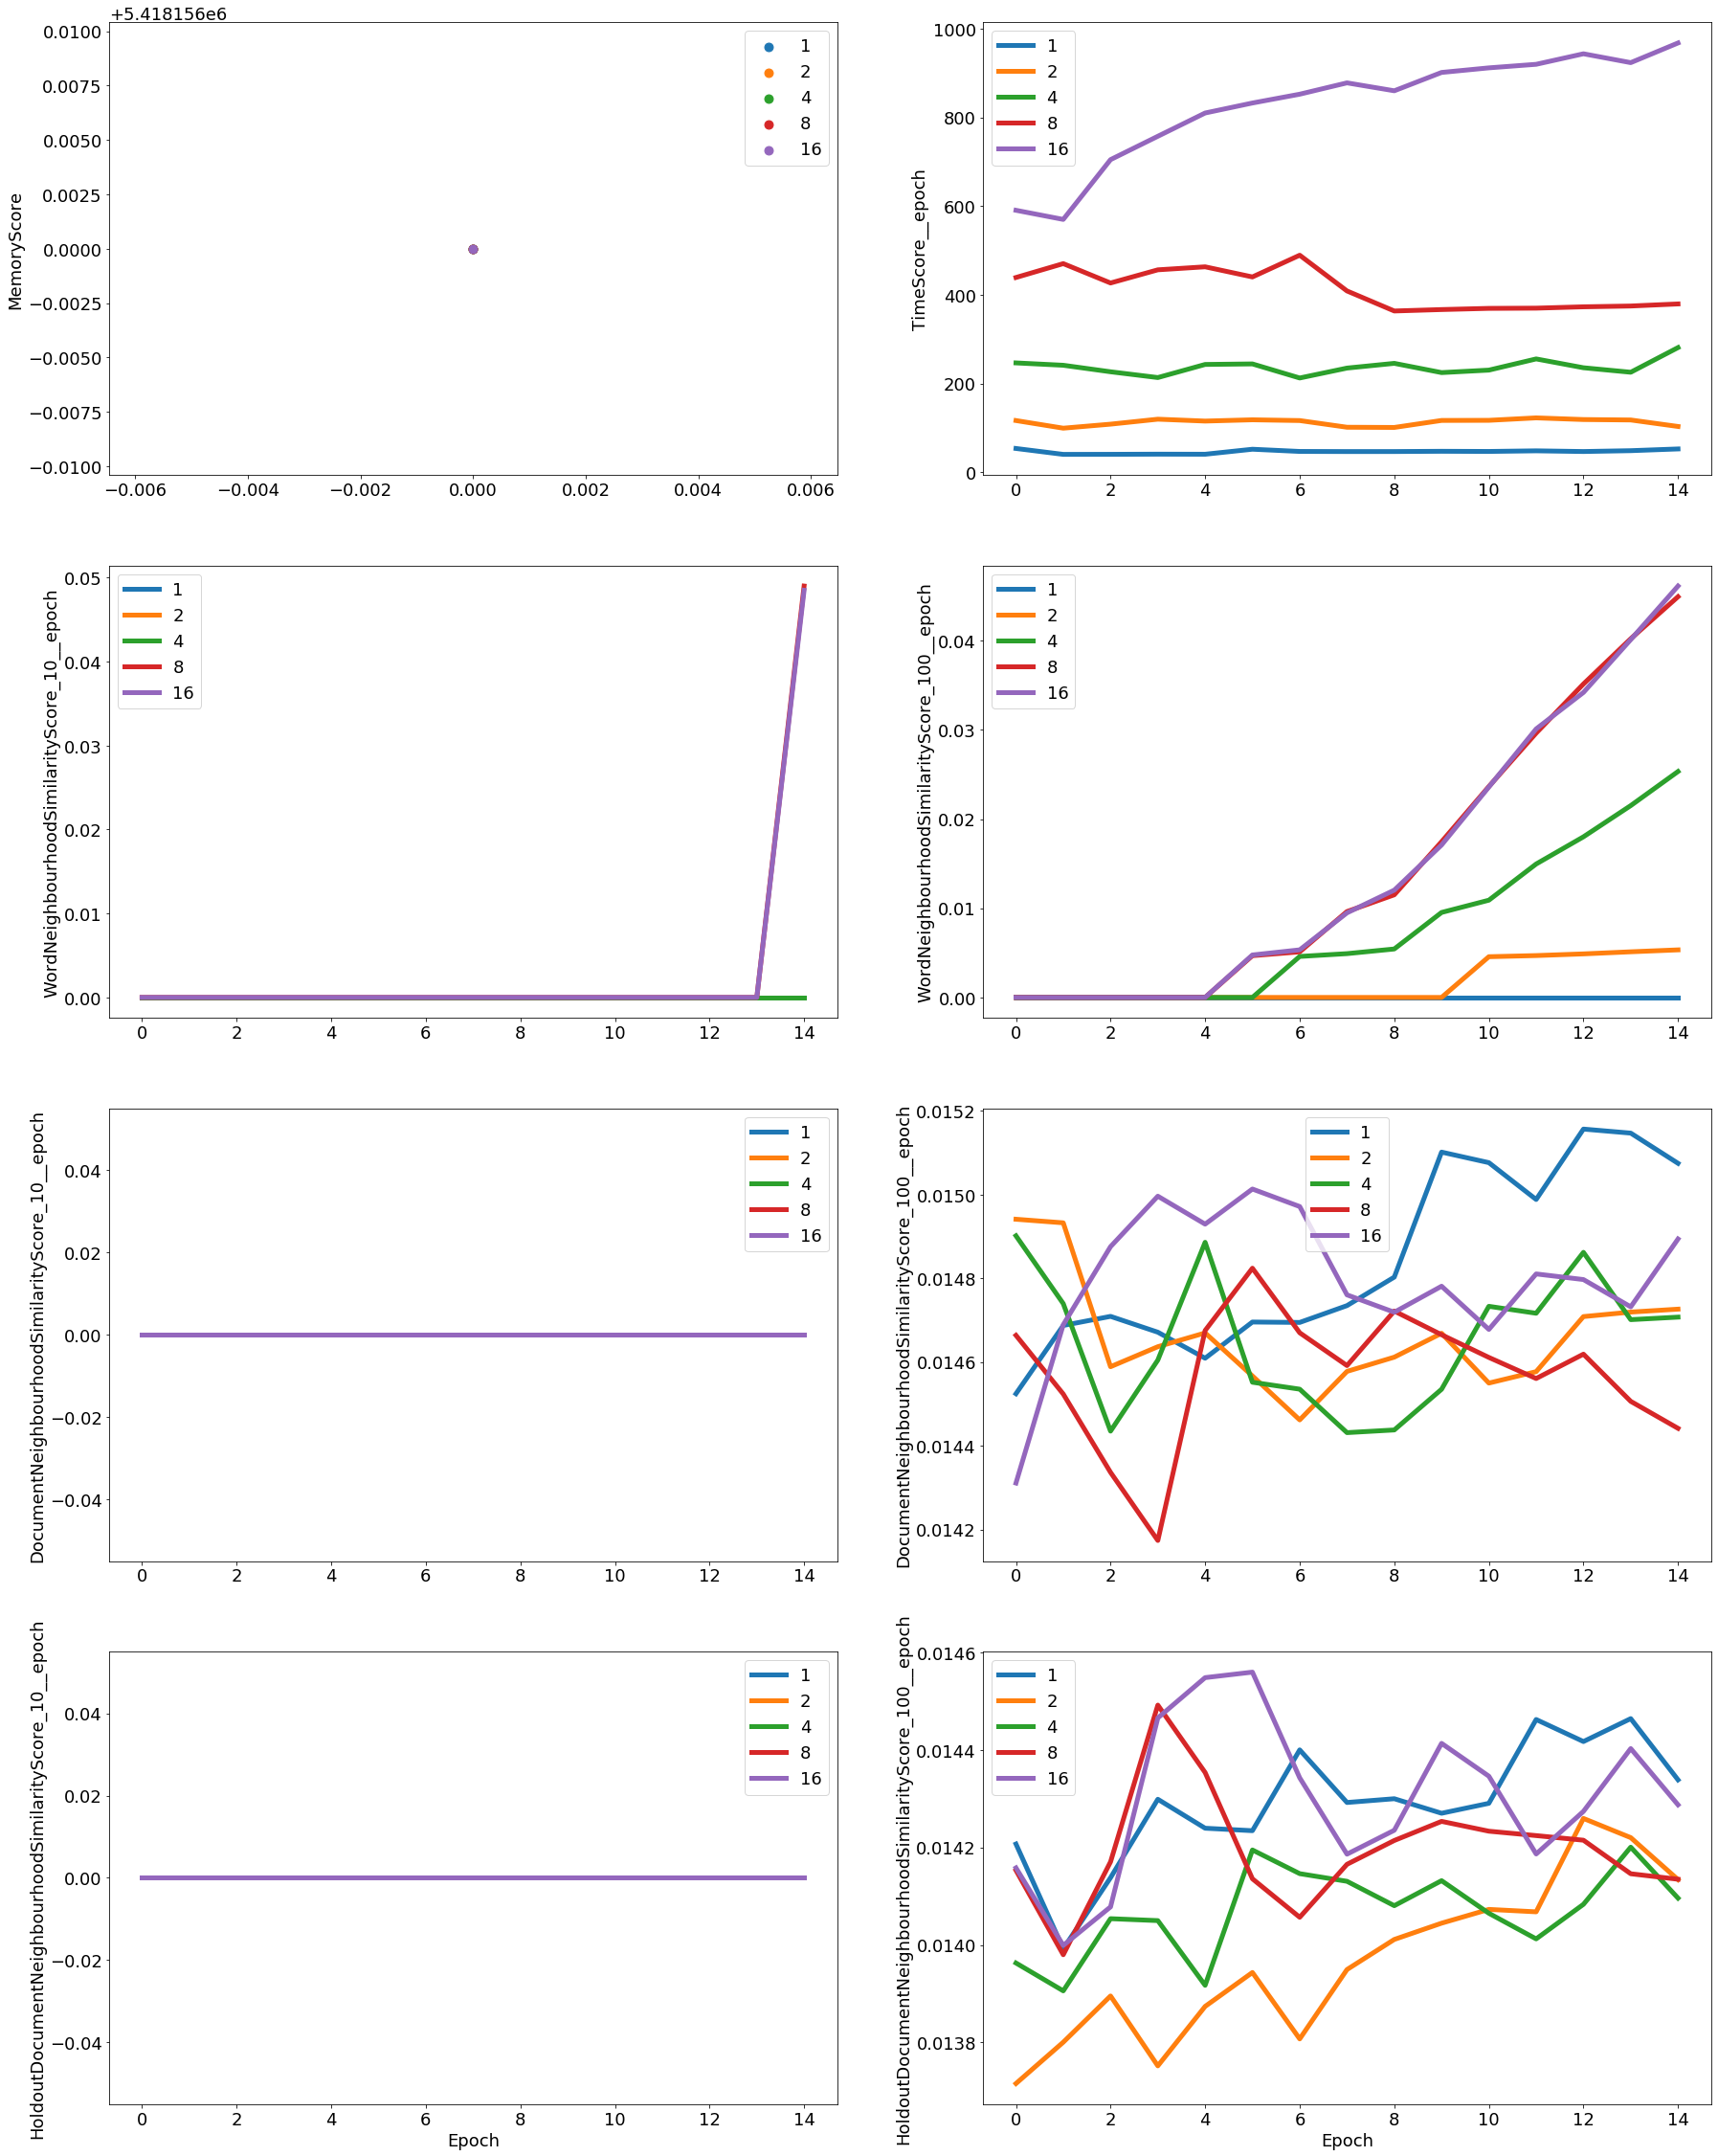

In [1696]:
num_cols = 2
num_rows = len(SCORES_TO_SHOW) // 2

old_font_size = plt.rcParams['font.size']
plt.rcParams.update({'font.size': 18})

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 15, num_rows * 10))

for i, score in enumerate(SCORES_TO_SHOW):
    ax = axes[i // num_cols][i % num_cols]
    
    for window, result in window_to_result.items():
        m = result[0]
        score_values = m.get_score_values(score)
        
        if score == 'MemoryScore':  # TODO
            ax.scatter(0, score_values[0], label=window, s=80)
            
        else:
            ax.plot(score_values, label=window, lw=5)
        
        ax.set_ylabel(score)

for ax in axes[num_rows - 1]:
    ax.set_xlabel('Epoch')

for axes_row in axes:
    for ax in axes_row:
        ax.legend()

plt.show()

plt.rcParams.update({'font.size': old_font_size})

In [ ]:
del window_to_result

In [1705]:
gc.collect()

41754

### Hyperparameters Tuning: Batch Size<a id="finale-hyperparameters-batch"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [1706]:
BEST_NUM_EPOCHS = 15
BEST_MODEL = SkipGramOneContextWord

In [1707]:
EMBEDDING_SIZE

100

In [1708]:
WINDOW

4

In [1709]:
BATCH_SIZE

64

In [1710]:
BATCH_SIZES = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [1714]:
BATCH_SIZE_TO_NUM_BATCHES_TO_COMPUTE_SCORES = {
    1    : 50000,
    2    : 25000,
    4    : 12500,
    8    : 6250,
    16   : 3100,
    32   : 1500,
    64   : 800,
    128  : 400,
    256  : 200,
    512  : 100,
    1024 : 50
}

In [1715]:
assert len(set(BATCH_SIZES).symmetric_difference(
    BATCH_SIZE_TO_NUM_BATCHES_TO_COMPUTE_SCORES)) == 0

In [1711]:
batsize_to_result = dict()

In [1743]:
for batch_size in BATCH_SIZES:
    logger.info(f'BATCH SIZE: {batch_size}')
    
    model = BEST_MODEL(
        embedding_size=EMBEDDING_SIZE,
        vocab_size=len(VOCABULARY)
    )

    attach_scores(
        model,
        WORD_SIMILARITIES,
        WORD_INDICES_SAMPLE,
        TRAIN_DOCUMENT_SIMILARITIES,
        TRAIN_DOCUMENT_WORD_INDICES,
        TRAIN_DOCUMENT_INDICES_SAMPLE,
        holdout_document_similarities=TEST_DOCUMENT_SIMILARITIES,
        holdout_document_words=TEST_DOCUMENT_WORD_INDICES,
        holdout_documents_to_score=TEST_DOCUMENTS_INDICES_SAMPLE,
        nums_most_similar=[10, 100]
    )

    context_tensors_generator = lambda: one_context_batches(
        target_one_context_tensors(
            TRAIN_DOCUMENT_WORD_INDICES,
            WINDOW
        ),
        batch_size=batch_size
    )
    
    num_data_bunches_to_compute_scores = BATCH_SIZE_TO_NUM_BATCHES_TO_COMPUTE_SCORES[batch_size]

    trainer = SoftmaxModelTrainer(
        num_data_bunches_to_compute_scores=num_data_bunches_to_compute_scores,
        max_num_epochs=BEST_NUM_EPOCHS,
        device=DEVICE,
        verbose=False
    )

    logger.info(f'Training model...')
    
    model, losses_per_epoch, losses_per_bunch = (
        trainer.train(
            model,
            context_tensors_generator,
            f'SkipGramOneContextWord__batch_size_{batch_size}'
        )
    )
    
    logger.info(f'Finished training!')
    
    batsize_to_result[batch_size] = (model, losses_per_epoch, losses_per_bunch)

In [1744]:
batsize_to_result.keys()

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])

/home/vasiliyalekseev/miniconda/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


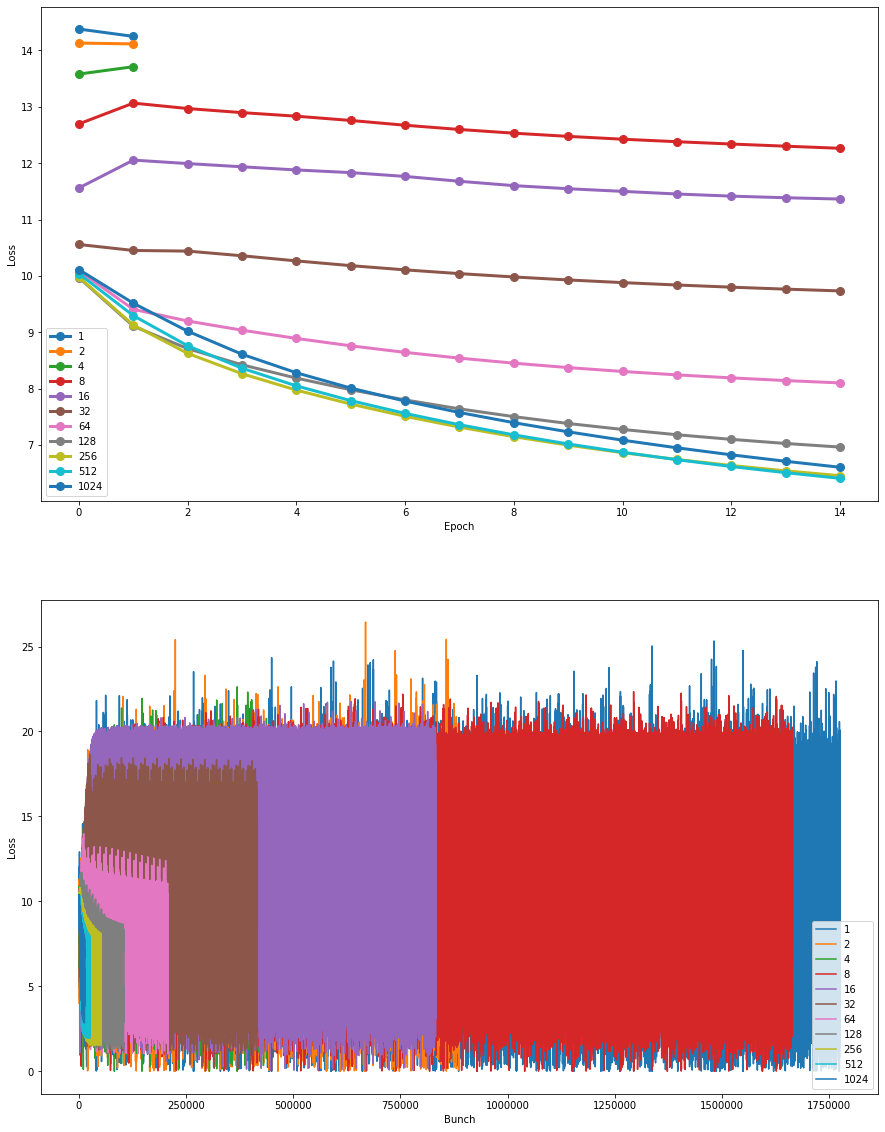

In [1745]:
fig, axes = plt.subplots(2, 1, figsize=(15, 2 * 10))

for batch_size, result in batsize_to_result.items():
    axes[0].plot(result[1], label=batch_size, lw=3, marker='.', ms=16)
    axes[1].plot(result[2], label=batch_size)
    
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].set_xlabel('Bunch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()

In [1695]:
list(batsize_to_result.values())[0][0].score_names

['MemoryScore',
 'TimeScore__bunch',
 'WordNeighbourhoodSimilarityScore_10__bunch',
 'DocumentNeighbourhoodSimilarityScore_10__bunch',
 'HoldoutDocumentNeighbourhoodSimilarityScore_10__bunch',
 'WordNeighbourhoodSimilarityScore_100__bunch',
 'DocumentNeighbourhoodSimilarityScore_100__bunch',
 'HoldoutDocumentNeighbourhoodSimilarityScore_100__bunch',
 'TimeScore__epoch',
 'WordNeighbourhoodSimilarityScore_10__epoch',
 'DocumentNeighbourhoodSimilarityScore_10__epoch',
 'HoldoutDocumentNeighbourhoodSimilarityScore_10__epoch',
 'WordNeighbourhoodSimilarityScore_100__epoch',
 'DocumentNeighbourhoodSimilarityScore_100__epoch',
 'HoldoutDocumentNeighbourhoodSimilarityScore_100__epoch']

In [1652]:
SCORES_TO_SHOW = [
    'MemoryScore',
    'TimeScore__epoch',
    'WordNeighbourhoodSimilarityScore_10__epoch',
    'WordNeighbourhoodSimilarityScore_100__epoch',
    'DocumentNeighbourhoodSimilarityScore_10__epoch',
    'DocumentNeighbourhoodSimilarityScore_100__epoch',
    'HoldoutDocumentNeighbourhoodSimilarityScore_10__epoch',
    'HoldoutDocumentNeighbourhoodSimilarityScore_100__epoch'
]

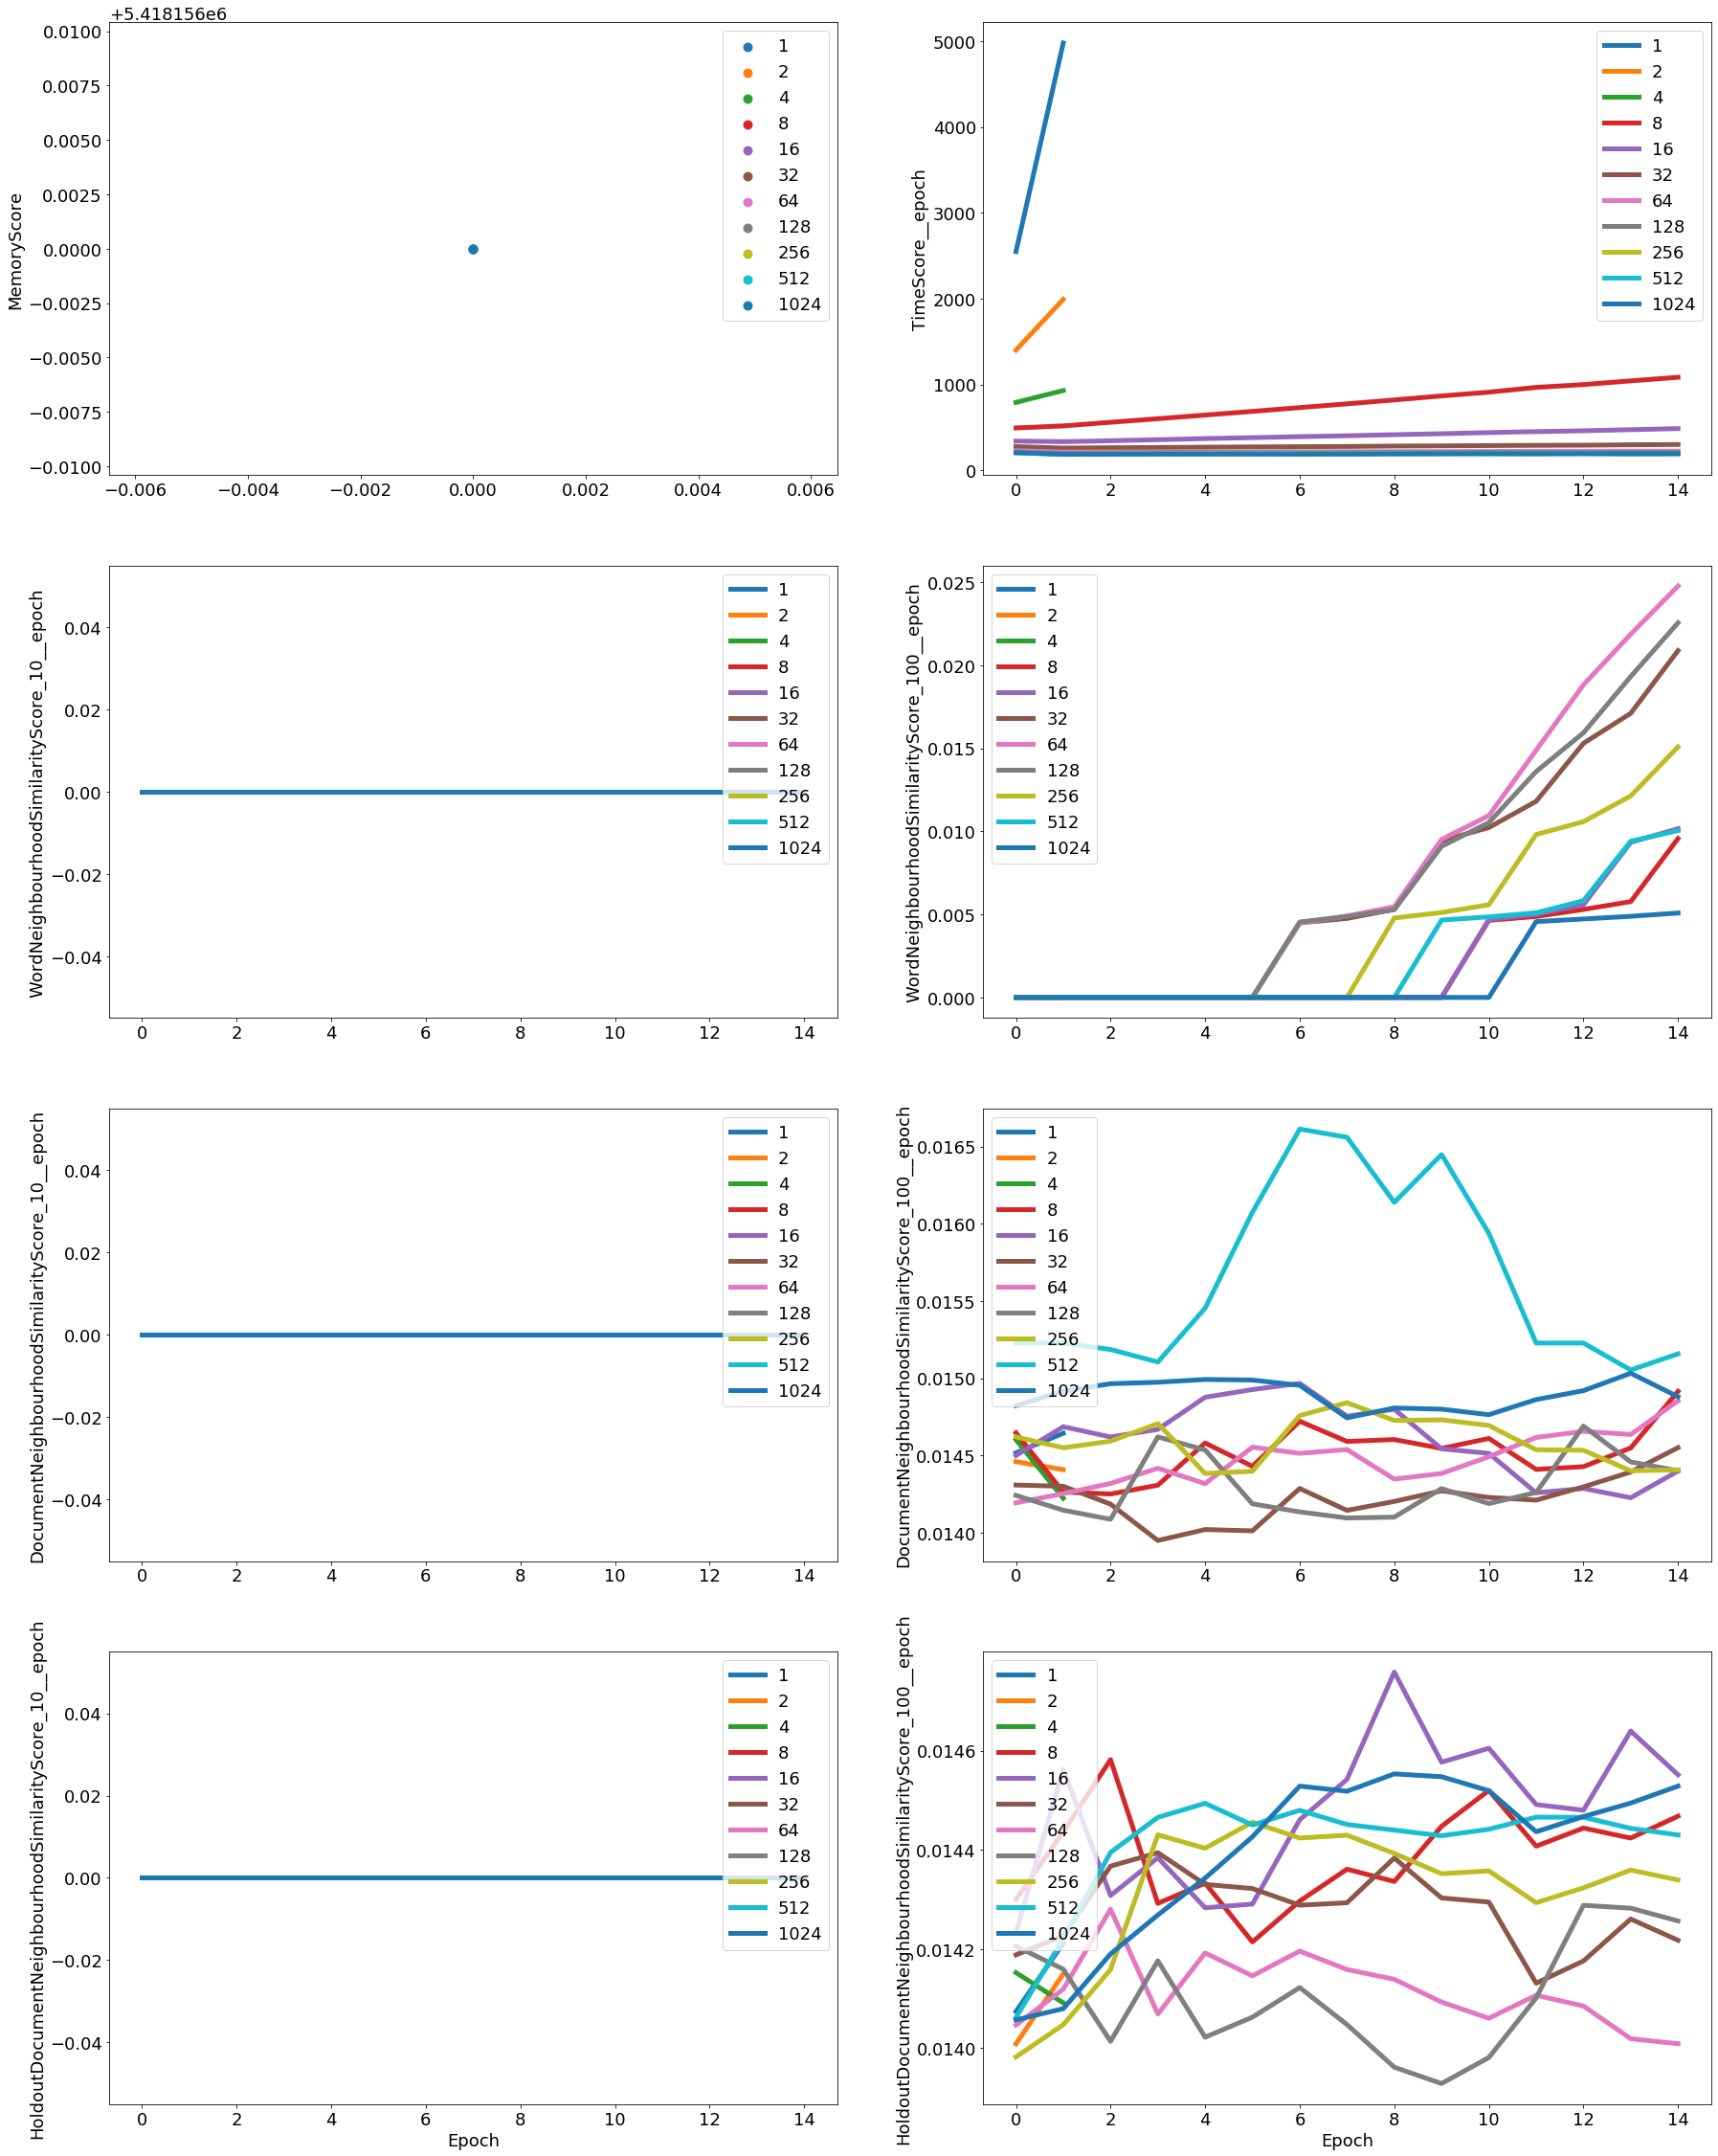

In [1746]:
num_cols = 2
num_rows = len(SCORES_TO_SHOW) // 2

old_font_size = plt.rcParams['font.size']
plt.rcParams.update({'font.size': 18})

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 15, num_rows * 10))

for i, score in enumerate(SCORES_TO_SHOW):
    ax = axes[i // num_cols][i % num_cols]
    
    for batch_size, result in batsize_to_result.items():
        m = result[0]
        score_values = m.get_score_values(score)
        
        if score == 'MemoryScore':  # TODO
            ax.scatter(0, score_values[0], label=batch_size, s=80)
            
        else:
            ax.plot(score_values, label=batch_size, lw=5)
        
        ax.set_ylabel(score)

for ax in axes[num_rows - 1]:
    ax.set_xlabel('Epoch')

for axes_row in axes:
    for ax in axes_row:
        ax.legend()

plt.show()

plt.rcParams.update({'font.size': old_font_size})

This is it (almost)!
Congratulations if you lived till here.

P.S.  
If you uncomment and execute the code in the cell below, it will delete the working directory with all the created files in it.

In [ ]:
# shutil.rmtree(working_directory)

# Word2Vec + Bayes = ...<a id="bayes"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

* https://arxiv.org/abs/1603.06571

Ordinary SG with negative sampling produces *point estimates* for $U$ and $V$.
Here we will try to use Bayesian approach for deriving *distributions* for $U$ and $V$.
Let's assume that each target and context random vectors are independent and have normal priors with a zero mean and diagonal covariance with a precision parameter $\tau$ as follows 

$$
  \left\{
  \begin{aligned}
    &p(u_i) = \mathcal N_{u_i}(0, \tau^{-1} I)\\
    &p(v_i) = \mathcal N_{v_i}(0, \tau^{-1} I)\\
    &\forall i \in I_W
  \end{aligned}
  \right.
$$

Note that different values of $\tau$ can be set to the priors over $U$ and $V$.
Furthermore, these hyperparameters can be themselves treated as random variables and be learned from
the data.

We define $C(w_i)$ as a multiset that contains the indices of the context words of $w_i$ in the corpus.
Let
$I_P = \bigl\{(i, j) \mid j \in C(w_i)\bigr\}$
$I_N = \bigl\{(i, j) \mid j \not\in C(w_i)\bigr\}$
be the positive and negative sets, respectively.
Note that $I_P$ is a multiset too and $I_N$'s size might be quadratic in the
vocabulary size $l$.
Therefore, we approximate $I_N$ by negative sampling.

Let $I_D \equiv I_P \cup I_N$ and define $D \equiv \{d_{ij} \mid (i, j) \in I_D\}$,
where $d \colon I_D \to \{+1, -1\}$ is a random variable

$$
  d_{ij} \equiv d((i, j)) \equiv
  \left\{
  \begin{aligned}
    &+1, (i, j) \in I_P\\
    &-1, (i, j) \in I_N
  \end{aligned}
  \right.
$$

Then, the likelihood of $d_{ij}$ is given by 
$P(d_{ij} \mid u_i, v_j) = \sigma(d_{ij} u_i^T v_j)$.

Let's note that when applied to multisets,
the operator $\cup$ is defined as the multiset sum and not as the multiset union.

The joint distribution of $U$, $V$ and $D$ is given by

\begin{equation}
\begin{split}
  p(U, V, D) &= P(D \mid U, V) p(U) p(V) \\
  &= \prod\limits_{(i, j) \in I_D} P(d_{ij} \mid u_i, v_j) \prod\limits_{i \in I_W} p(u_i) \prod\limits_{i \in I_W} p(v_i) \\
  &= \prod\limits_{(i, j) \in I_D} \sigma(d_{ij} u_i^T v_j) \prod\limits_{i \in I_W} \mathcal N_{u_i}(0, \tau^{-1} I) \prod\limits_{i \in I_W} \mathcal N_{v_i}(0, \tau^{-1} I)
\end{split}
\end{equation}

## Variational Approximation

We aim at computing the posterior $p(U, V \mid D)$.
However, a direct computation is hard.
The posterior can be approximated using [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) approaches such as Gibbs
sampling or by using [VB](https://en.wikipedia.org/wiki/Variational_Bayesian_methods) methods.
Here, we will try to apply VB approximation. 

Let $\theta \equiv U \cup V$.
VB approximates the posterior $p(\theta \mid D)$
by finding a fully factorized distribution 

$$
  q(\theta) = q(U, V) = q(U) q(V) = \prod\limits_{i=1}^l q(u_i) q(v_i)
$$
that minimizes the KL divergence

$$
  D_{KL}(q(\theta) \parallel p(\theta \mid D)) = 
  \int q(\theta) \log \frac{q(\theta)}{p(\theta \mid D)} d\theta
$$

To this end, we define the following expression

\begin{equation}
\begin{split}
  L(q) &\equiv \int q(\theta) \log \frac{p(\theta, D)}{q(\theta)} d\theta \\
  &= \int q(\theta) \log \frac{p(\theta \mid D)}{q(\theta)} d\theta +
    \int q(\theta) \log p(D) d\theta \\
  &= -D_{KL} \bigl(q(\theta) \parallel p(\theta \mid D)\bigr) + \log p(D)
\end{split}
\end{equation}

And after rearranging

$$
  D_{KL}(q(\theta) \parallel p(\theta \mid D)) = \log p(D) - L(q)
$$

Hence, minimizing $D_{KL}(q(\theta) \parallel p(\theta \mid D))$ is equivalent to maximizing $L(q)$.

It was shown ([Bishop 2006](http://www.machinelearning.ru/wiki/index.php?title=%D0%9F%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F:Bishop_2006_Pattern_Recognition_and_Machine_Learning)) that $L(q)$ is maximized by an iterative procedure that is guaranteed to converge to a local optimum.
This is done by updating each of $q$
factors, sequentially and according to the update rules

$$
  \left\{
  \begin{aligned}
    &q_{u_i}^* = \exp \Bigl( \mathbb E_{q\setminus u_i} \log p(\theta, D) + \mathrm{const} \Bigr)\\
    &q_{v_i}^* = \exp \Bigl( \mathbb E_{q\setminus v_i} \log p(\theta, D) + \mathrm{const} \Bigr)
  \end{aligned}
  \right.
$$

[Сonjugate relation](https://en.wikipedia.org/wiki/Conjugate_prior) between the [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) and
the priors does not hold and the distribution that is implied by
$\mathbb E_{q\setminus u_i} \log p(\theta, D)$ does not belong to
the [exponential family](https://en.wikipedia.org/wiki/Exponential_family).

Below is a draft of an idea how one can still bring $q$ to the Gaussian distribution.

Let's write the lower bound for $p(D \mid U, V)$.
The logistic bound ([Jaakkola and Jordan 1996](https://www.researchgate.net/profile/Michael_Jordan13/publication/2365311_A_variational_approach_to_Bayesian_logistic_regression_models_and_their_extensions/links/55104ea70cf2ba84483d4958/A-variational-approach-to-Bayesian-logistic-regression-models-and-their-extensions.pdf)):

$$
  \log \sigma(a) \geq \frac{a - \xi}{2} - \lambda(\xi) (a^2 - \xi^2) + \log\sigma(\xi)
$$
where $\lambda(\xi) = \frac{1}{2\xi}\left( \sigma(\xi) - \frac{1}{2} \right)$

So
$$
  \log p(D \mid \theta) \geq p_{\xi}(D \mid \theta) =
  \sum\limits_{(i, j) \in I_D} \frac{d_{ij}u_i^T v_j - \xi_{ij}}{2} -
    \lambda(\xi_{ij})\bigl( u_i^T v_j v_j^T u_i - \xi_{ij}^2 \bigr) +
    \log \sigma(\xi_{ij})
$$

Which implies the following bound for $L(q)$:

$$
  L(q) \geq L_{\xi}(q) =
  \int q(\theta) \log \frac{p_{\xi}(\theta, D)}{q(\theta)} d\theta =
  \int q(\theta) \log \frac{p_{\xi}(D \mid \theta) p(\theta)}{q(\theta)} d\theta
$$

The equations for $q$ can be updated by replacing $p(\theta, D)$ with $p_{\xi}(\theta, D)$:

$$
  \left\{
  \begin{aligned}
    &q_{u_i}^* = \exp \Bigl( \mathbb E_{q\setminus u_i} \log p_{\xi}(\theta, D) + \mathrm{const} \Bigr)\\
    &q_{v_i}^* = \exp \Bigl( \mathbb E_{q\setminus v_i} \log p_{\xi}(\theta, D) + \mathrm{const} \Bigr)
  \end{aligned}
  \right.
$$

It is possible to show how one can compute $\xi_{ij}$ to make $q_{\cdot}$ have Gaussian distribution:

$$ 
  \left\{
  \begin{aligned}
    &\log q_{u_i}^* = u_i^T r_{u_i}(v) - \frac{1}{2} u_i^T P_{u_i}(v) u_i + \mathrm{const}\\
    &\log q_{v_i}^* = v_i^T r_{v_i}(u) - \frac{1}{2} v_i^T P_{v_i}(u) v_i + \mathrm{const}
  \end{aligned}
  \right.
$$

This gives an alternating updates scheme for $q_{u_i}^*$ and $q_{v_j}^*$ that is guaranteed to converge to a local optimum.

# References<a id="references"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

## Tutotials

The notebook relies heavily on

* https://rguigoures.github.io/word2vec_pytorch/
* https://srijithr.gitlab.io/post/word2vec/

Here are another sources that also might be useful

* https://github.com/mmta-team/mmta_fall_2019/blob/master/03_word_embeddings/word_embeddings.pdf
* https://github.com/hse-aml/natural-language-processing/blob/master/week3/week3-Embeddings.ipynb
* https://github.com/DanAnastasyev/DeepNLP-Course/blob/master/Week%2002/Week_02_Word_Embeddings_(Part_1).ipynb
* https://github.com/DanAnastasyev/DeepNLP-Course/blob/master/Week%2003/Week_03_Word_Embeddings_(Part_2).ipynb
* https://towardsdatascience.com/implementing-word2vec-in-pytorch-skip-gram-model-e6bae040d2fb
* https://www.tensorflow.org/tutorials/text/word_embeddings
* https://www.kaggle.com/ashukr/implementation-of-word2vec-paper
* https://habr.com/ru/company/ods/blog/329410/


## Code (in Order of Importance for this Notebook)

* https://github.com/blackredscarf/pytorch-SkipGram/blob/master/model.py
* https://github.com/graykode/nlp-tutorial


## Papers

The notebook relies heavily on Bayesian Neural Word Embedding https://arxiv.org/abs/1603.06571.

Here are a couple of other coherent works that also might be useful to look at

* Efficient Estimation of Word Representations in Vector Space https://arxiv.org/abs/1301.3781  
(Core paper in W2V)
* Embedding Words as Distributions with a Bayesian Skip-gram Model https://arxiv.org/abs/1711.11027
* Bayesian Paragraph Vectors https://arxiv.org/abs/1711.03946
* Learning the Curriculum with Bayesian Optimization for Task-Specific Word Representation Learning https://arxiv.org/abs/1605.03852


## Bayesian Models

One can also find the actual code implementations of some of the W2V+Bayes ideas

* https://github.com/rrauber/Bayesian-Word-Vectors
* https://github.com/ixlan/BSG


## Word Embeddings

* Word2Vec https://code.google.com/archive/p/word2vec/
* GloVe https://github.com/stanfordnlp/GloVe
* fastText https://github.com/facebookresearch/fastText
* StarSpace https://github.com/facebookresearch/StarSpace

![](https://drive.google.com/uc?id=1o39sx0jmssLgu48t1VX0GEBtVcUjBVNZ)